In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import time
from lightgbm import LGBMClassifier
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', UserWarning)

In [2]:
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号


In [3]:
from sklearn.model_selection import train_test_split

In [4]:
data = pd.read_csv('./data_clean.csv')
# data = pd.read_csv('data_clean_rename.csv')
# data=data.sample(n=30,random_state=30)

In [5]:
data.head()

,PL_PPID,PL_ThreadAvg,PL_HandleAvg,DLL_Total,DLL_AvgPerProc,Hdl_AvgPerProc,Hdl_Event,Hdl_Key,Hdl_Thread,Hdl_Dir,...,Svc_Kernel,Svc_FS,Svc_Proc,Svc_SharedProc,Svc_Active,CB_Total,CB_Unknown,CB_Generic,Category,Class
0,17,10.555556,202.844444,1694,38.500000,212.302326,3161,716,887,104,...,221,26,24,116,121,87,0,8,0,0
1,19,11.531915,242.234043,2074,44.127660,242.234043,3761,1011,1030,117,...,222,26,24,118,122,87,0,8,0,0
2,14,14.725000,288.225000,1932,48.300000,288.225000,3996,784,1241,100,...,222,26,27,118,120,88,0,8,0,0
3,13,13.500000,264.281250,1445,45.156250,264.281250,2961,654,792,83,...,222,26,27,118,120,88,0,8,0,0
4,16,11.452381,281.333333,2067,49.214286,281.333333,3834,1252,942,103,...,222,26,24,118,124,87,0,8,0,0


In [6]:
# 获取数值型特征
num_feats = [f for f in data.columns if data[f].dtype != 'object' and f not in ['Category', 'Class']]
# 标签
label = 'Class'
# 获取字符型特征
categorical_feats = [f for f in data.columns if data[f].dtype == 'object']
# 获取入模特征
feats = num_feats+categorical_feats
# 对字符型特征进行编码
for f in categorical_feats:
    data[f], _ = pd.factorize(data[f])
    data[f] = data[f].astype('category')

In [44]:
# 划分训练集与测试集
train_data, test_data = train_test_split(data, test_size=0.3,random_state=100)

In [54]:
# 定义计算特征重要度的函数：
# 定义计算特征重要度的函数
def get_feature_importances(data, feats, categorical_feats, label, shuffle, seed=100):
    y = data[label].copy()
    if shuffle:
        y = data[label].copy().sample(frac=1.0)
    dtrain = lgb.Dataset(data[feats], y, free_raw_data=False, )
    lgb_params = {'random_state':100}
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=220, categorical_feature=categorical_feats)
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(feats)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[feats]))
    imp_df=pd.DataFrame(imp_df)
    print(imp_df)
    return  imp_df

In [55]:
# 计算靠谱特征重要度和不靠谱特征重要度：

In [56]:
# 正确标签下的特征重要度
actual_imp_df = get_feature_importances(data, feats, categorical_feats, label, shuffle=False)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4653
[LightGBM] [Info] Number of data points in the train set: 38757, number of used features: 32
[LightGBM] [Info] Start training from score 0.245788
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
            feature  importance_gain  importance_split  trn_score
0           PL_PPID         1.152425               108        1.0
1      PL_ThreadAvg        11.700322               497        1.0
2      PL_HandleAvg         1.769136               392        1.0
3         DLL_Total

In [57]:
# 打乱标签下的特征重要度
null_imp_df = pd.DataFrame()
nb_runs = 80
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    imp_df = get_feature_importances(data, feats, categorical_feats, label, shuffle=True)
    imp_df['run'] = i + 1
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4653
[LightGBM] [Info] Number of data points in the train set: 38757, number of used features: 32
[LightGBM] [Info] Start training from score 0.245788
            feature  importance_gain  importance_split  trn_score
0           PL_PPID        17.471316                33   0.771509
1      PL_ThreadAvg       449.163771               709   0.771509
2      PL_HandleAvg       233.680635               382   0.771509
3         DLL_Total       137.729777               210   0.771509
4    DLL_AvgPerProc       225.818636               378   0.771509
5    Hdl_AvgPerProc       248.241255               420   0.771509
6         Hdl_Event       221.507640               345   0.771509
7           Hdl_Key       207.825350               311   0.771509
8        Hdl_Thread       343.462016               538   0.77150

In [16]:
# 绘制特征重要性对比图
def split_polt_imp(data1, data2, num_feats):
    plt.rcParams['font.family'] = 'Times New Roman' 
    for i, feat in enumerate(num_feats):  # 使用enumerate函数进行遍历并获取索引
        plt.figure(dpi=600, figsize=(2,1))
        x1 = data1[data1['feature'] == feat]['importance_split'].values
        x2 = data2[data2['feature'] == feat]['importance_split'].mean()
        title_str = '(%s)%s' % (chr(97+i), feat.lower())
        plt.title(title_str, fontweight='bold',fontsize=8,y=-0.5)
        ax = plt.hist(x1, alpha=1, color='#8ea5c8', label='Null importance')
        plt.vlines(x2, 0, ax[0].max(), alpha=1,  color='#a17db4', linewidth=3, label='Real importance')
        plt.legend(bbox_to_anchor=(0.4,0.8),fontsize=5)
        
        plt.xticks(fontsize=8)  # 设置x刻度字体大小
        plt.yticks(fontsize=8)  # 设置y刻度字体大小
        
        plt.savefig(feat+'importance_split.jpg', dpi=600, bbox_inches='tight',pad_inches=0)
        plt.savefig(feat+'importance_split.svg', dpi=600, bbox_inches='tight',pad_inches=0)
        
        plt.show()

In [17]:
def gain_polt_imp(data1, data2, num_feats):
    plt.rcParams['font.family'] = 'Times New Roman' 
    for i, feat in enumerate(num_feats):  # 使用enumerate函数进行遍历并获取索引
        plt.figure(dpi=600, figsize=(2,1))
        x1 = data1[data1['feature'] == feat]['importance_gain'].values
        x2 = data2[data2['feature'] == feat]['importance_gain'].mean()
        title_str = '(%s)%s' % (chr(97+i), feat.lower())
        plt.title(title_str, fontweight='bold',fontsize=8,y=-0.5)
        ax = plt.hist(x1, alpha=1, color='#8ea5c8', label='Null importance')
        plt.vlines(x2, 0, ax[0].max(), alpha=1,  color='#a17db4', linewidth=2, label='Real importance')
        plt.legend(bbox_to_anchor=(0.4,0.8),fontsize=5)
        
        plt.xticks(fontsize=4)  # 设置x刻度字体大小
        plt.yticks(fontsize=4)  # 设置y刻度字体大小
        
        plt.savefig(feat+'importance_gain.jpg', dpi=600, bbox_inches='tight',pad_inches=0)
        plt.savefig(feat+'importance_gain.svg', dpi=600, bbox_inches='tight',pad_inches=0)
        
        plt.show()

In [18]:
pd.DataFrame(actual_imp_df)

,feature,importance_gain,importance_split,trn_score
0,PL_PPID,1.147008,99,1.0
1,PL_ThreadAvg,11.689222,444,1.0
2,PL_HandleAvg,1.757801,350,1.0
3,DLL_Total,42.541375,241,1.0
4,DLL_AvgPerProc,37196.524677,340,1.0
5,Hdl_AvgPerProc,3.741968,295,1.0
6,Hdl_Event,1.255020,240,1.0
7,Hdl_Key,0.529623,142,1.0
8,Hdl_Thread,228.656663,543,1.0
9,Hdl_Dir,9.058970,378,1.0


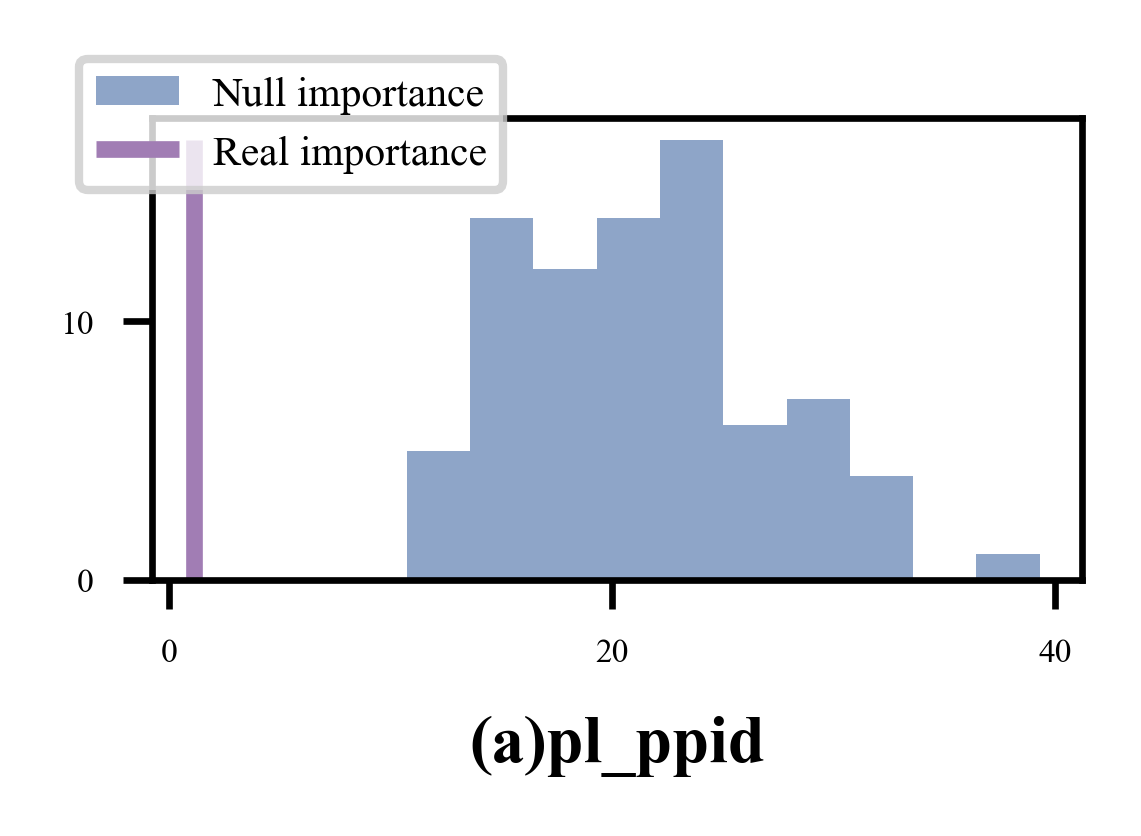

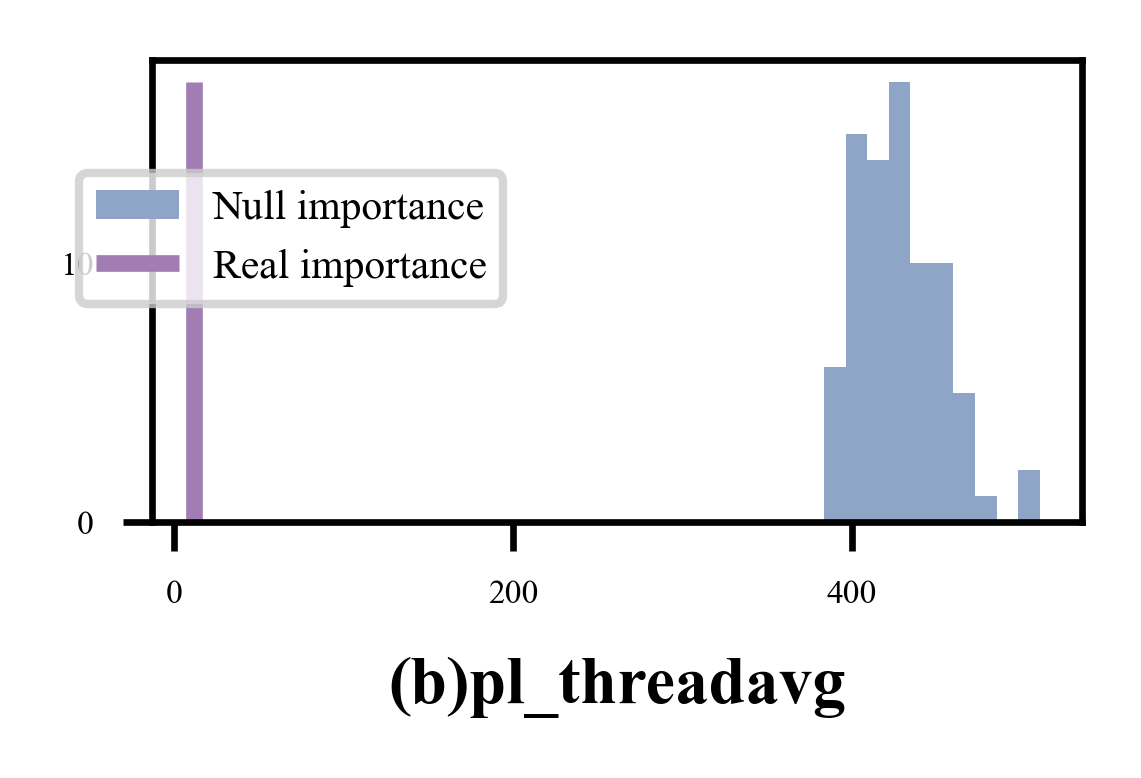

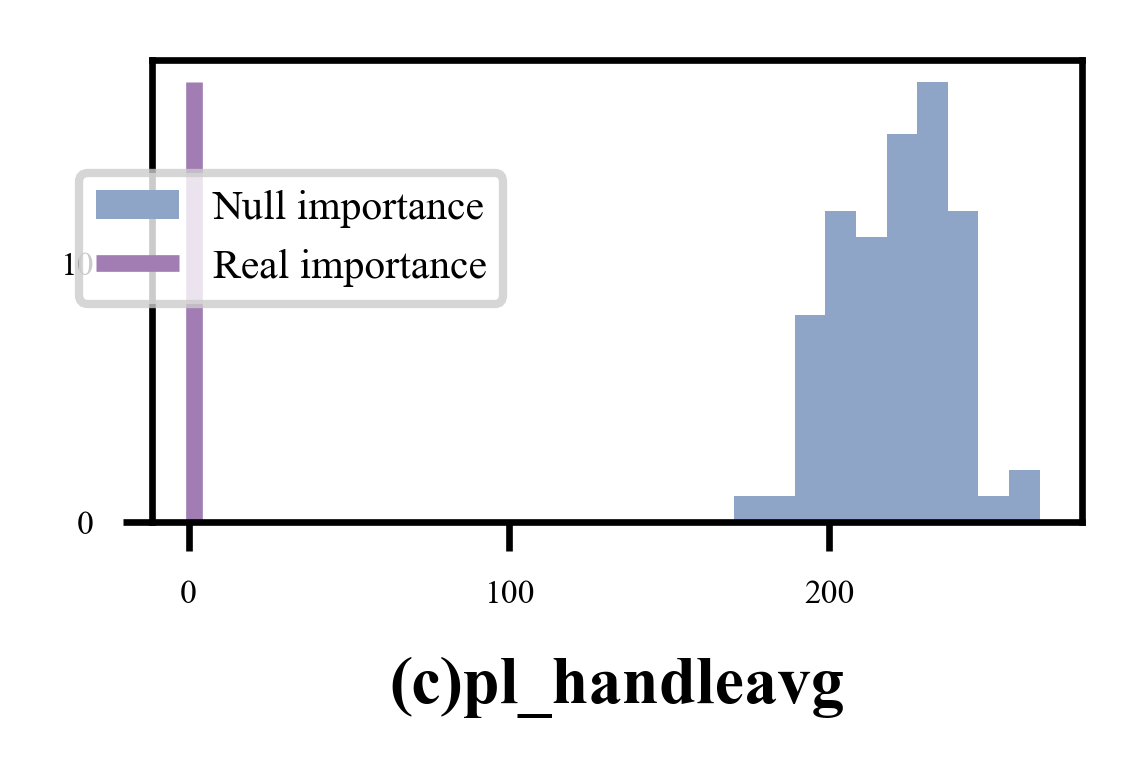

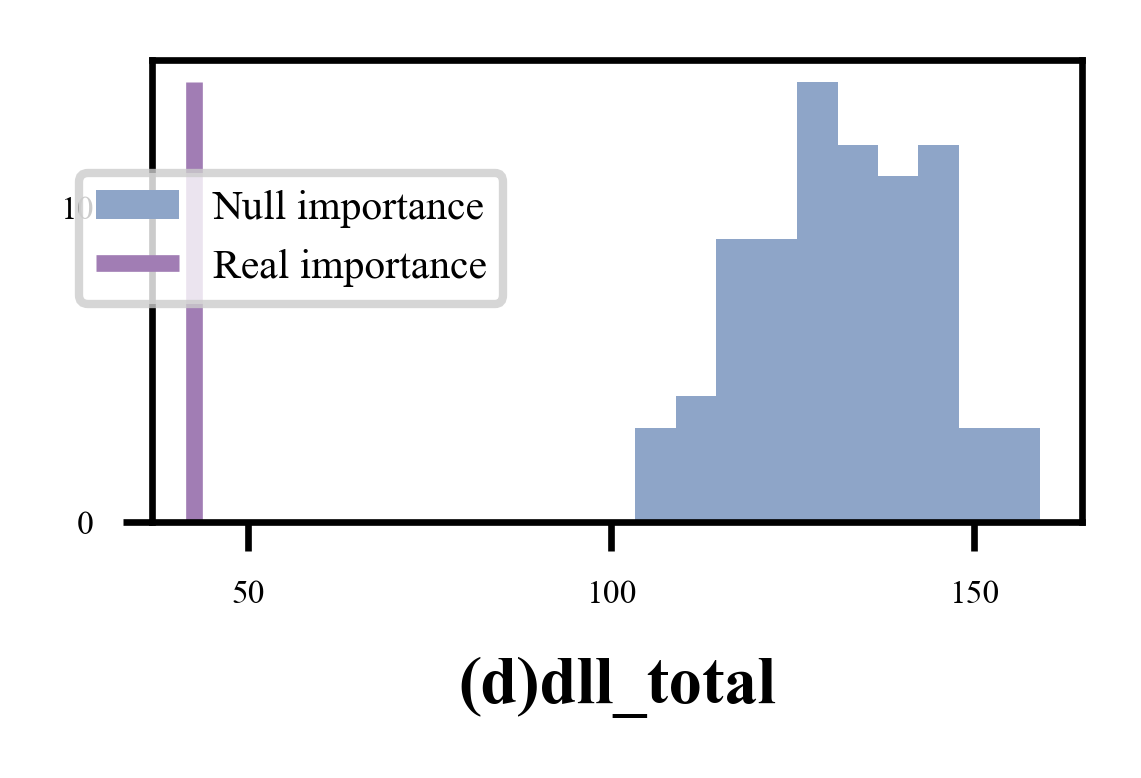

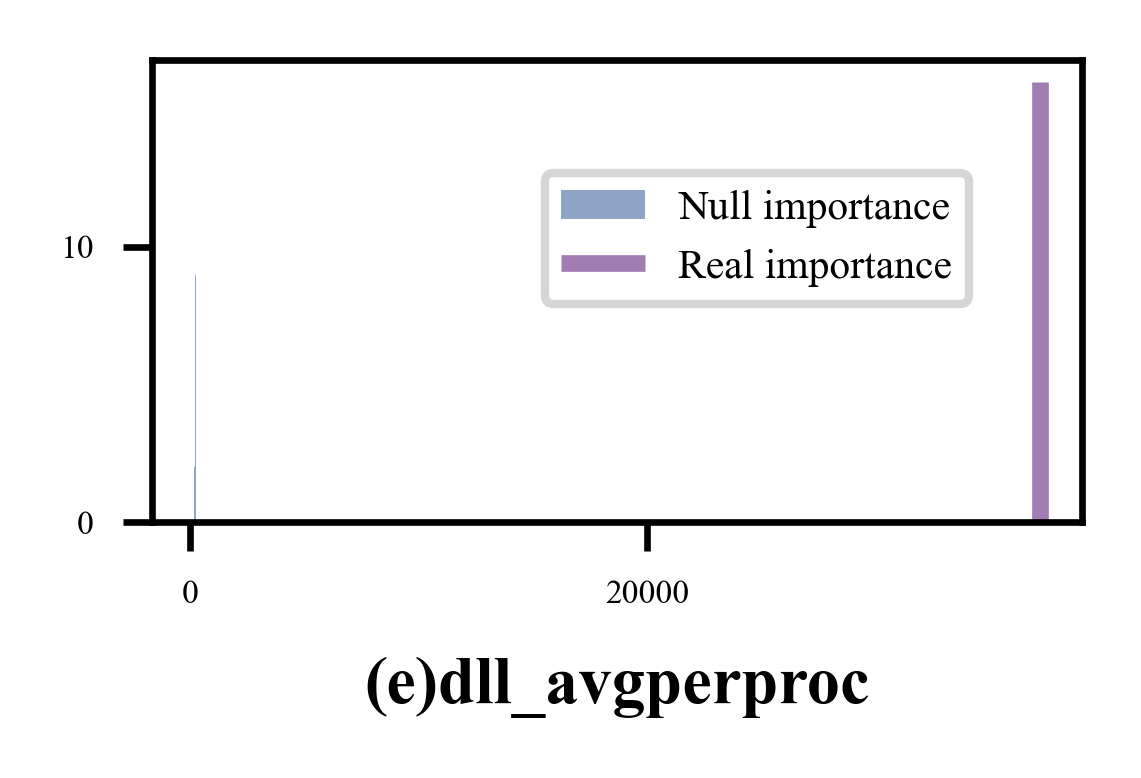

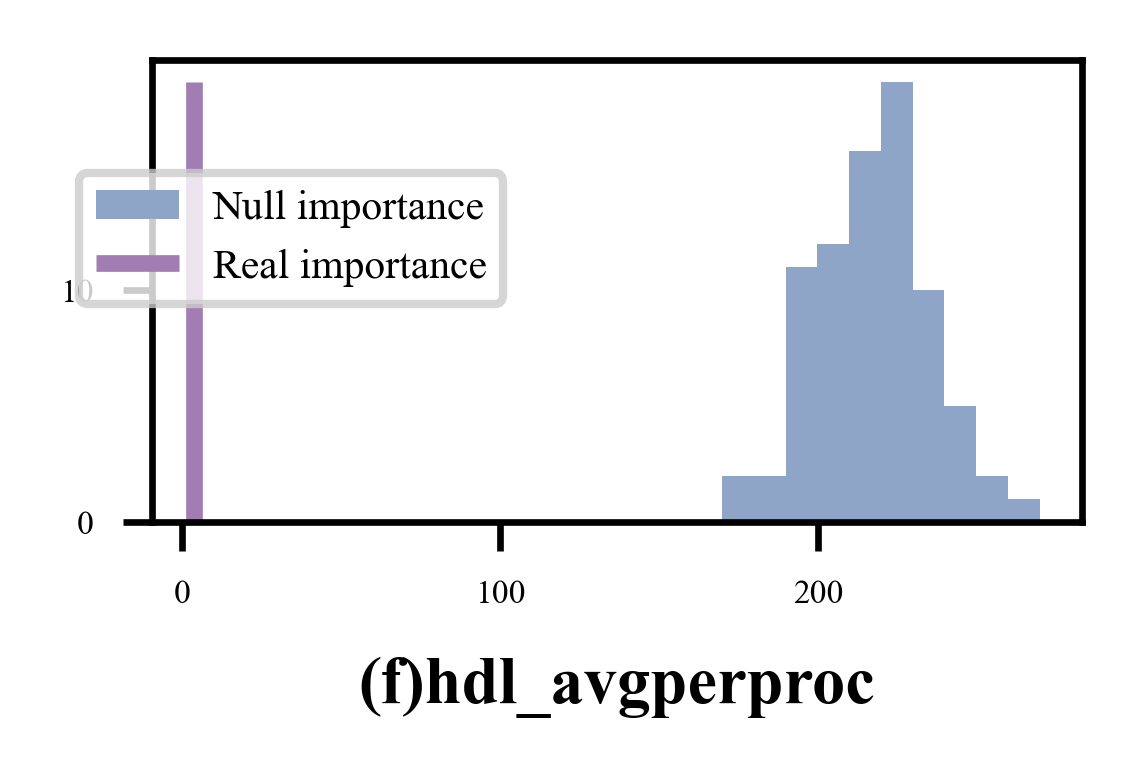

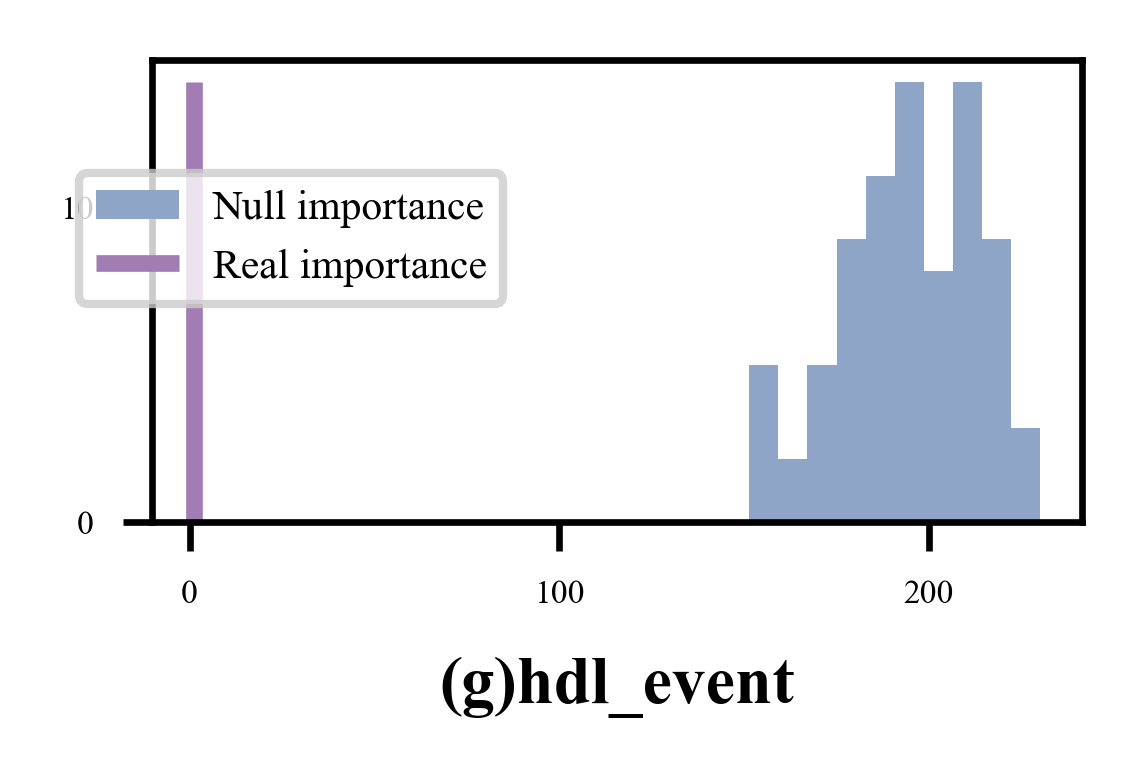

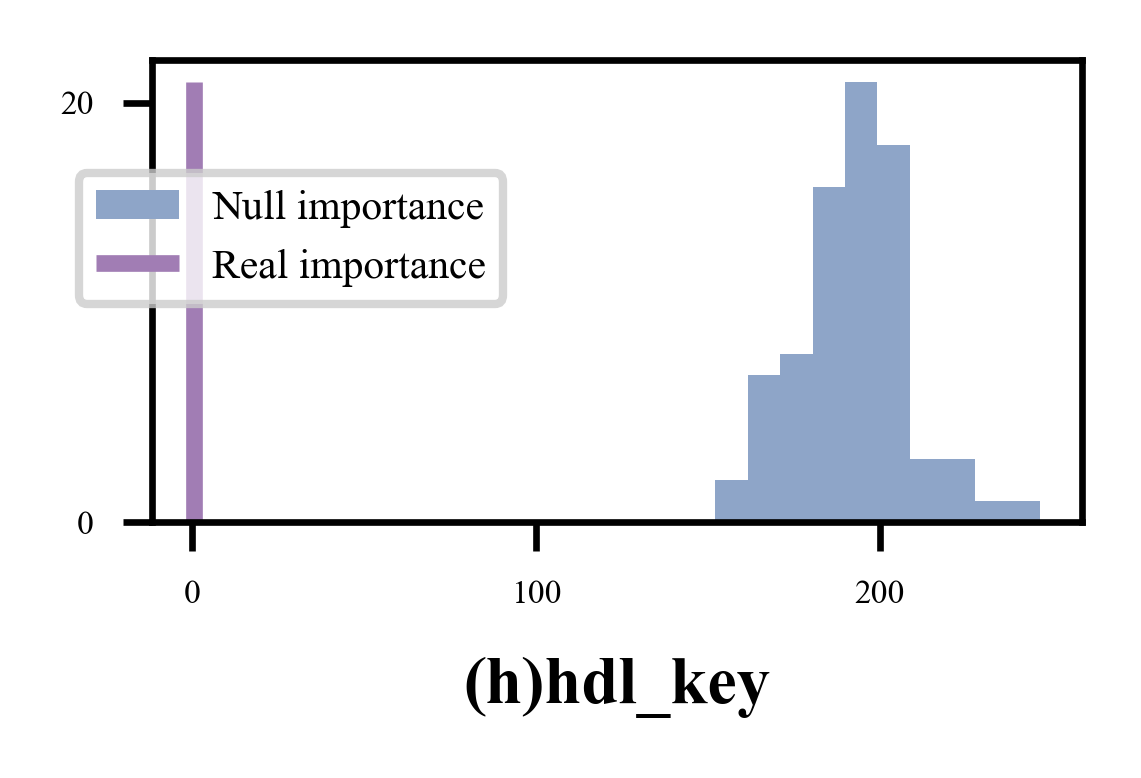

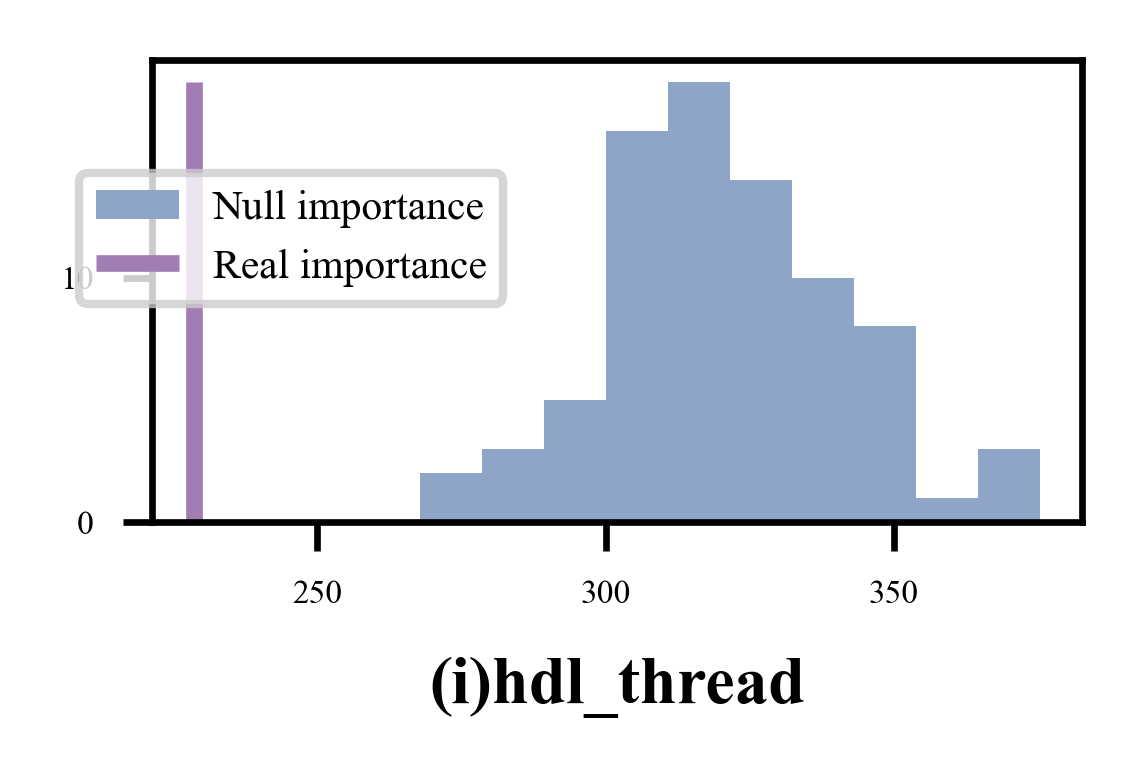

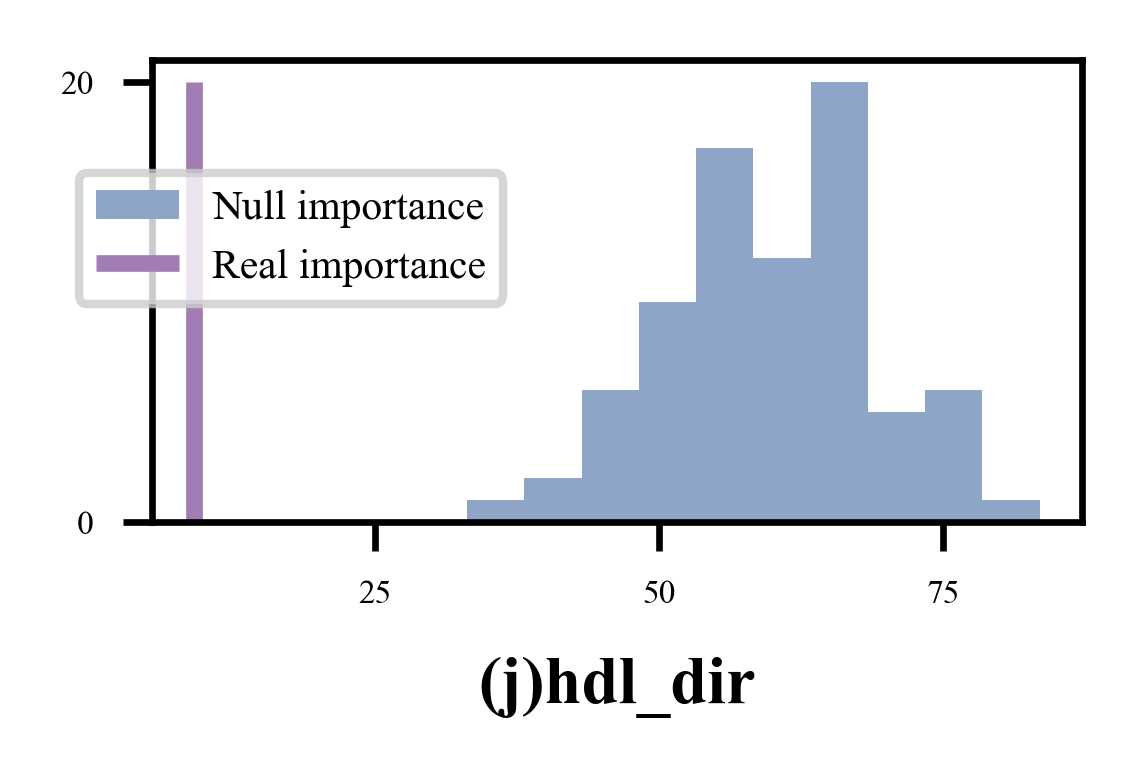

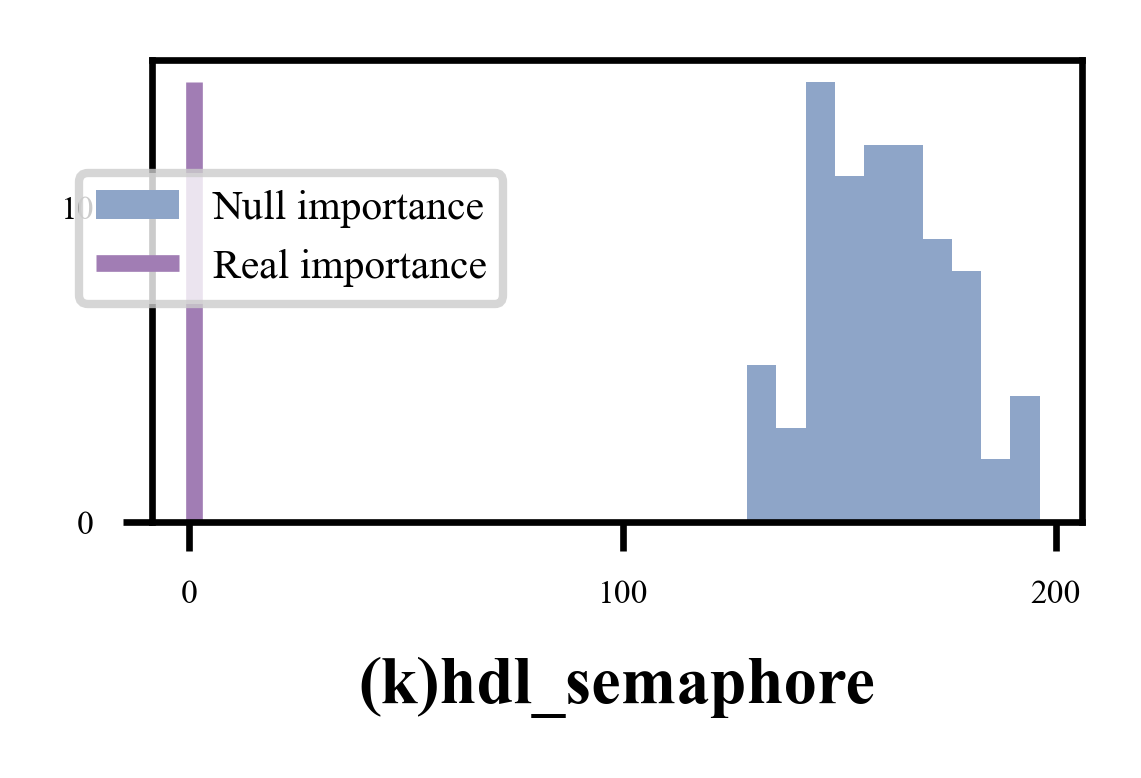

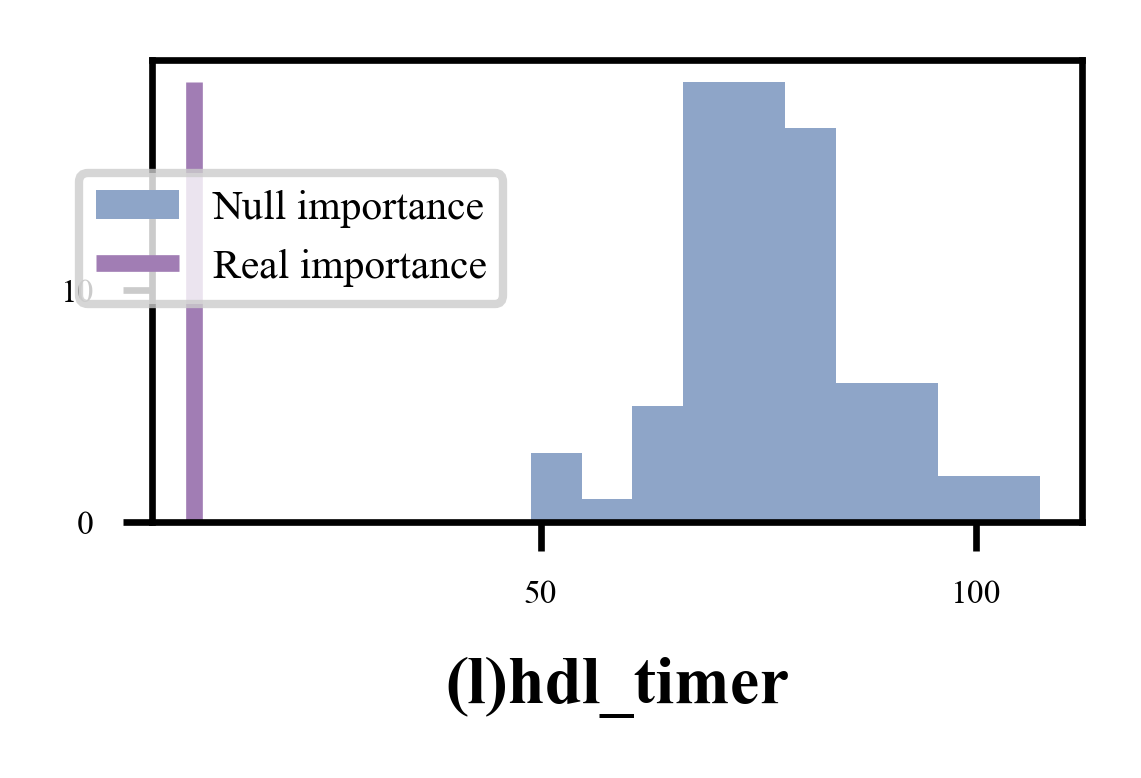

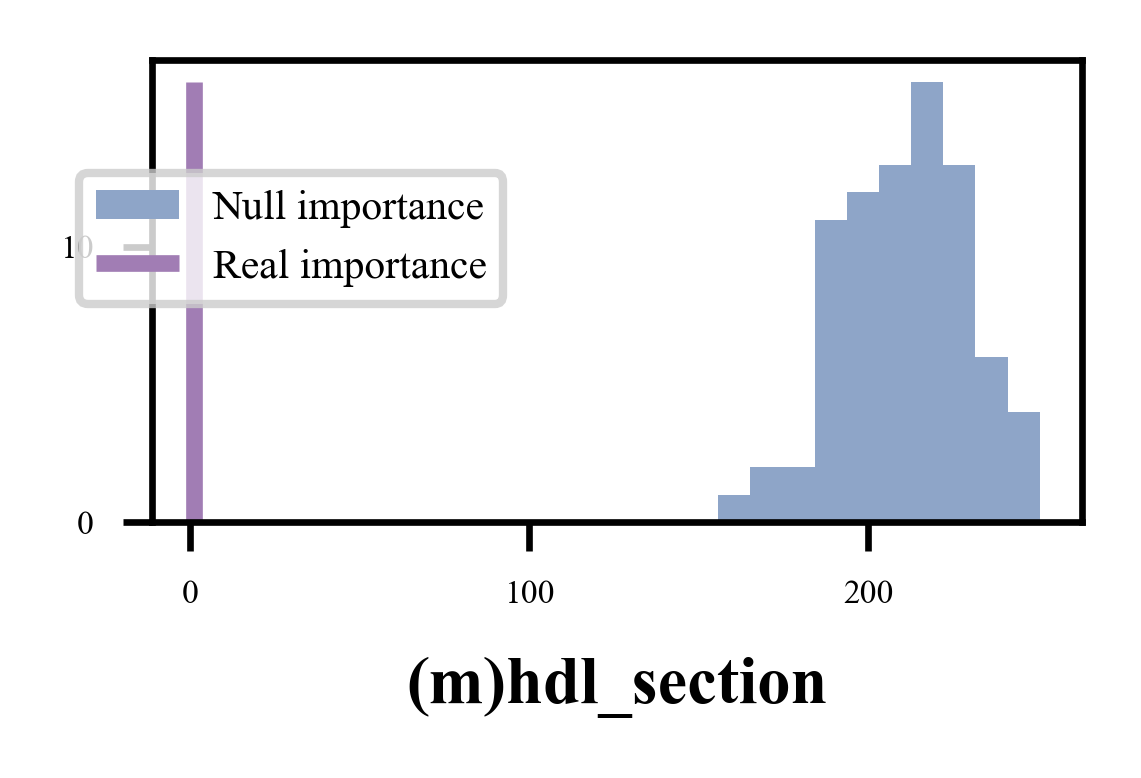

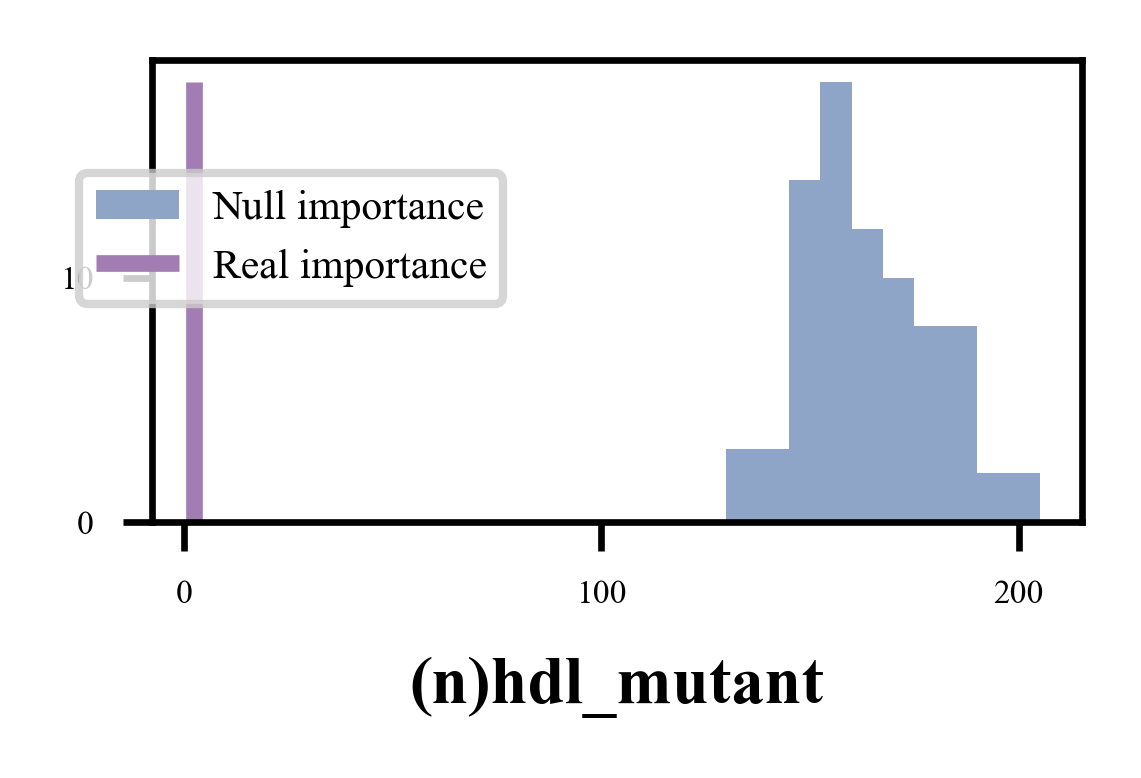

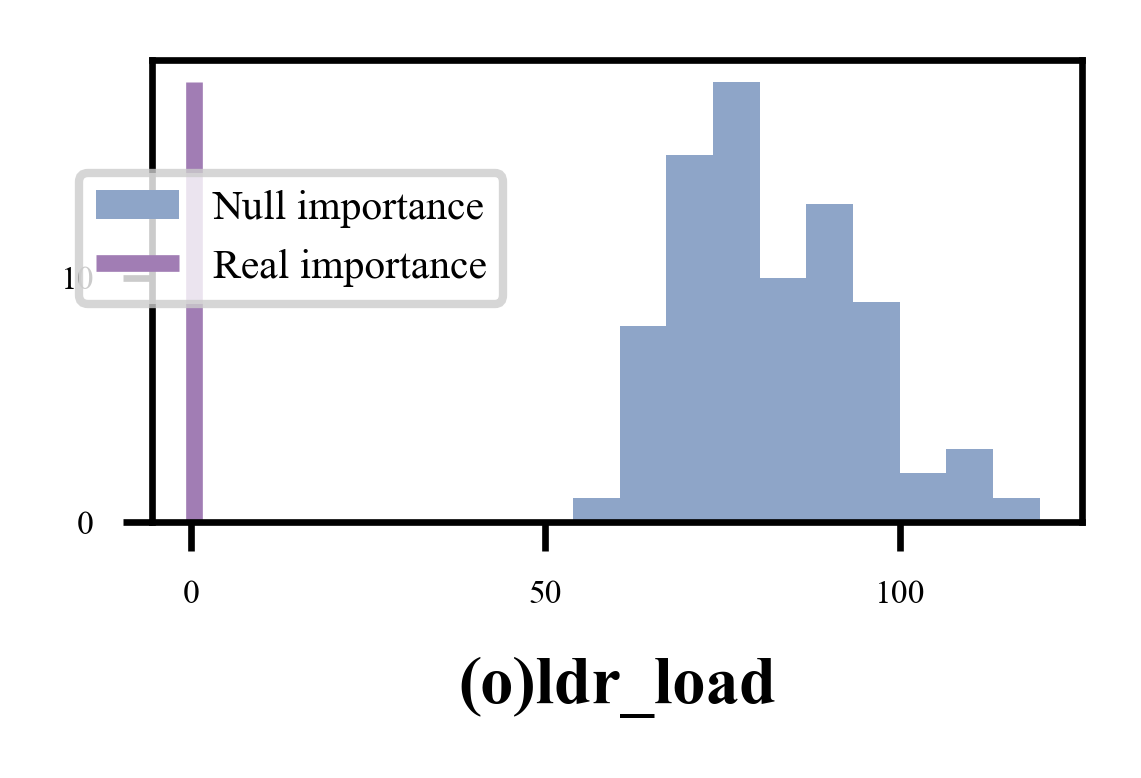

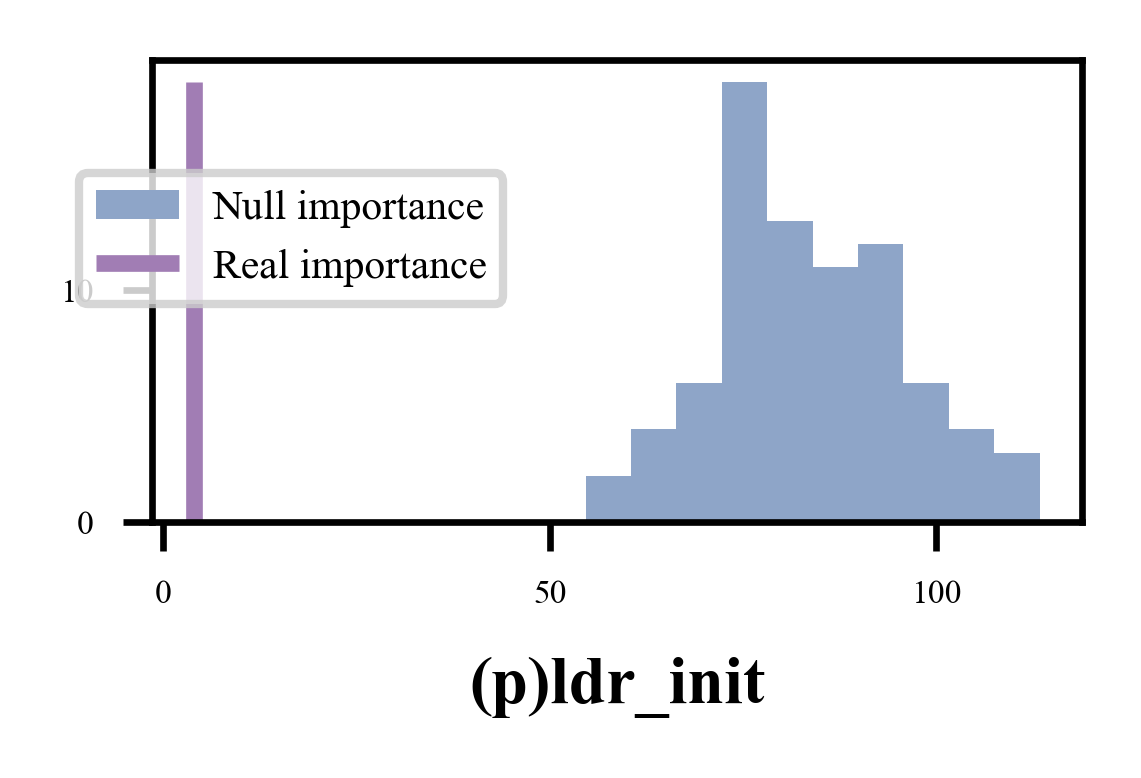

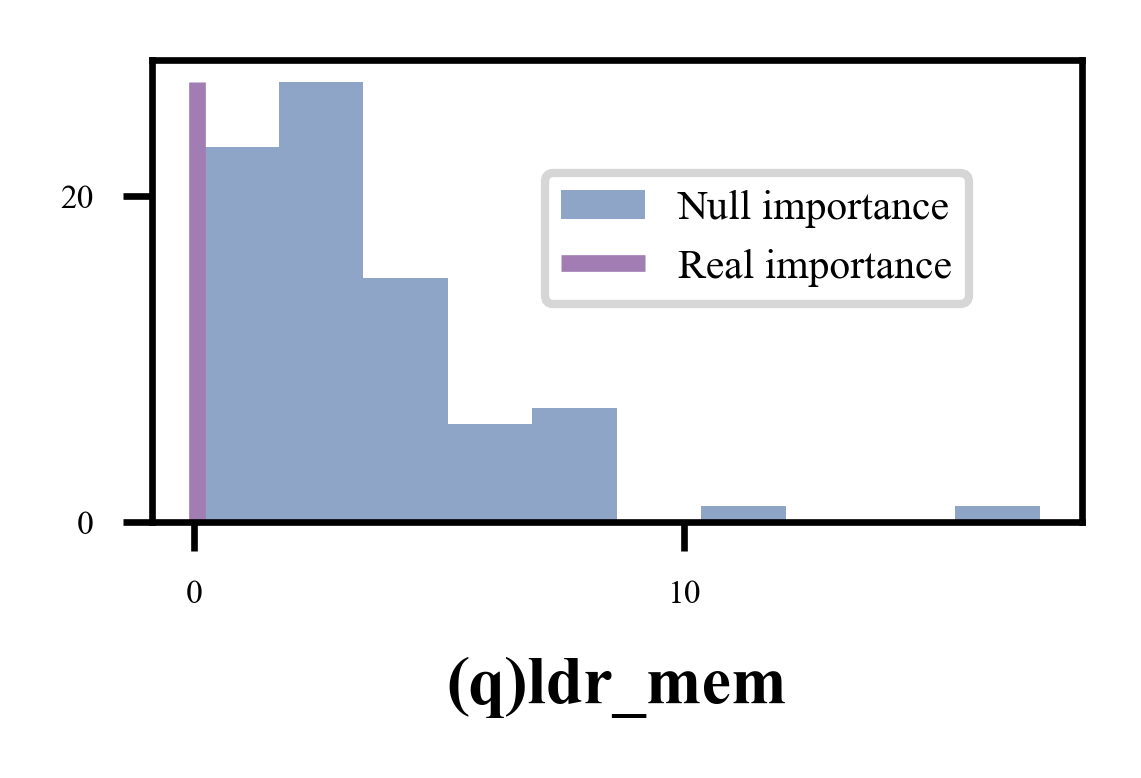

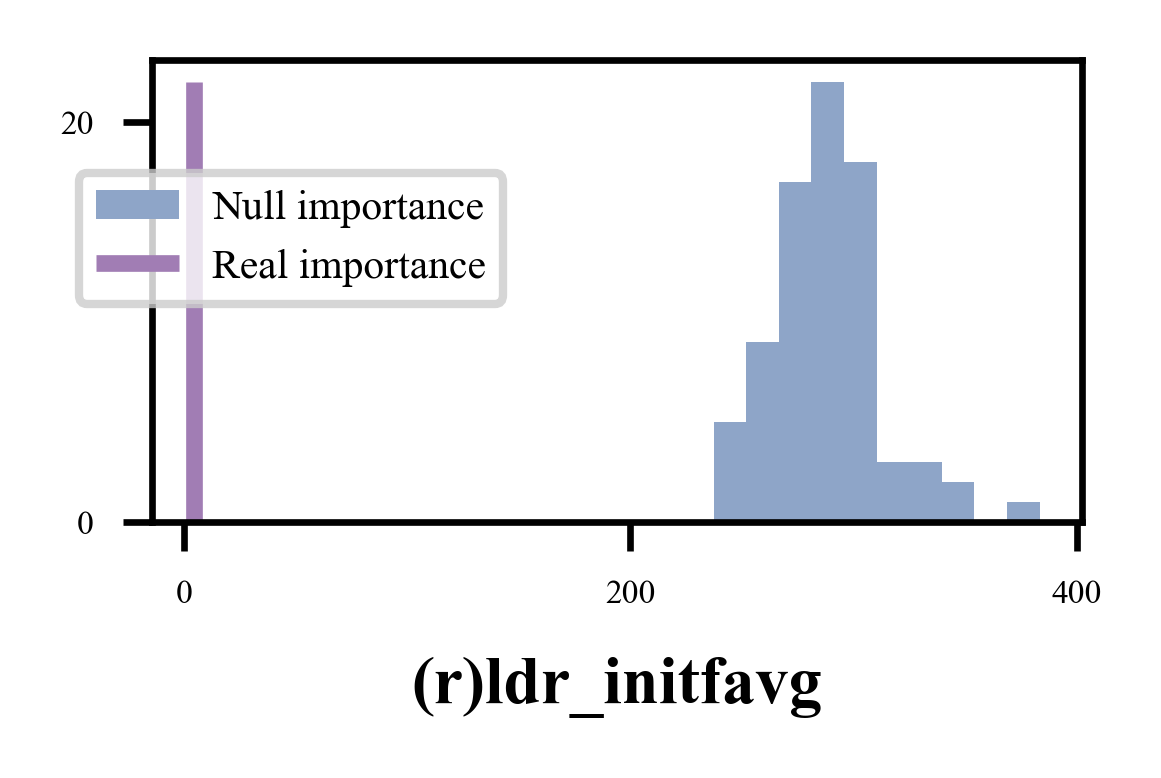

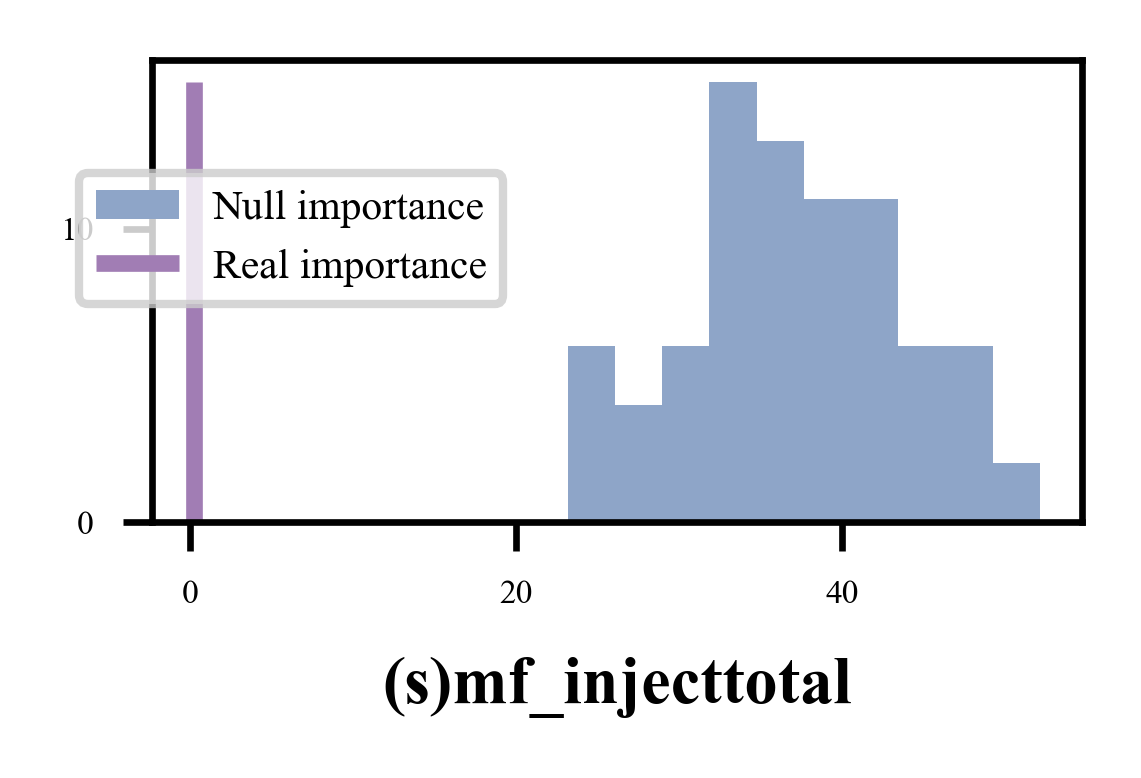

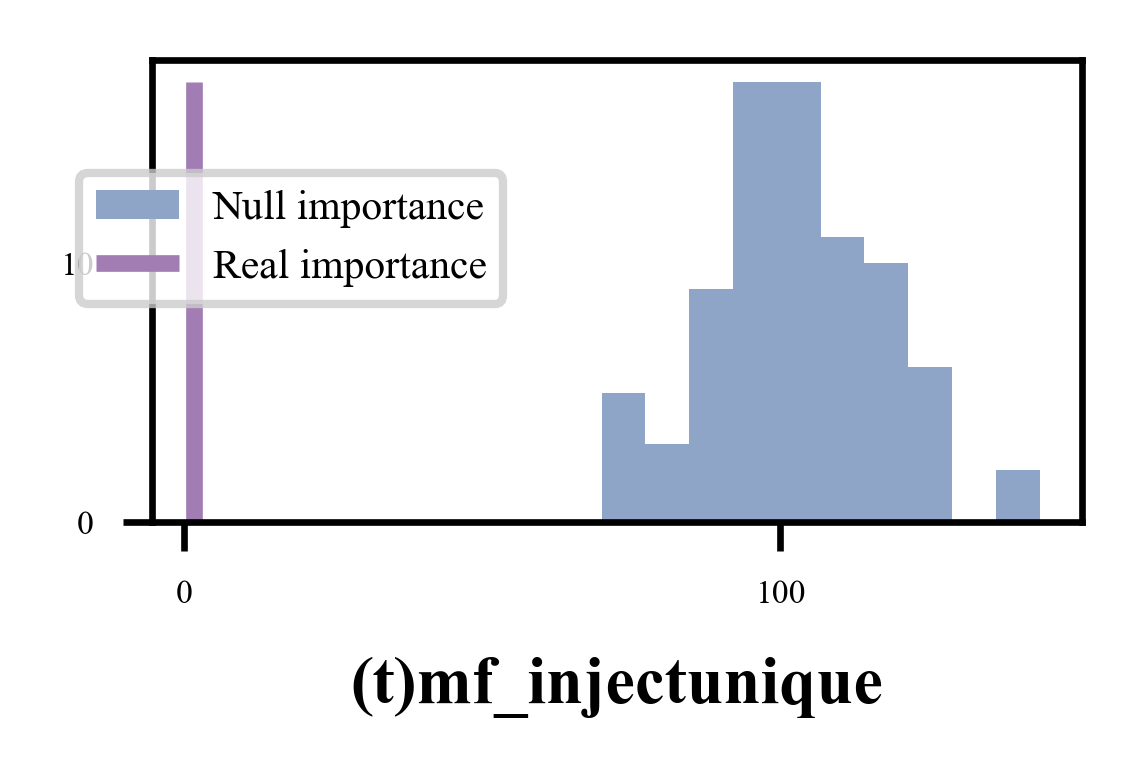

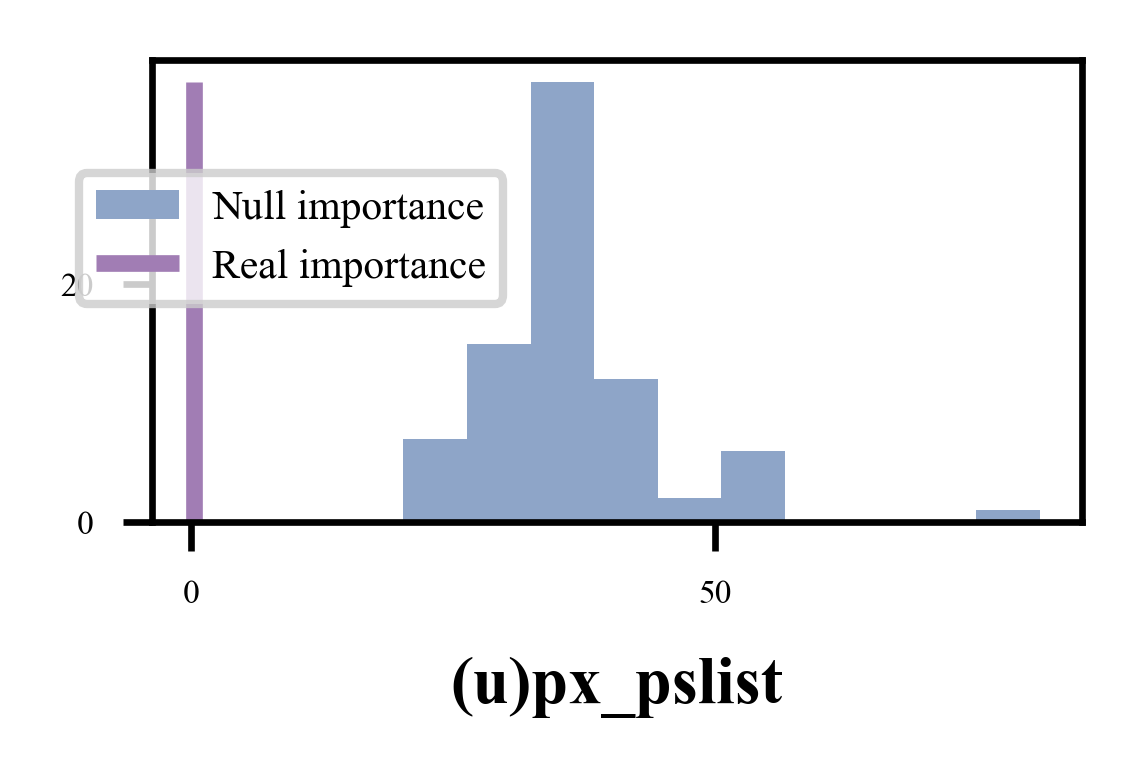

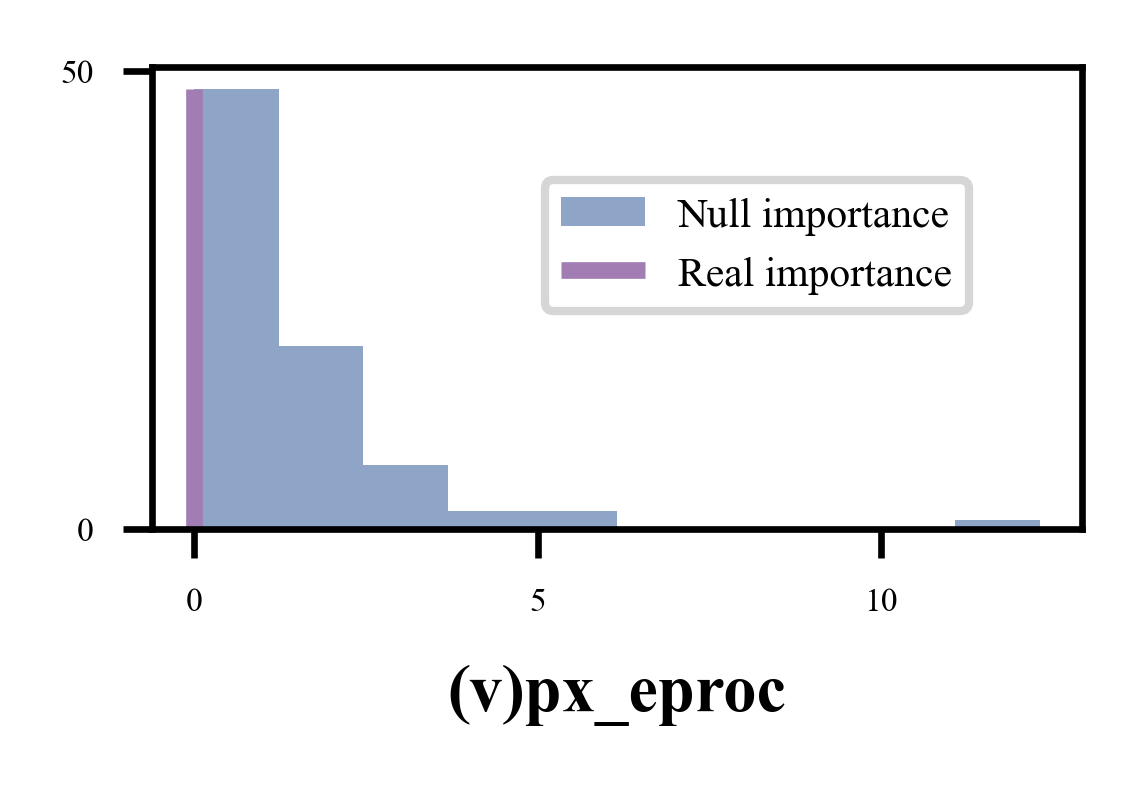

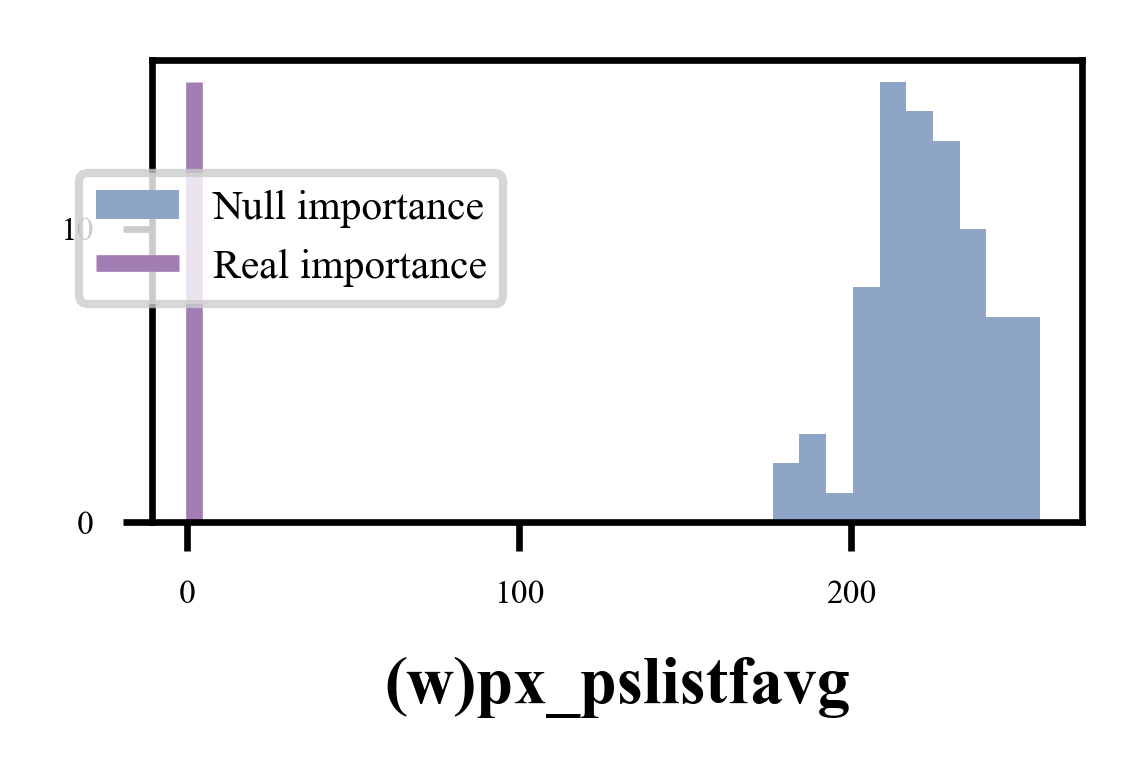

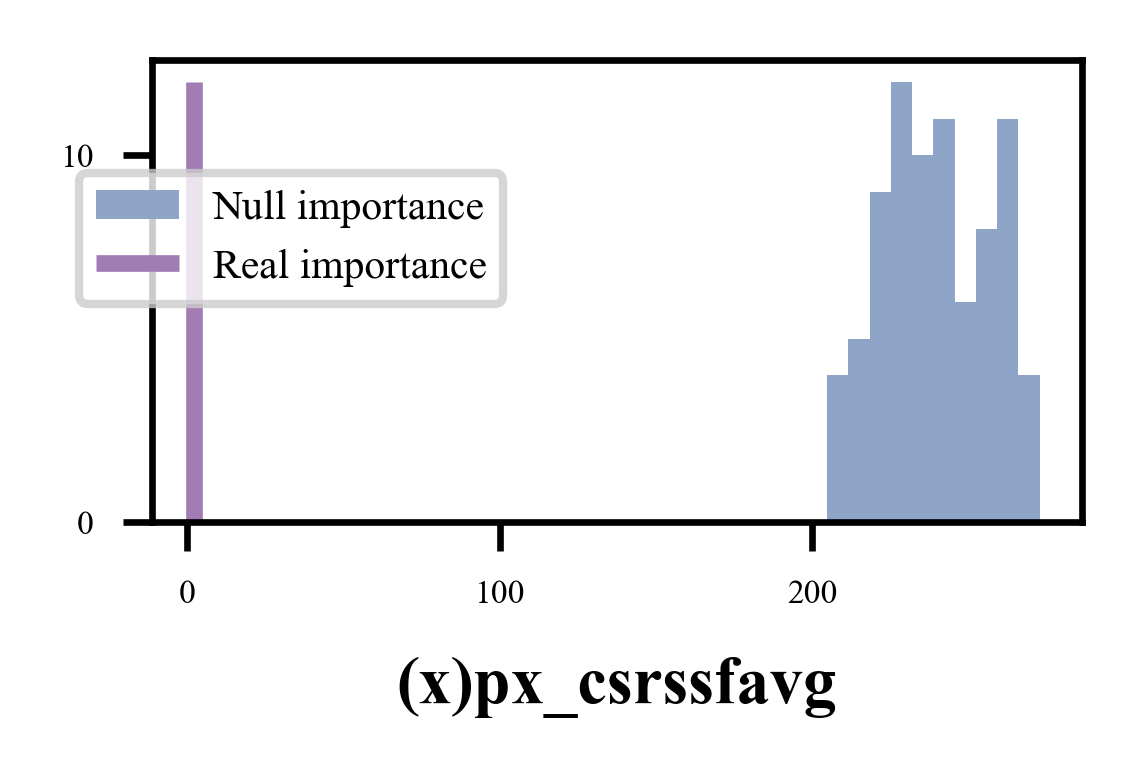

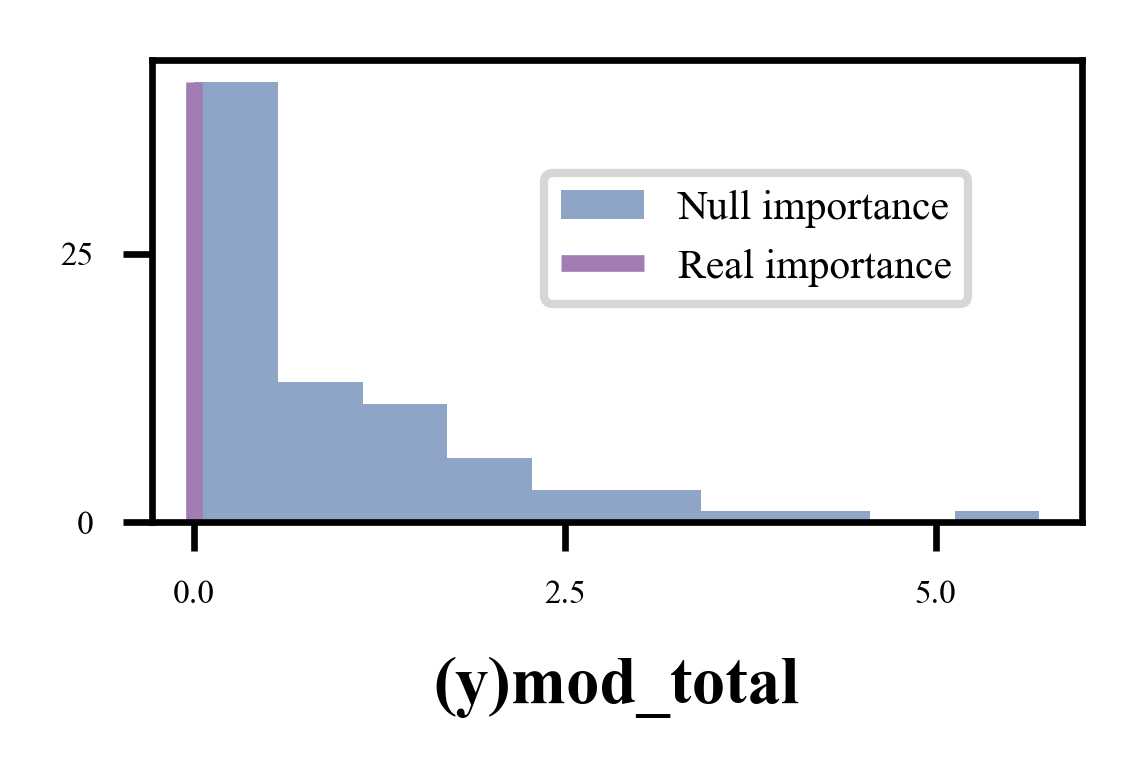

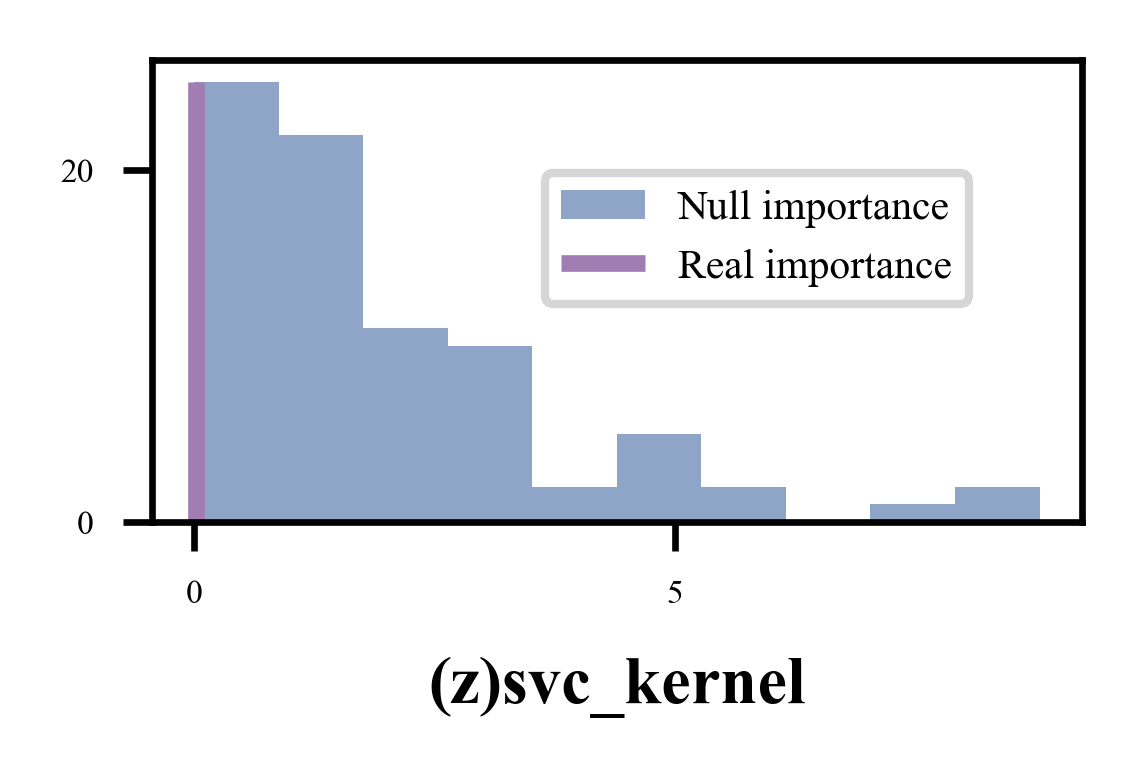

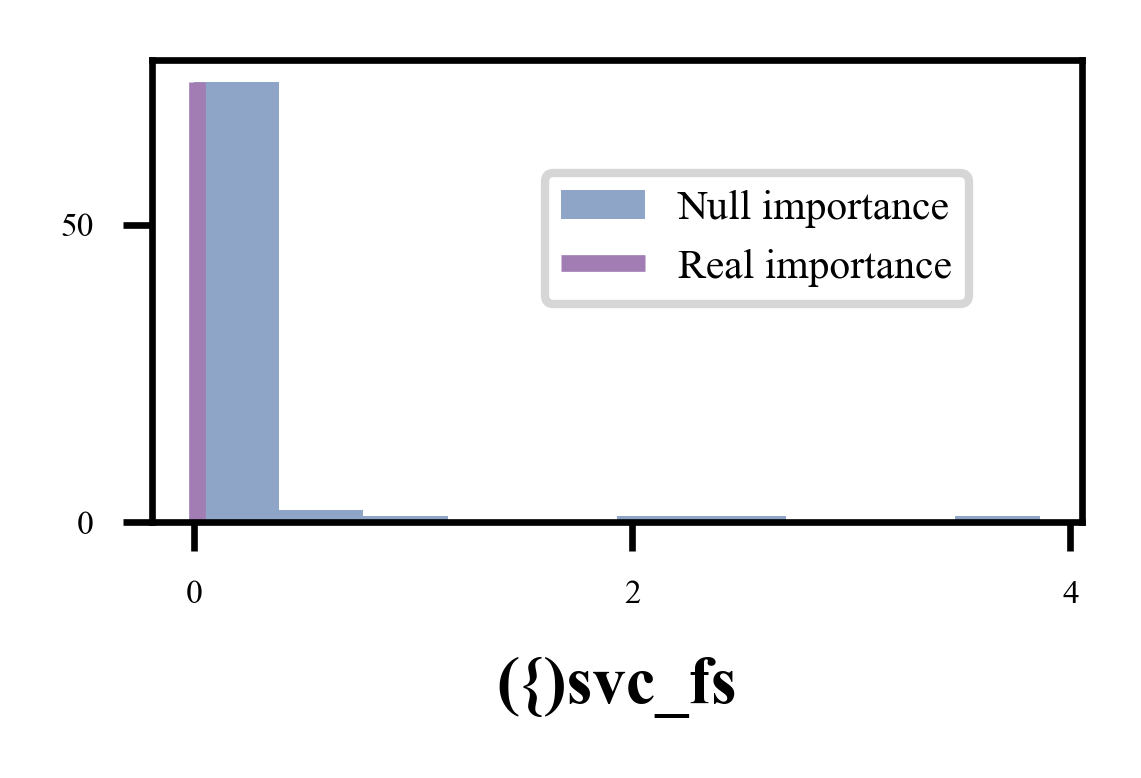

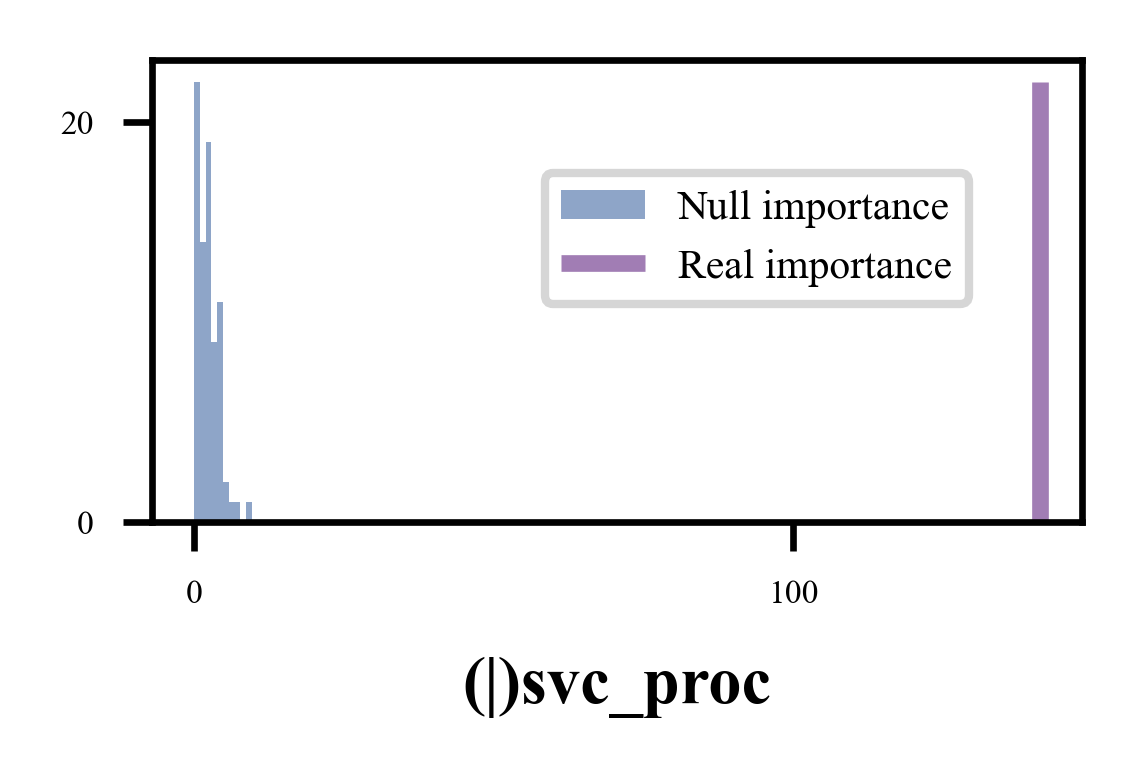

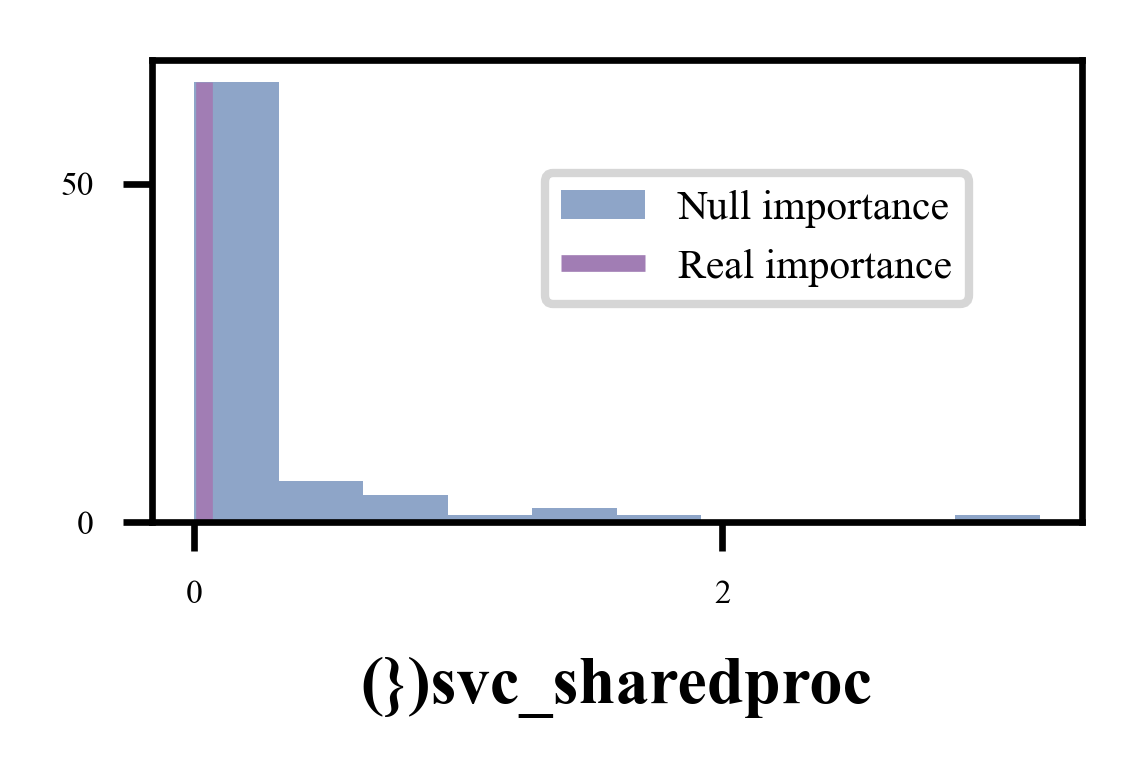

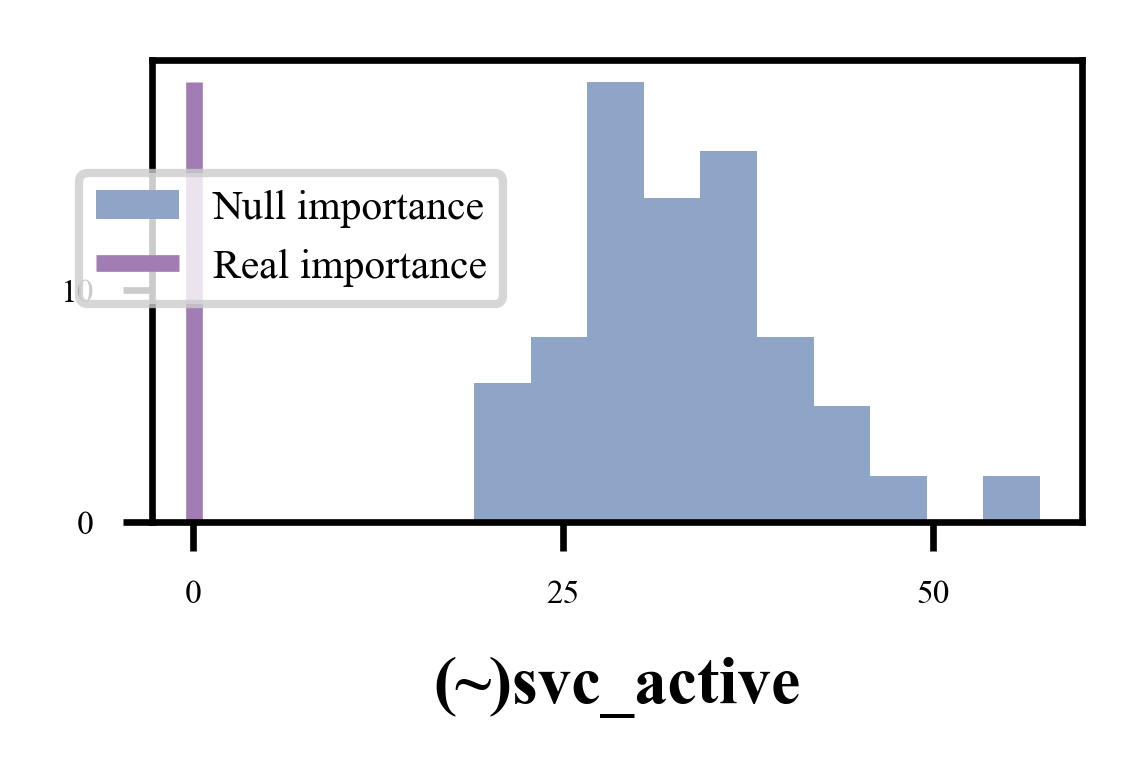

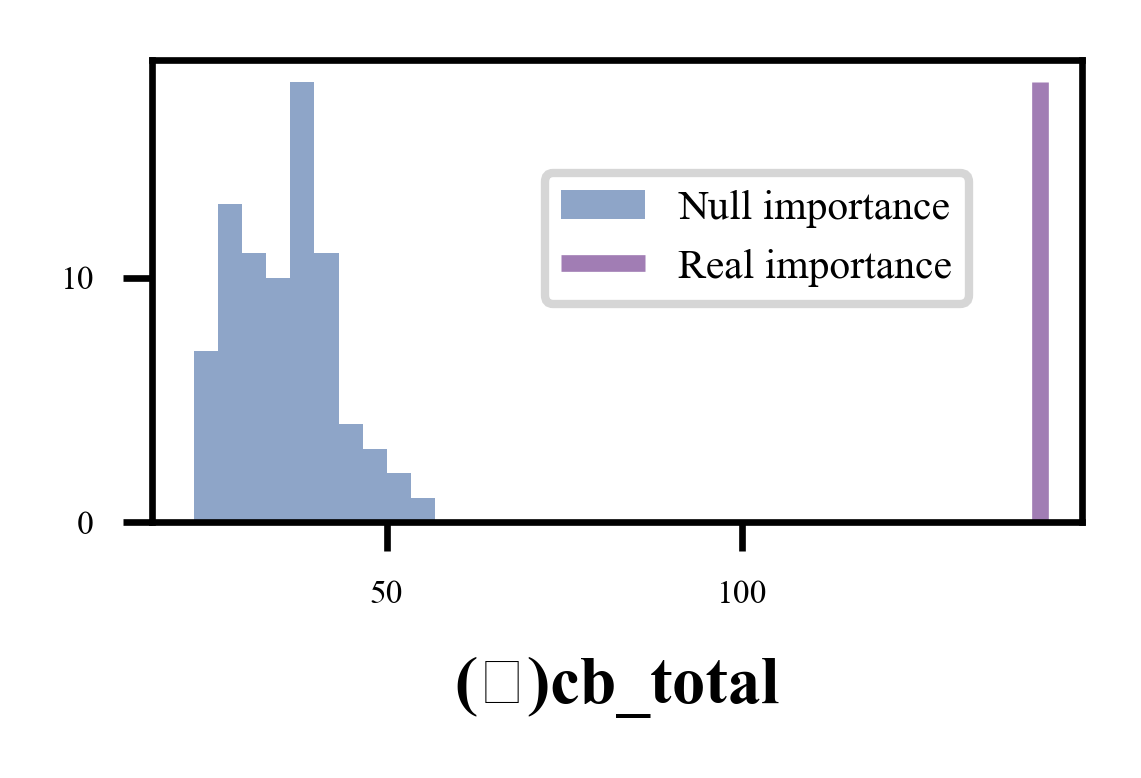

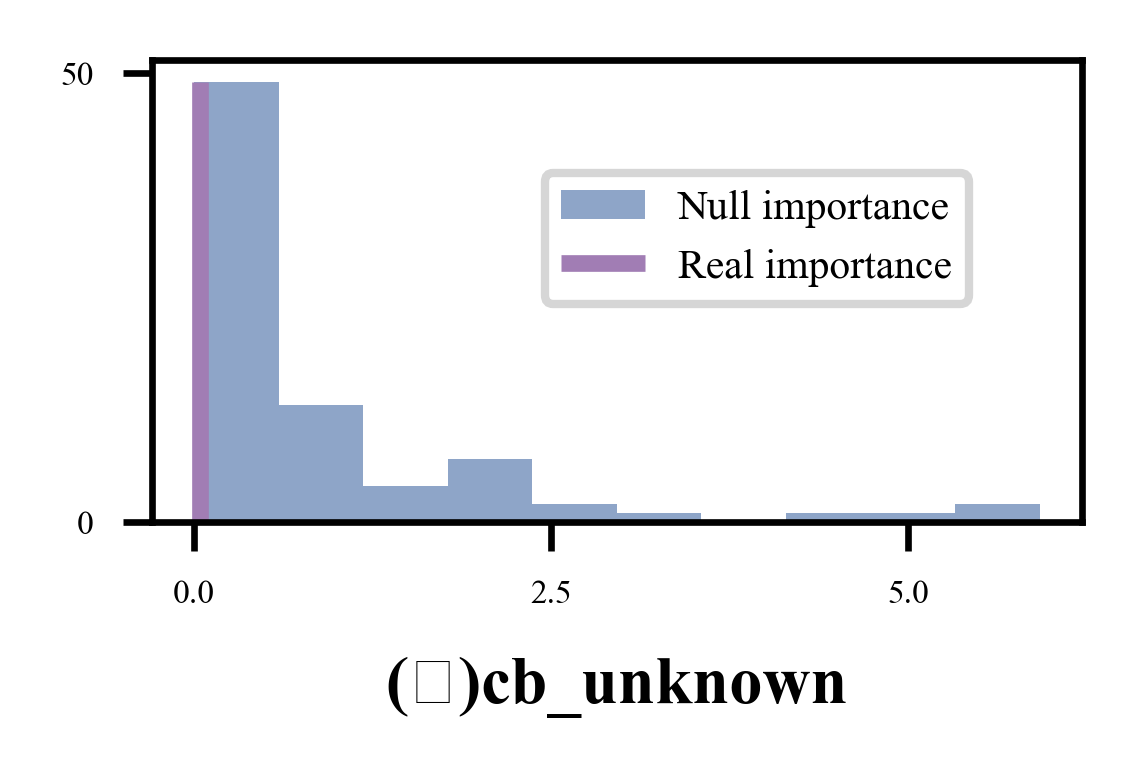

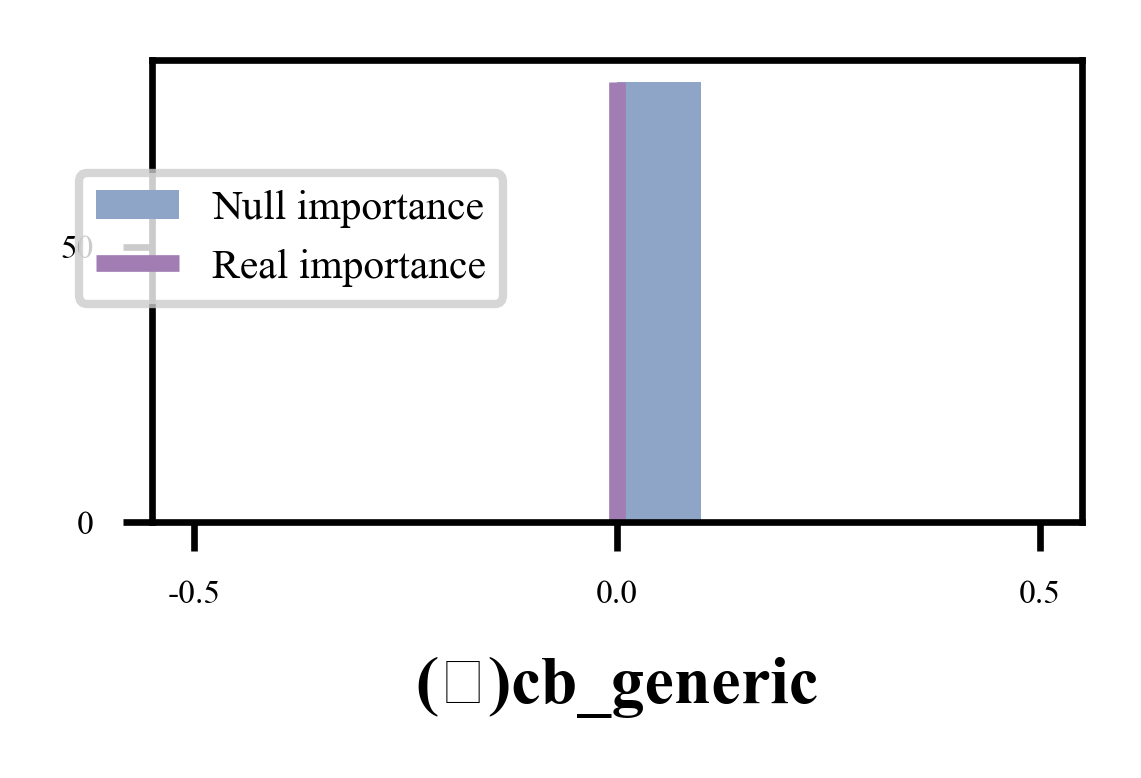

In [19]:
gain_polt_imp(null_imp_df, pd.DataFrame(actual_imp_df), num_feats)

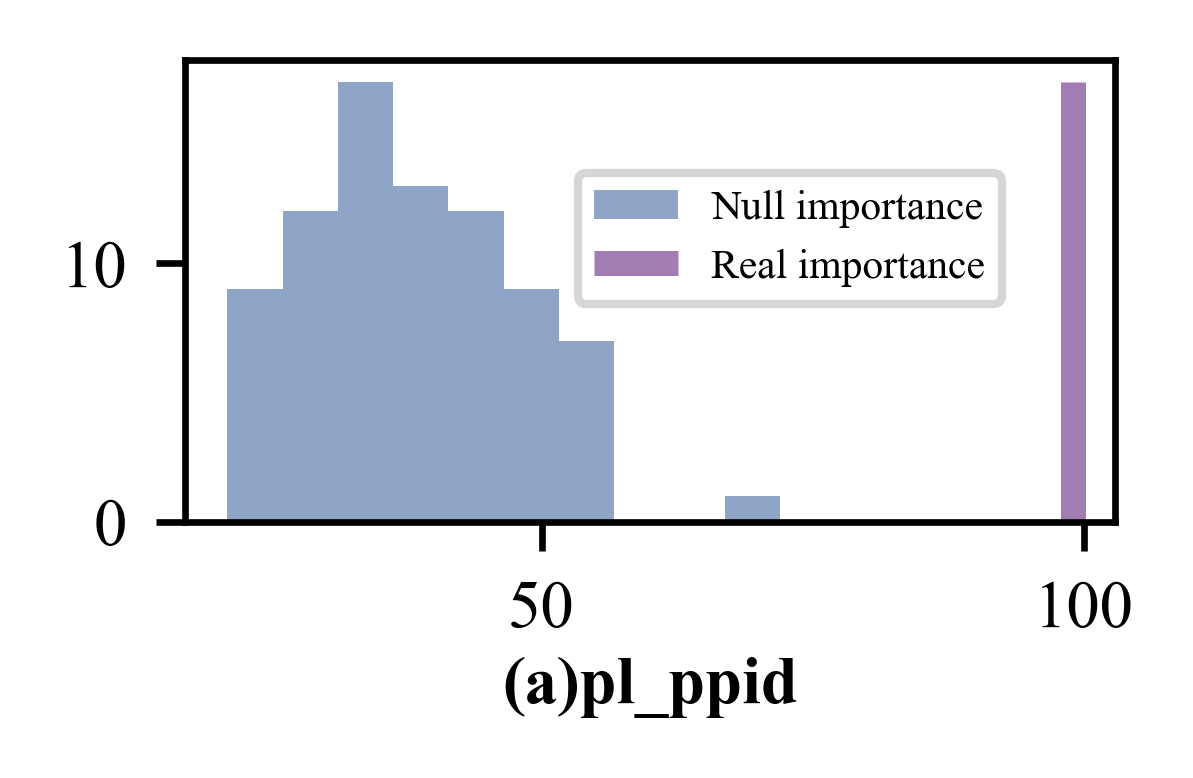

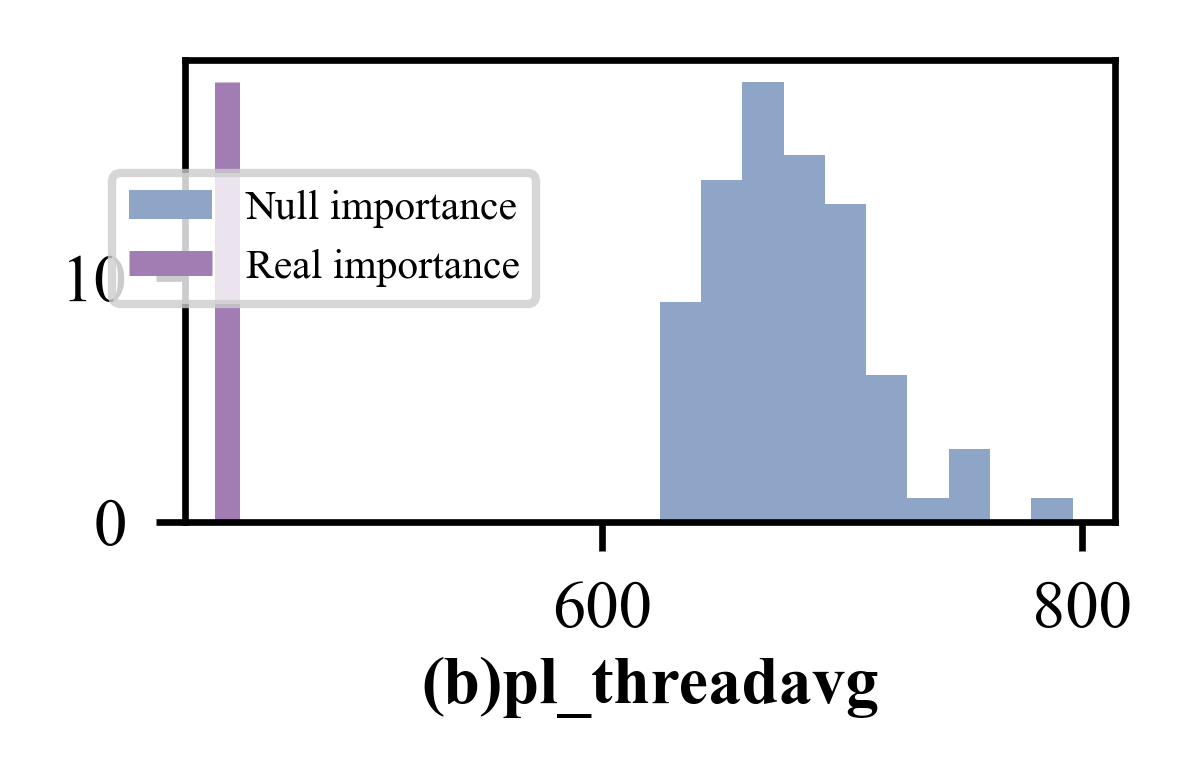

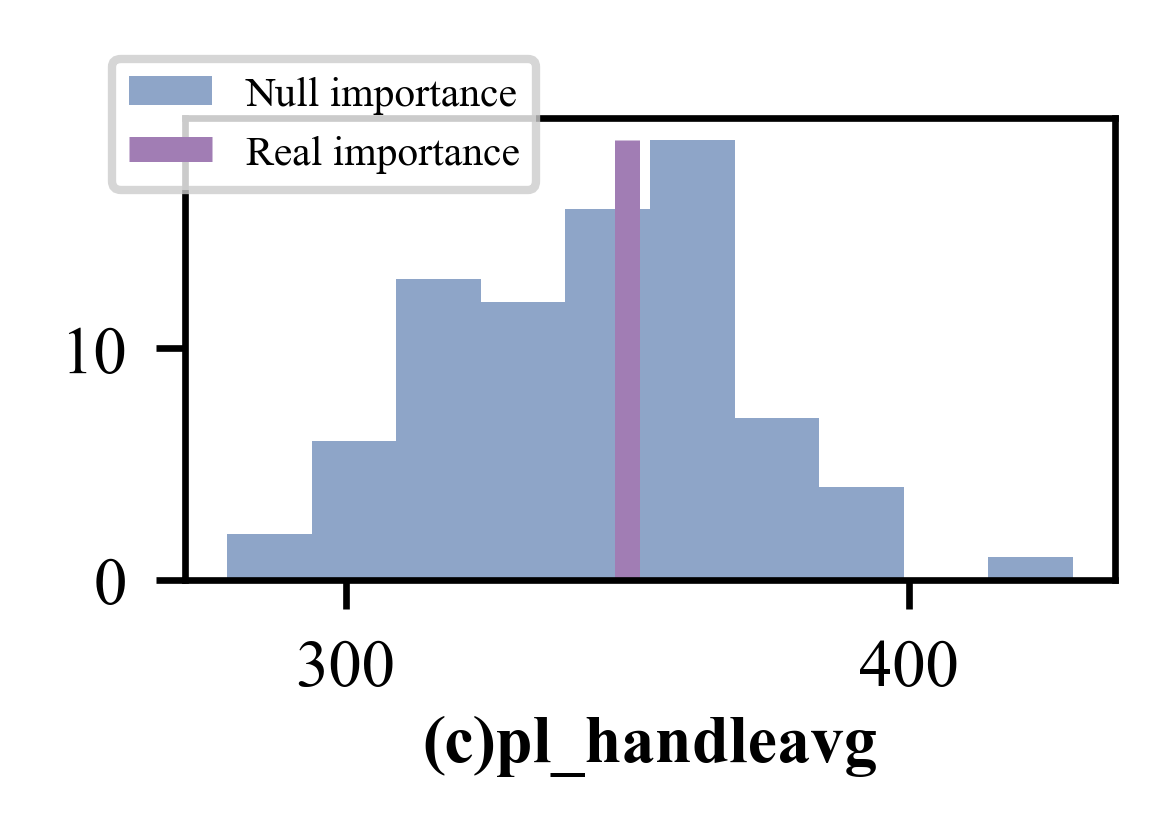

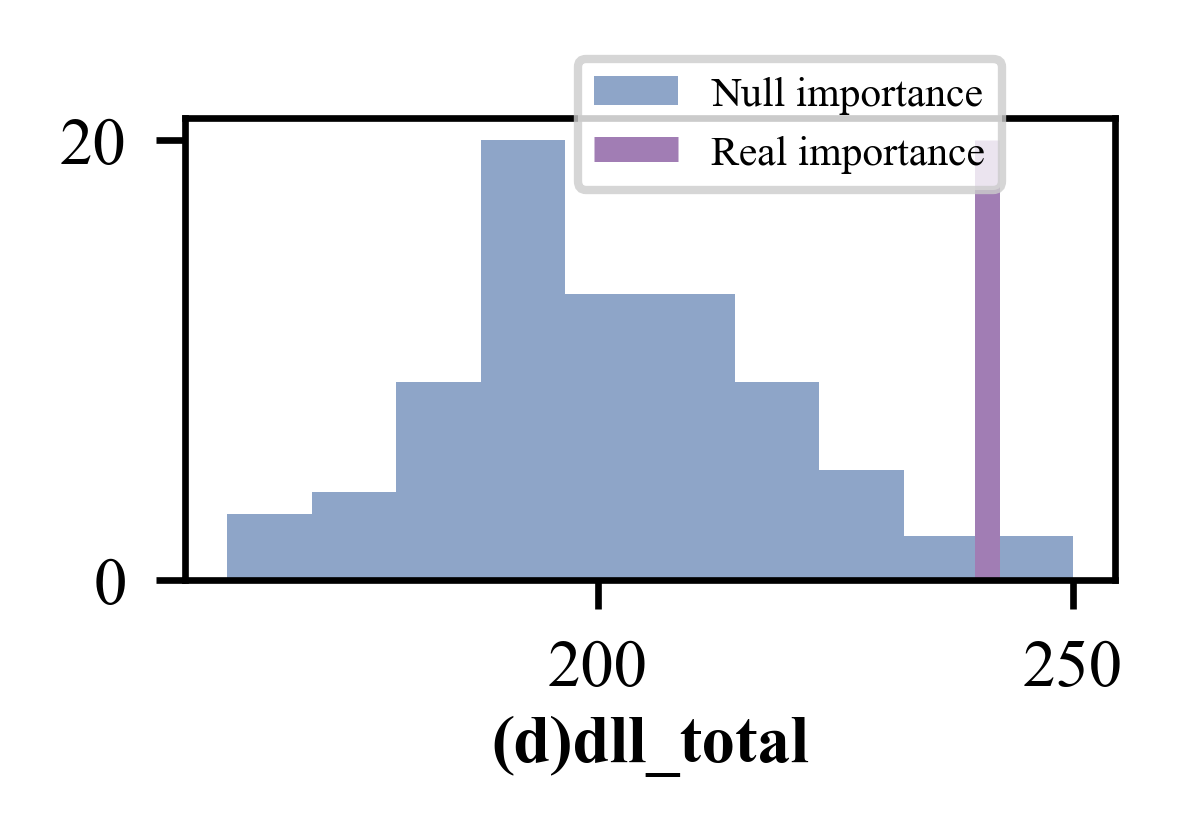

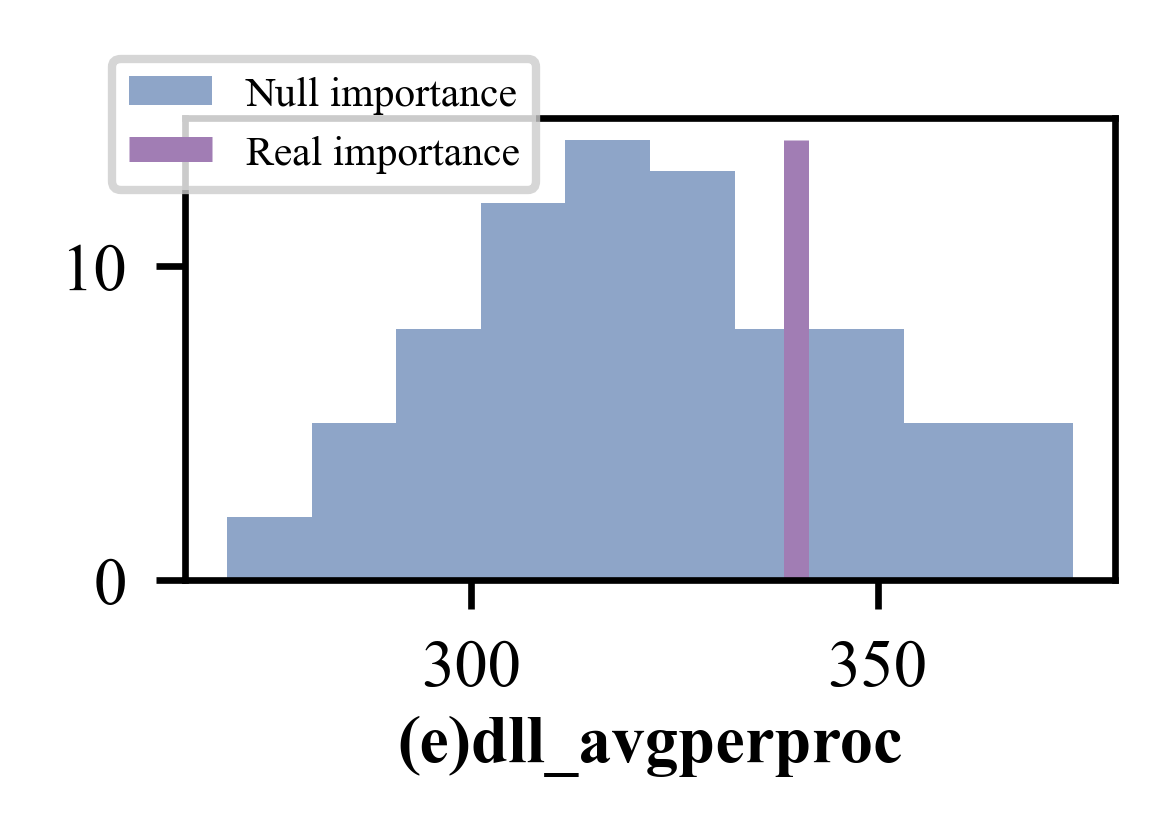

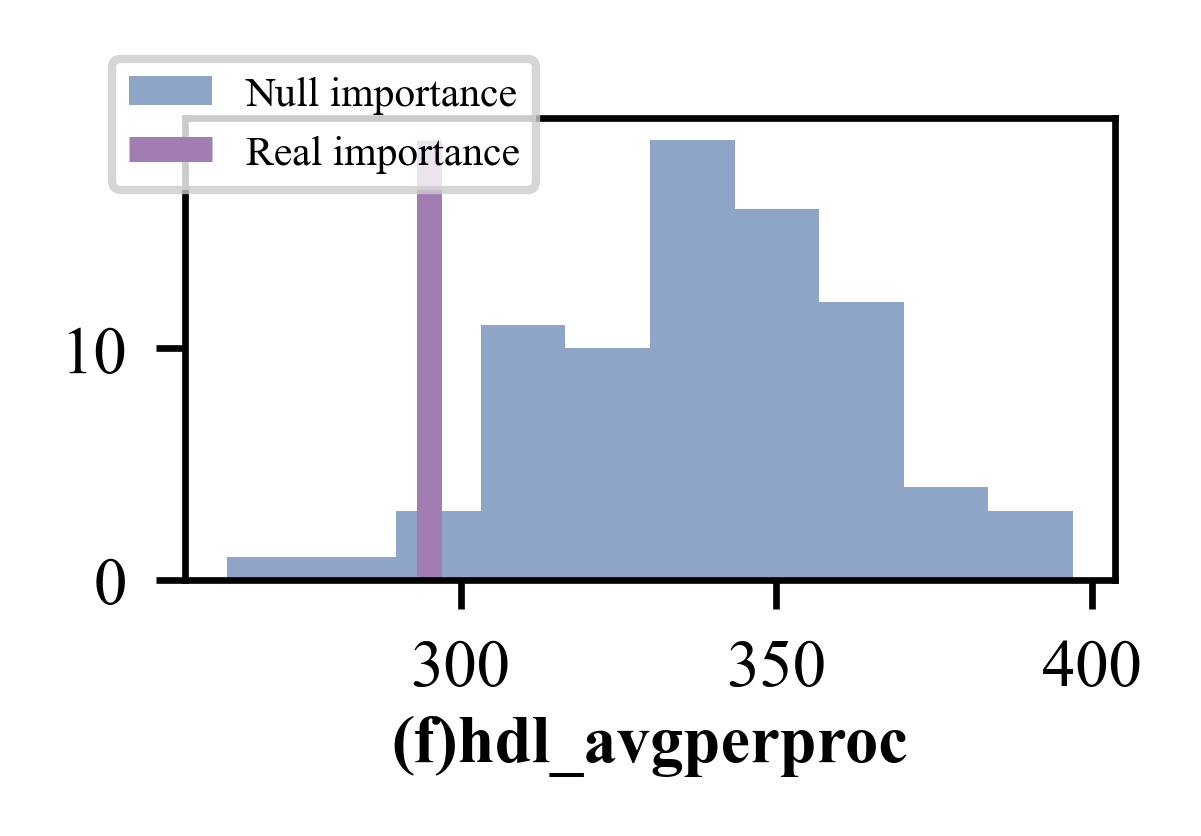

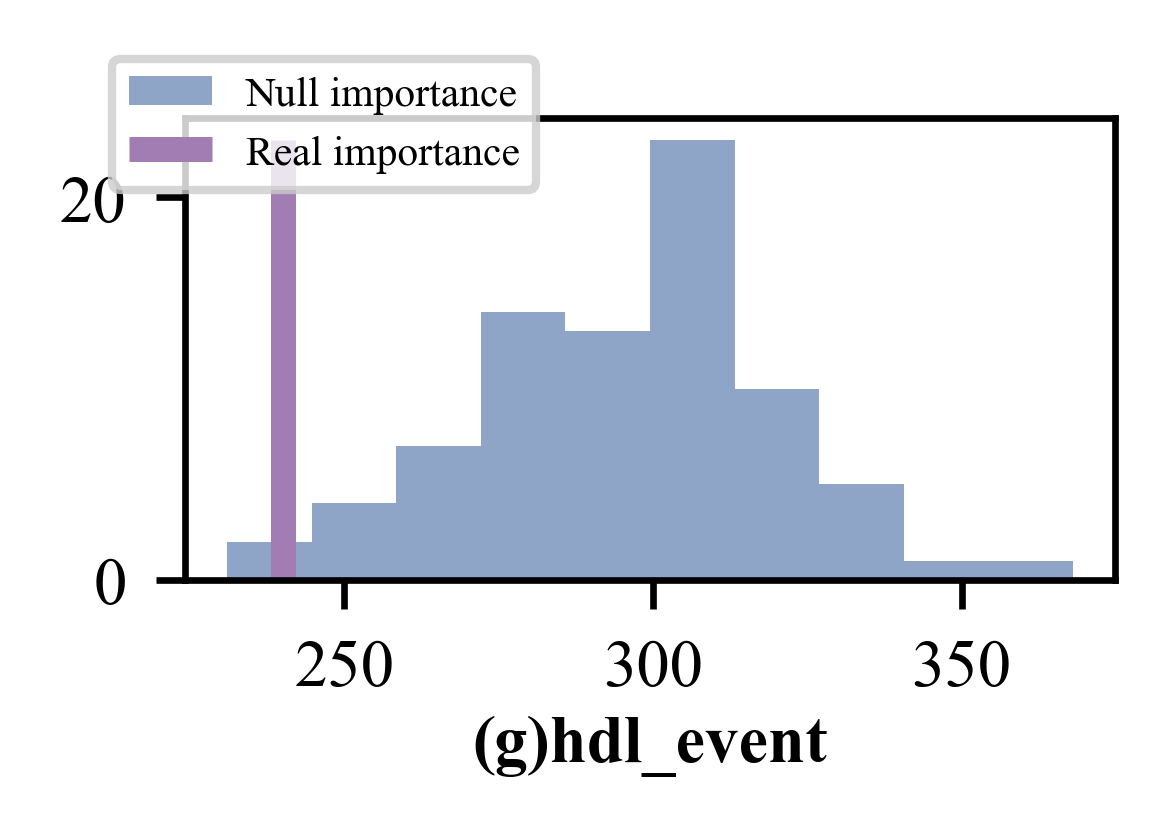

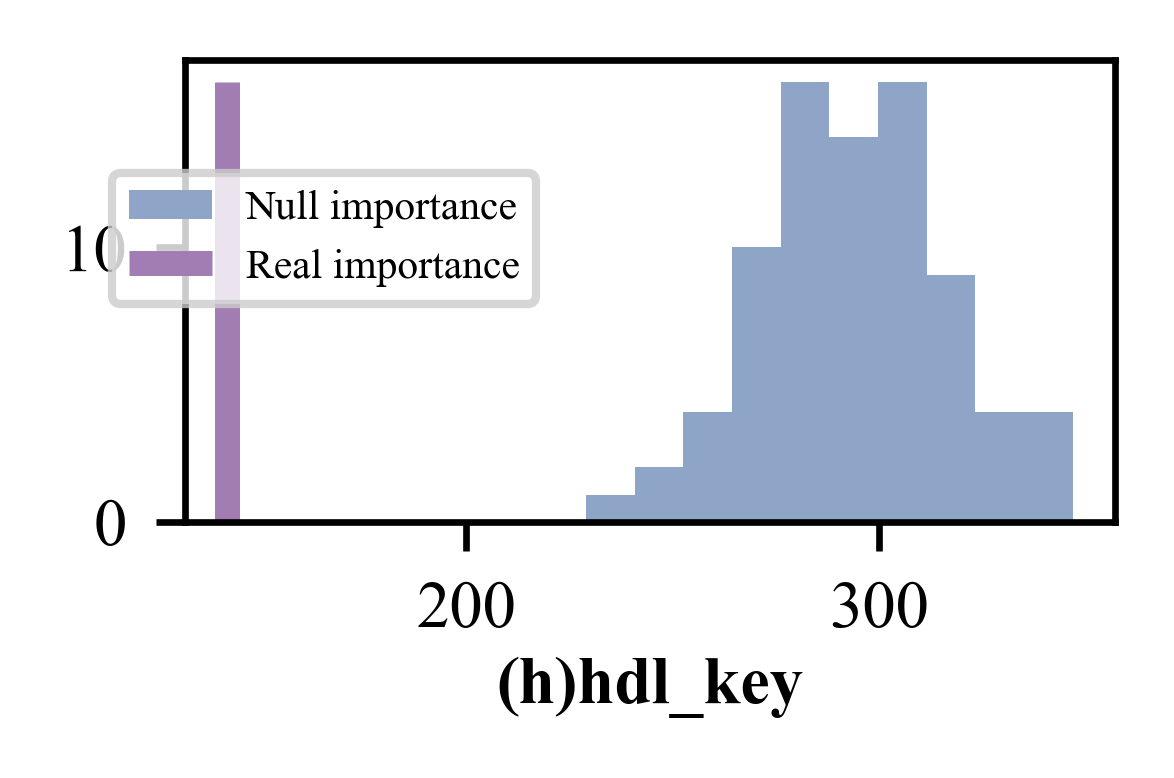

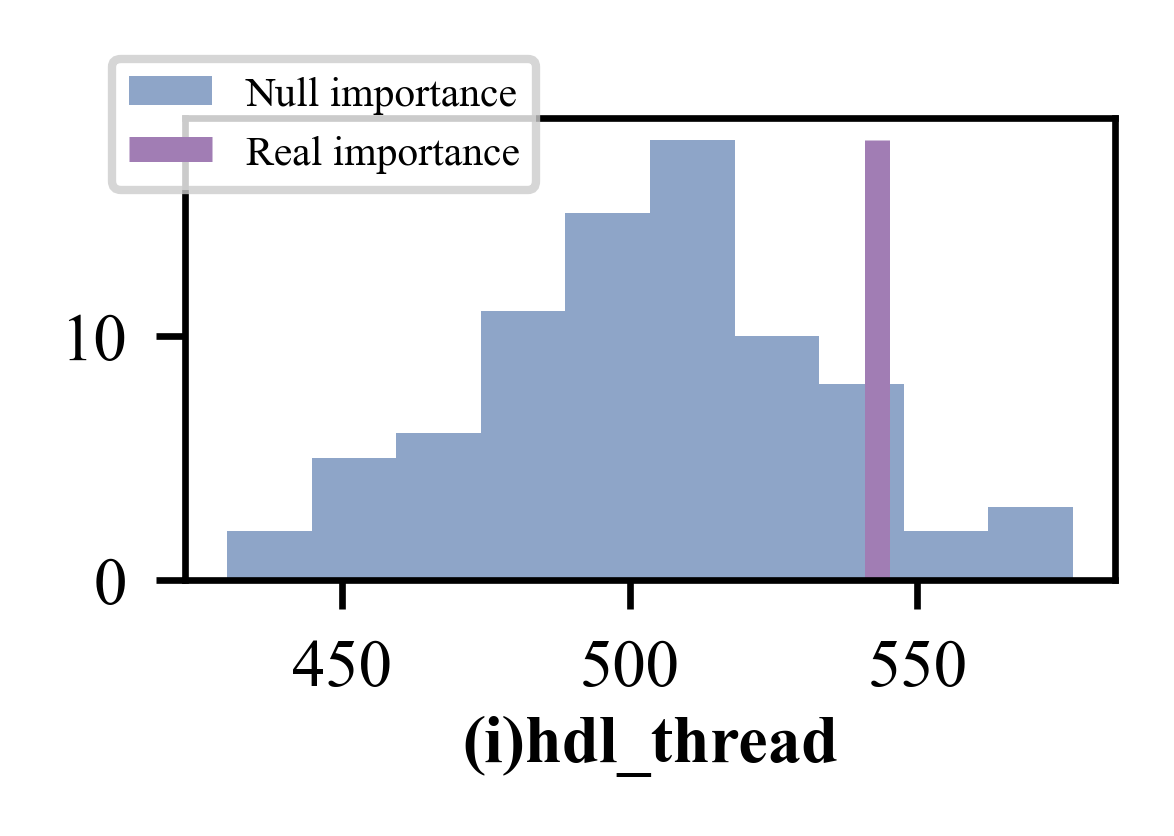

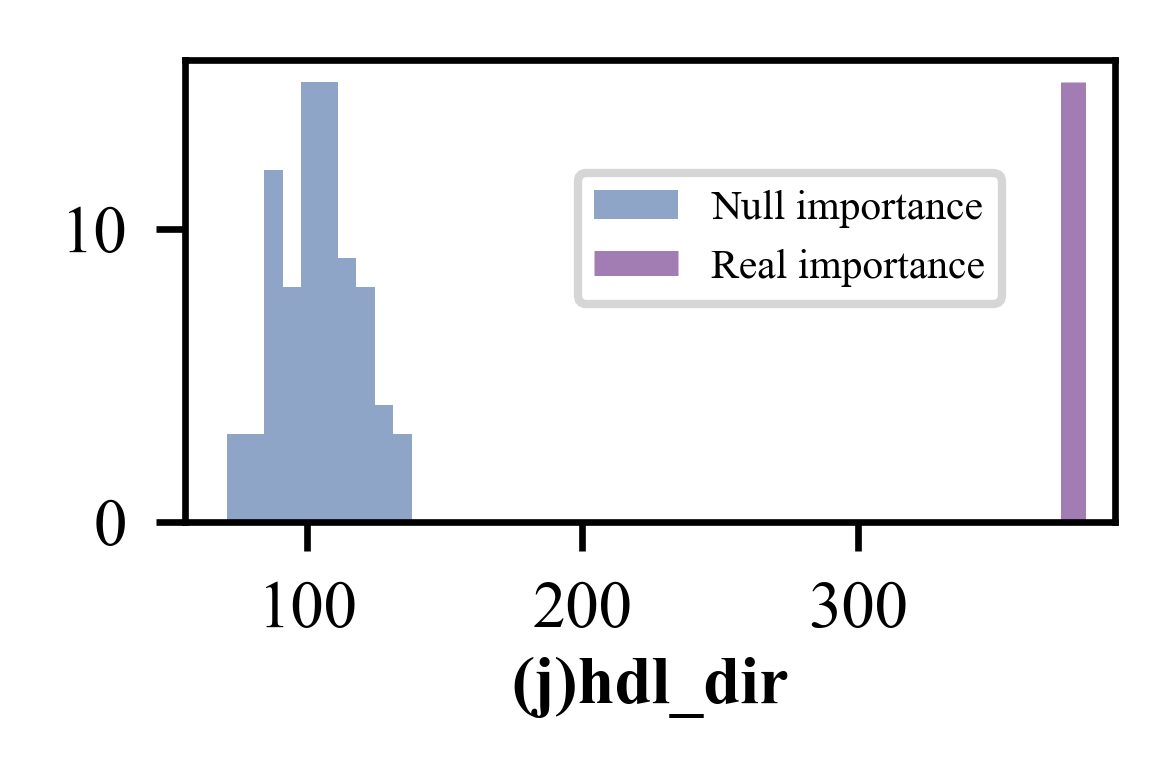

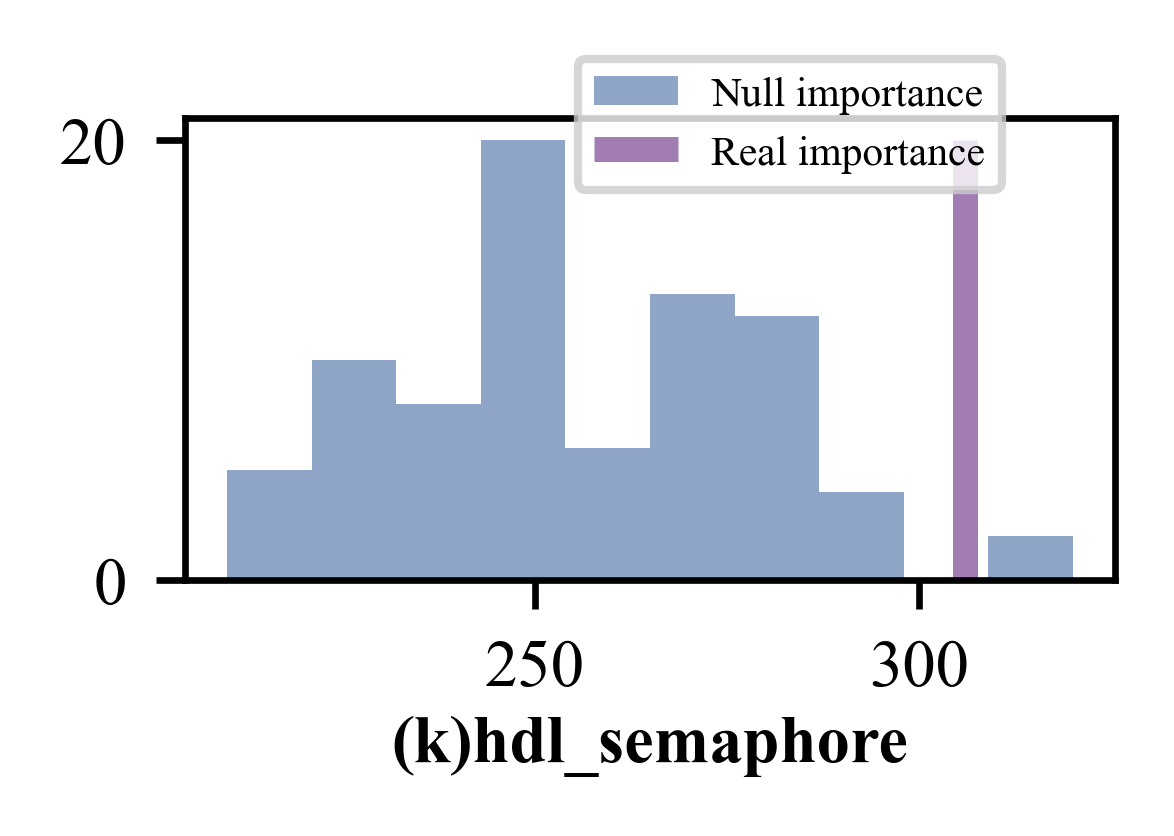

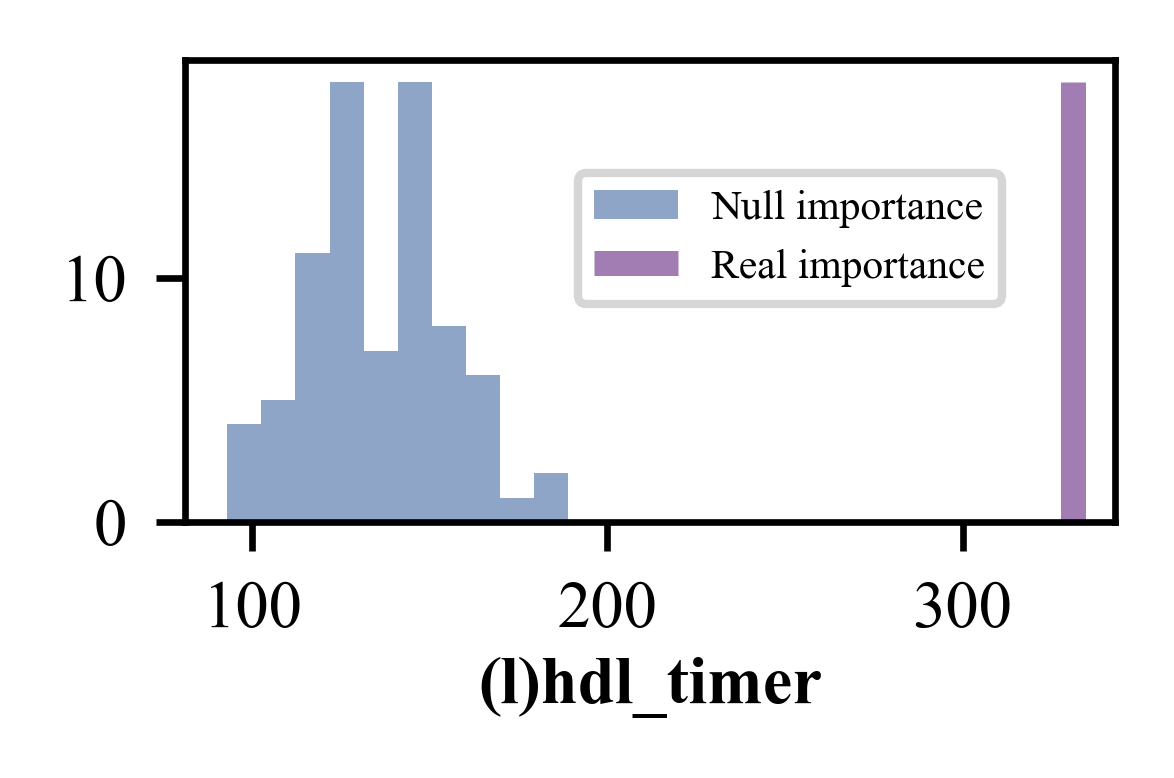

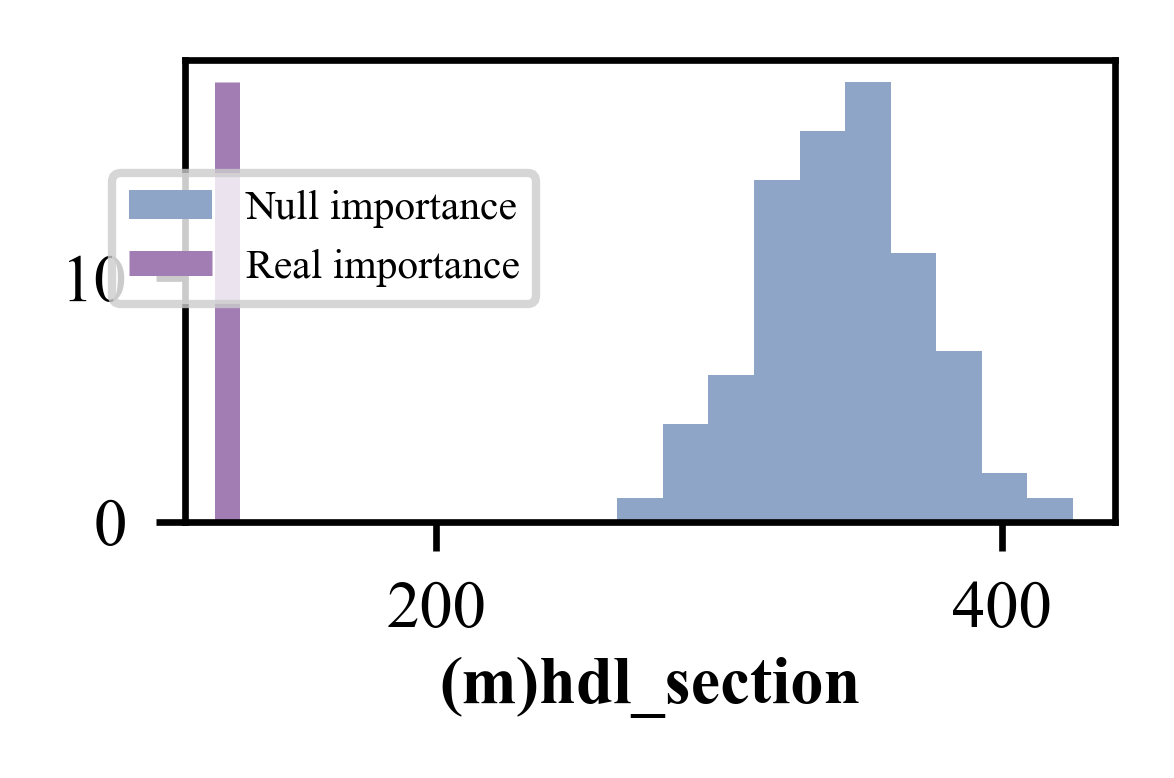

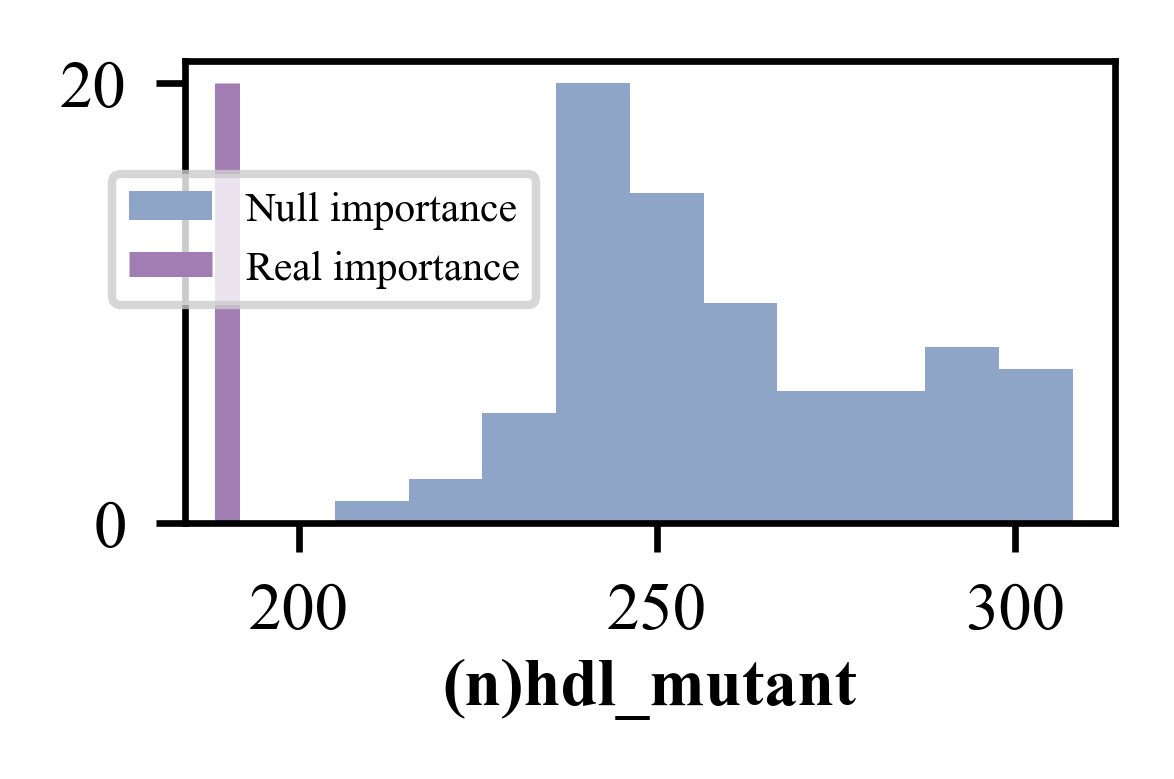

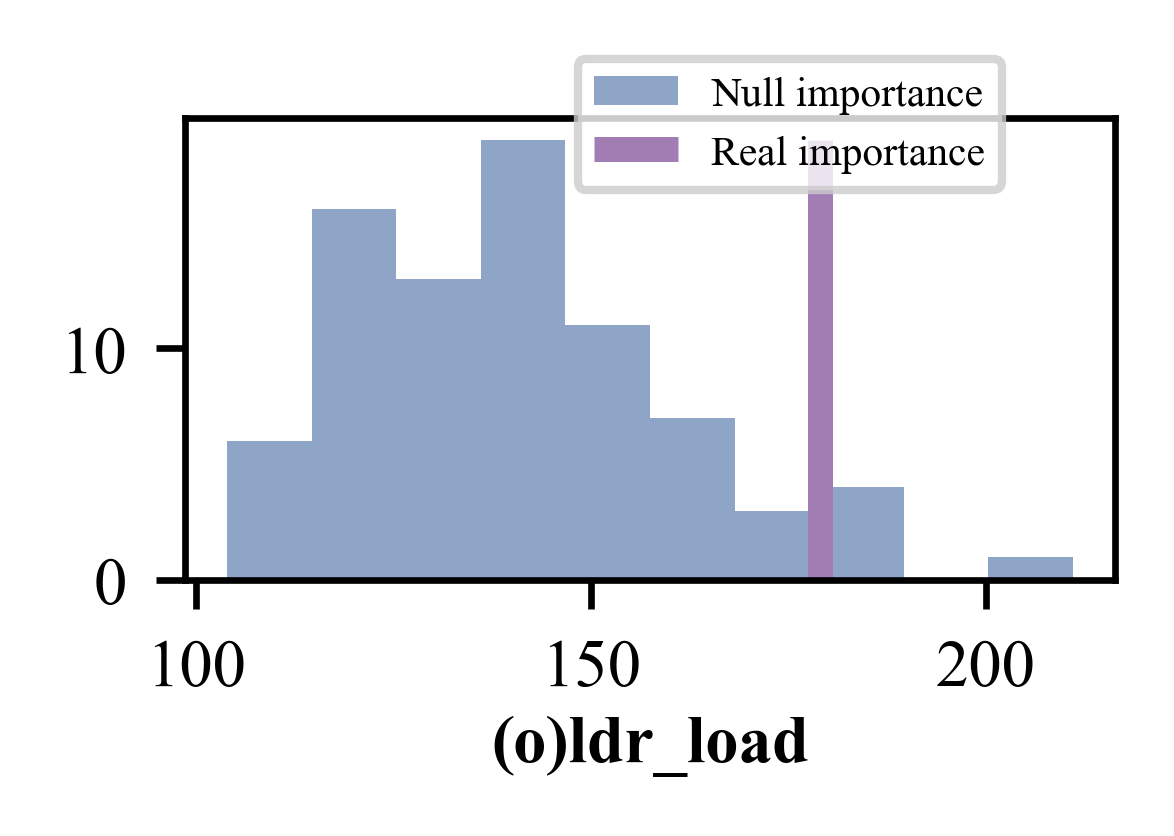

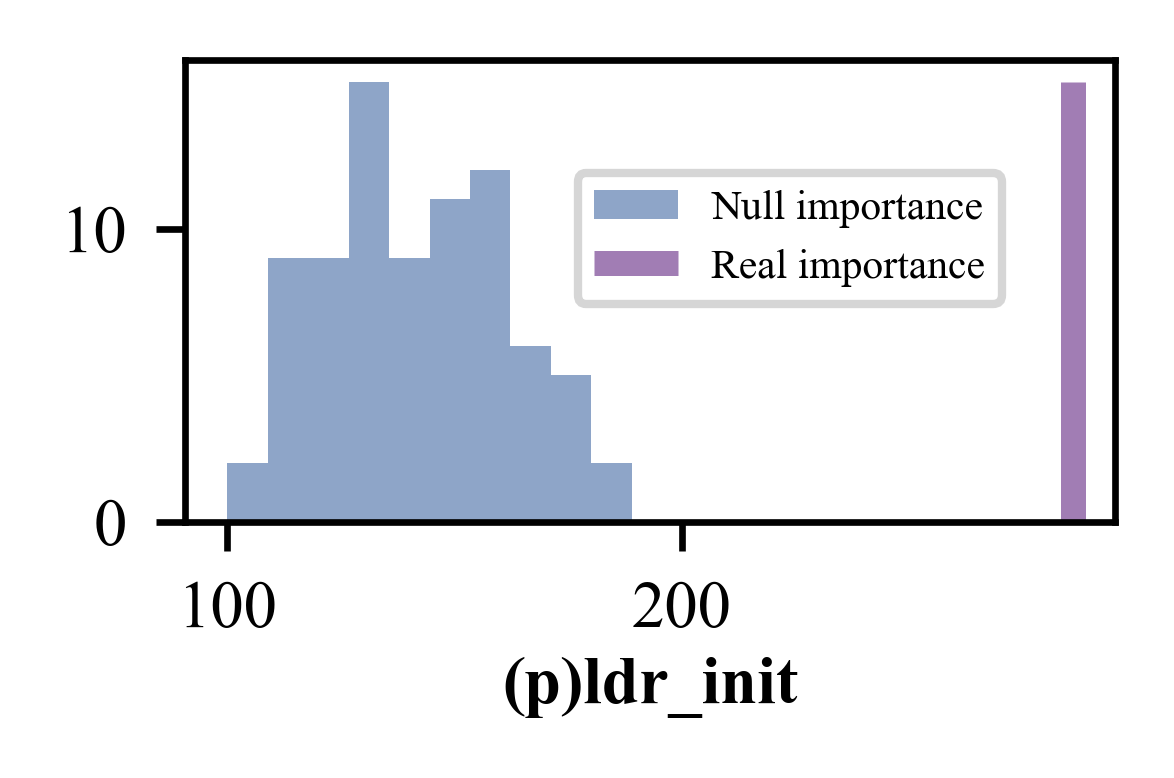

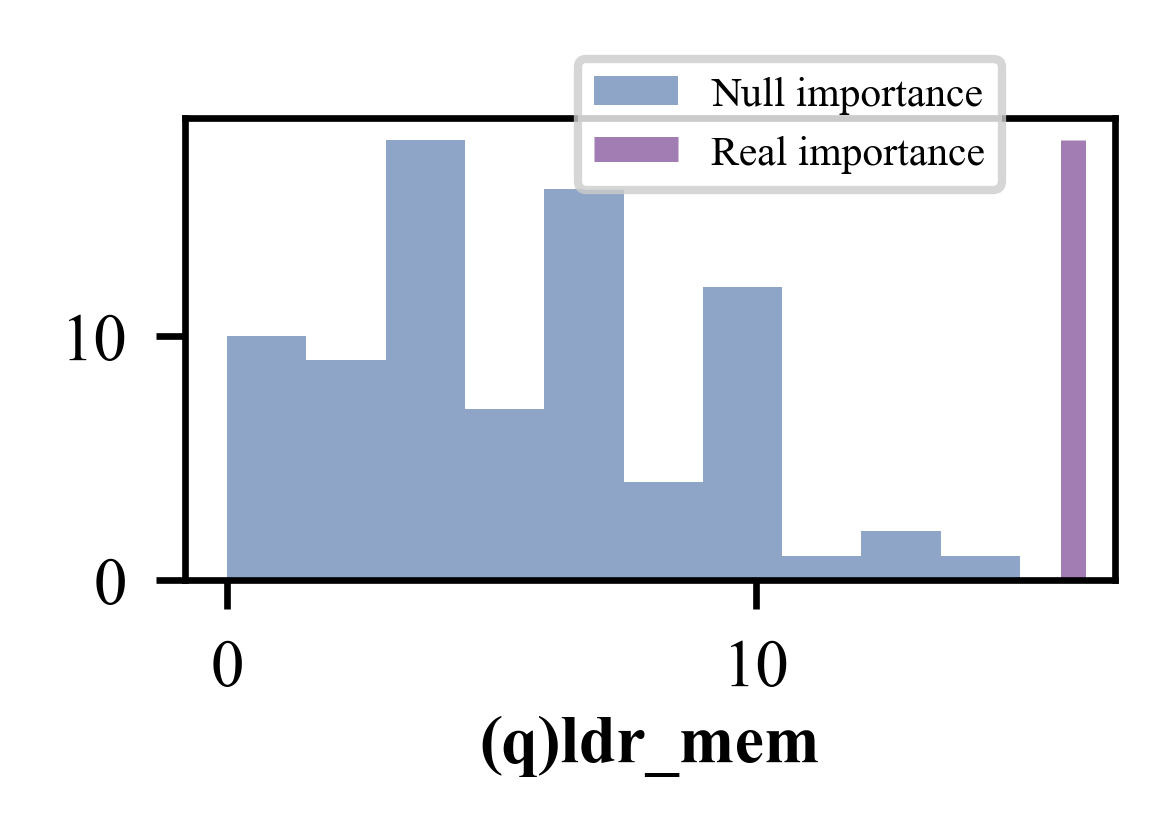

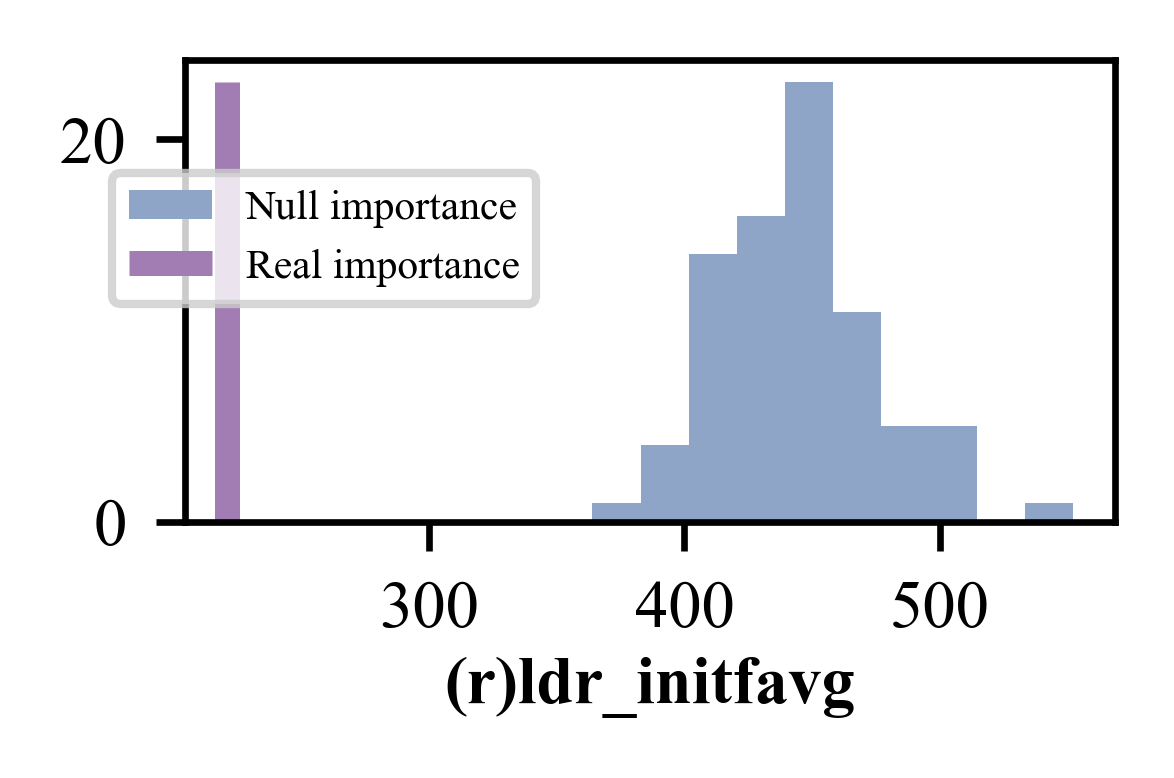

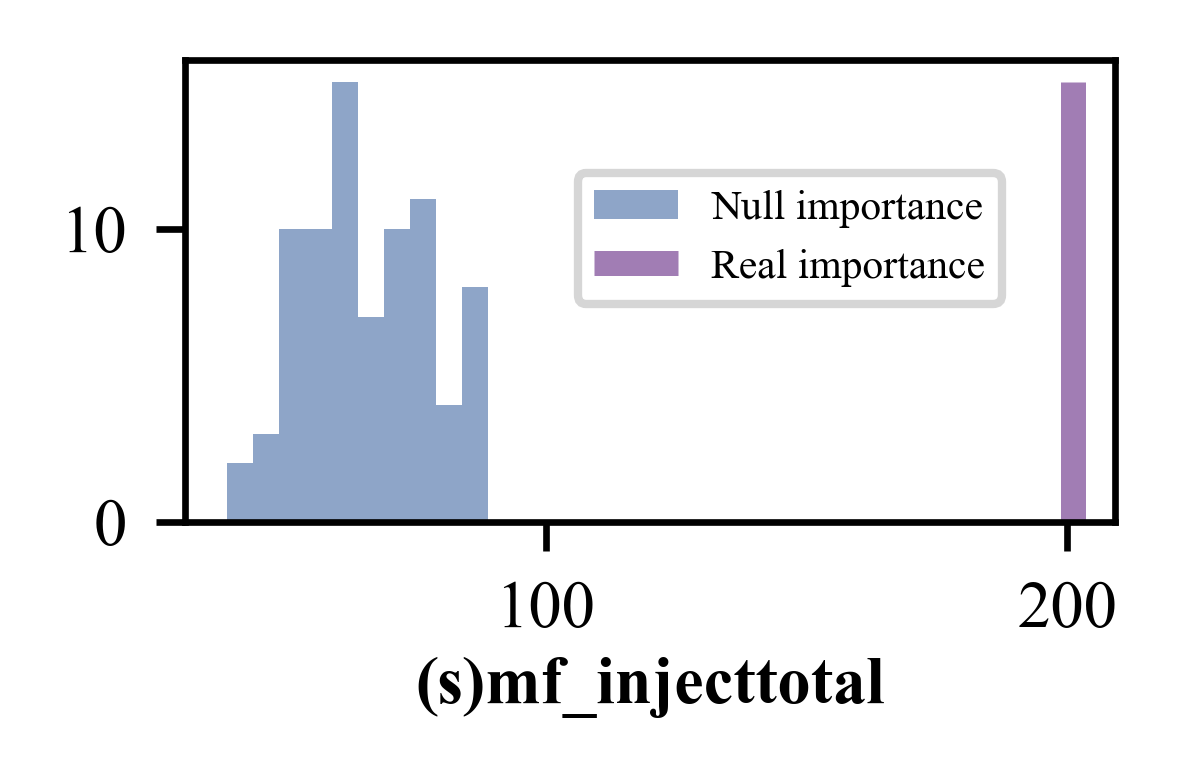

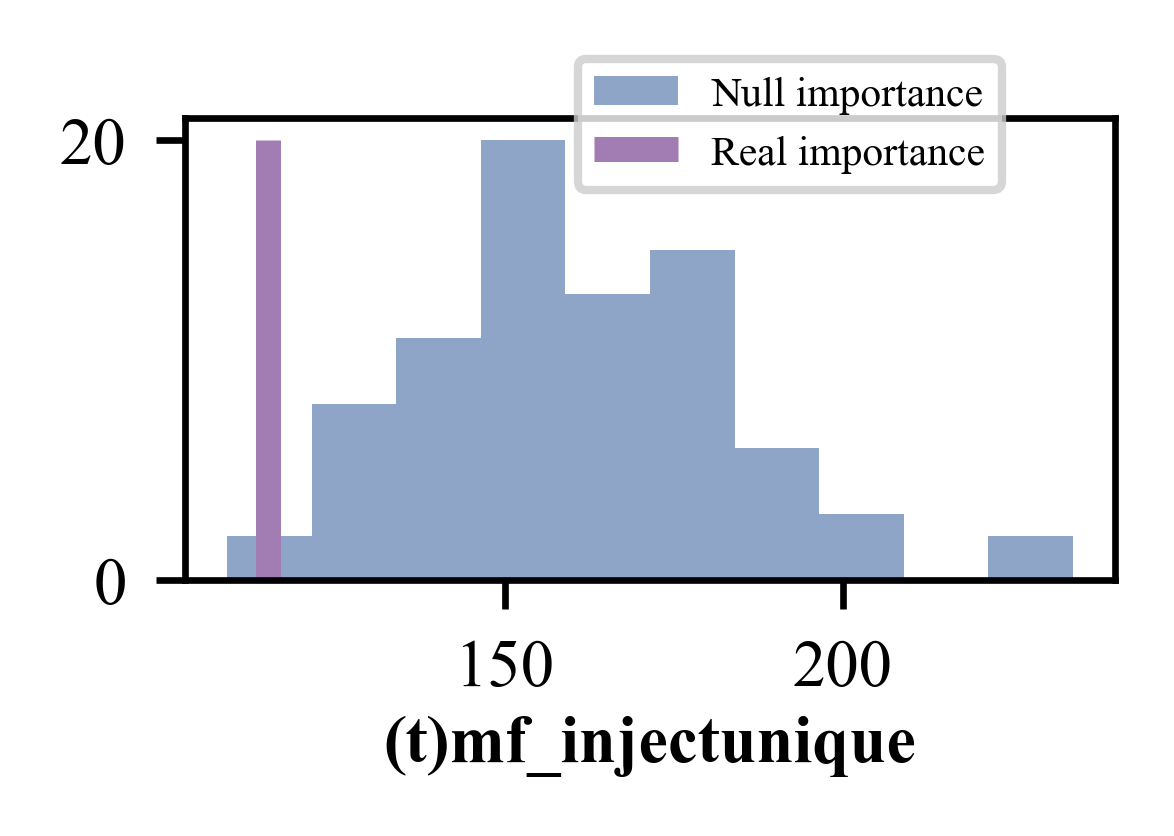

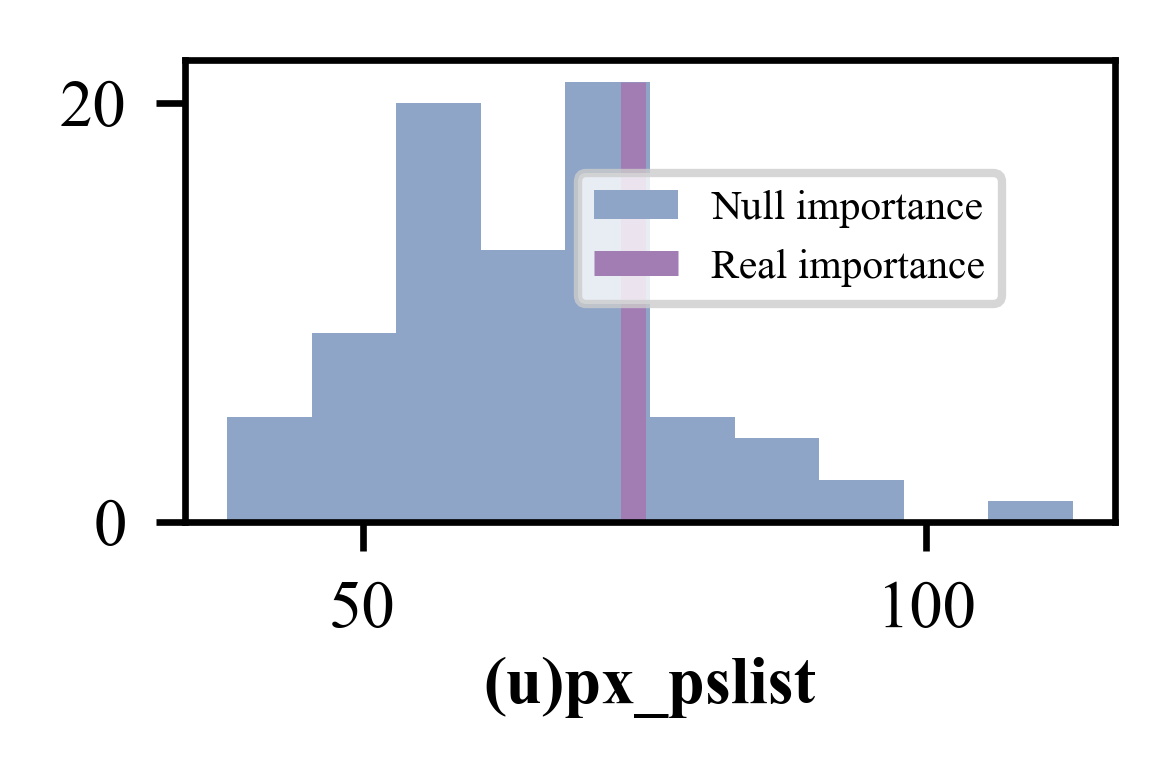

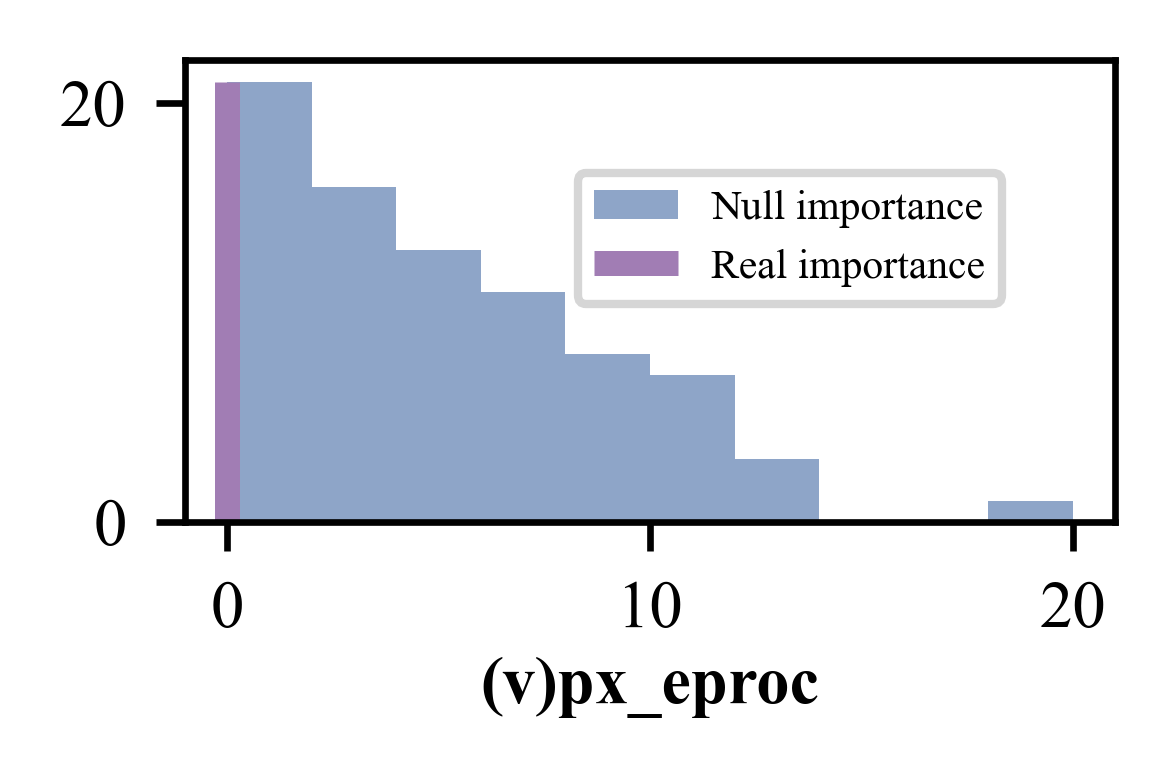

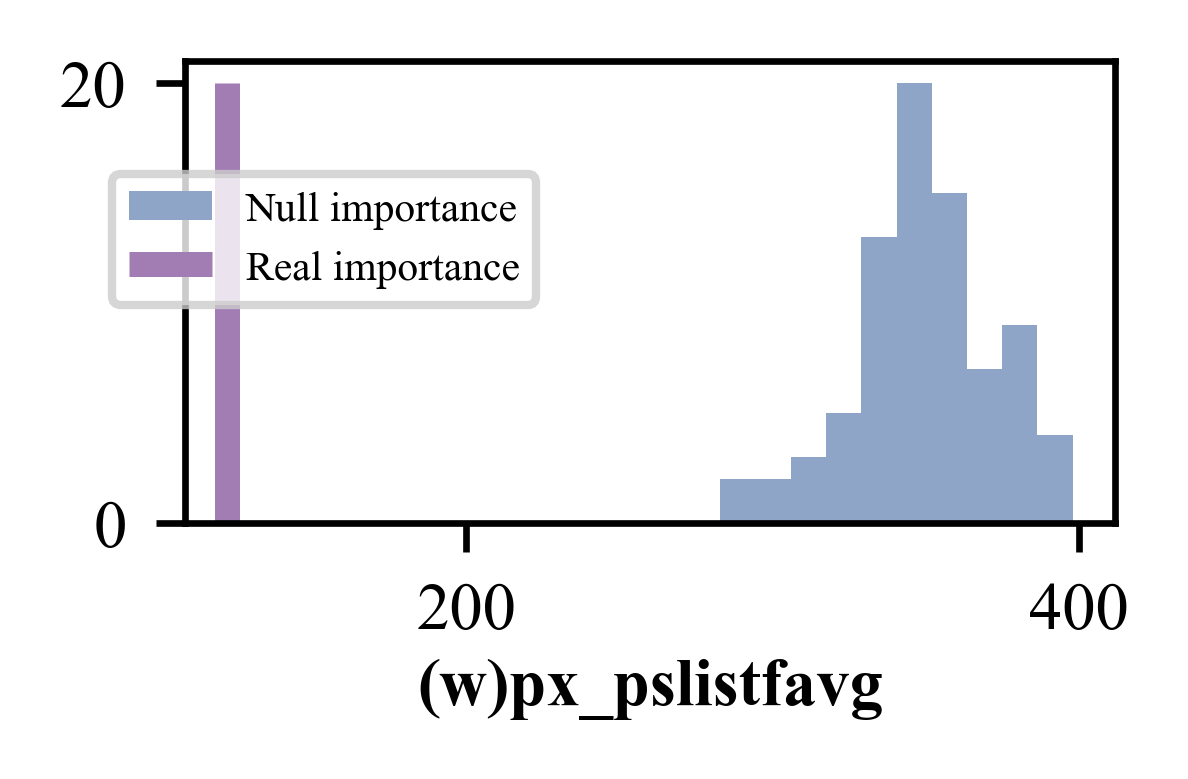

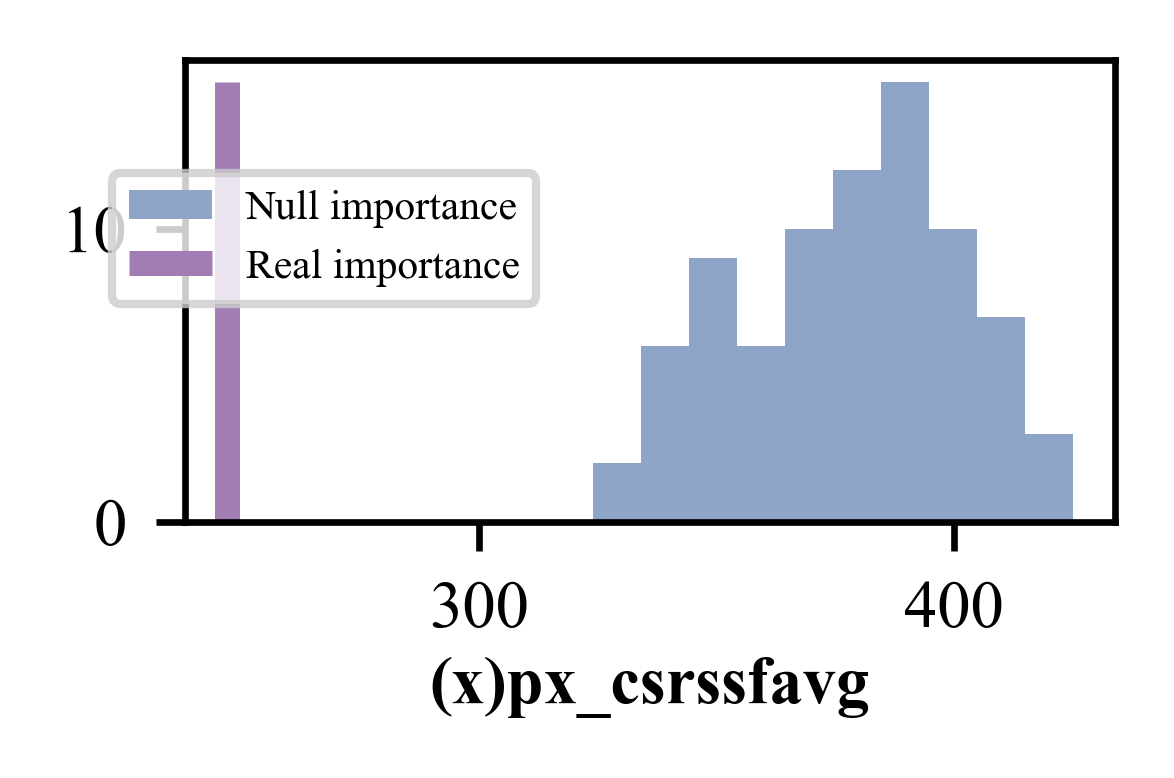

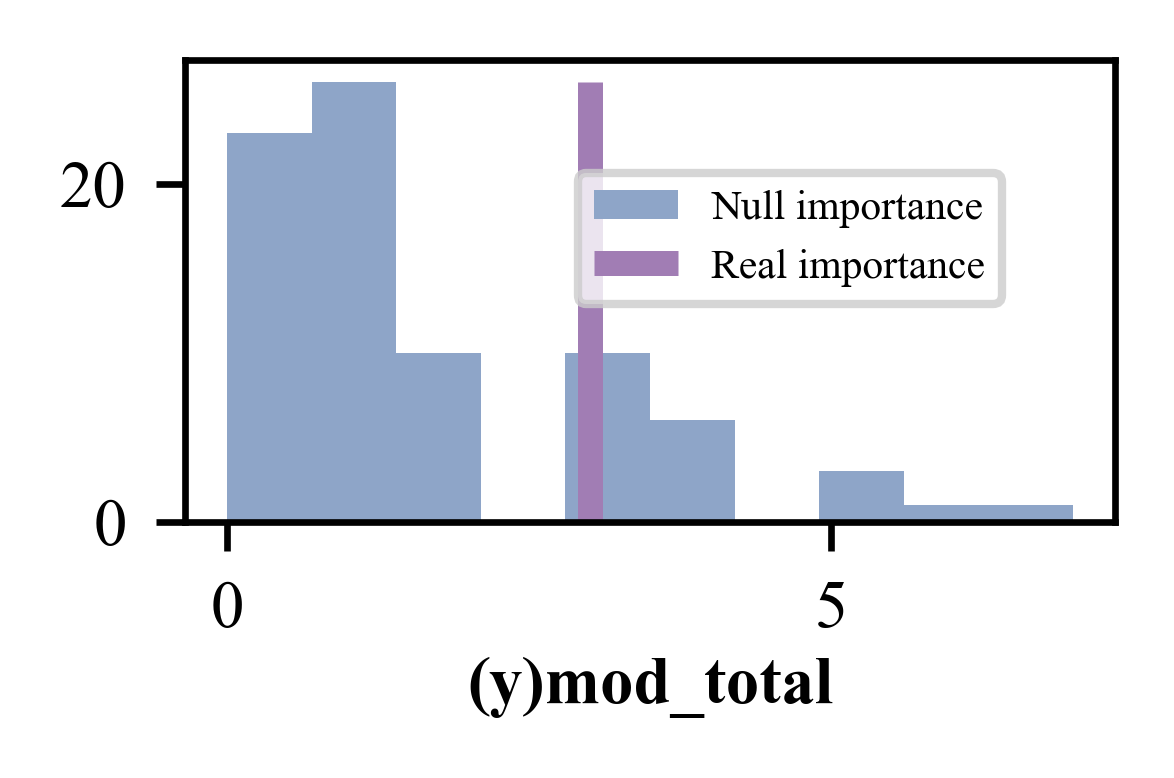

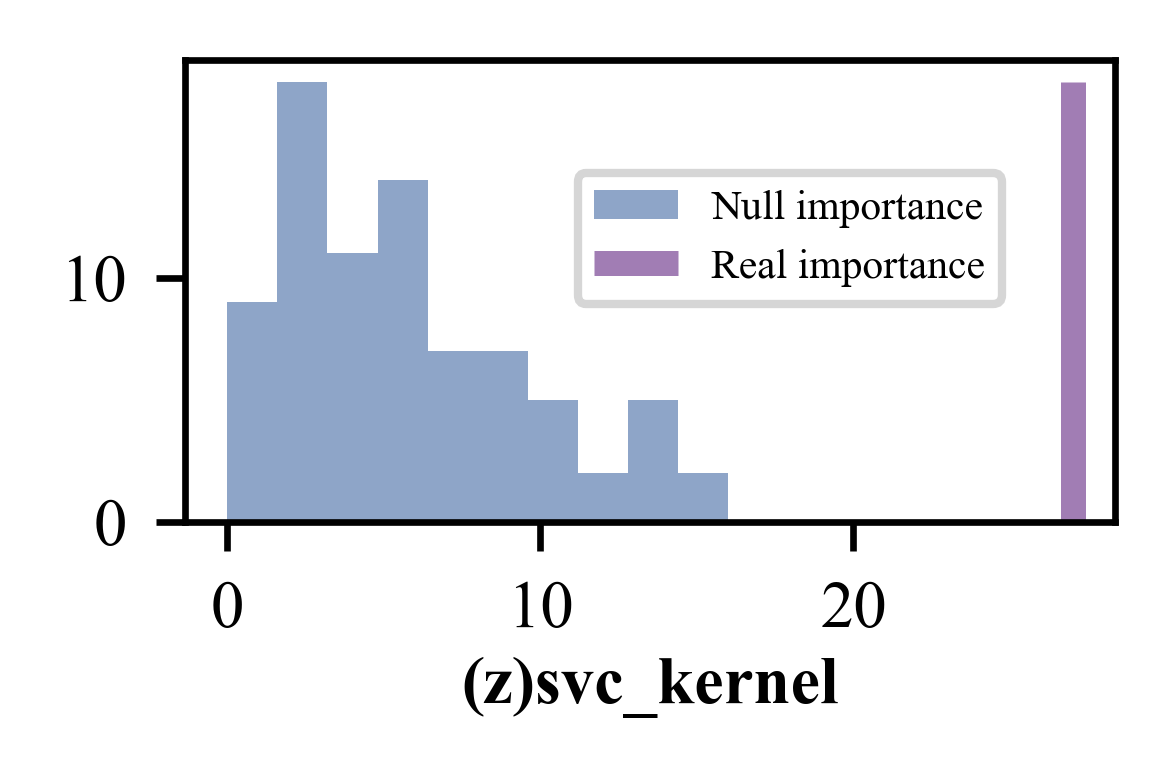

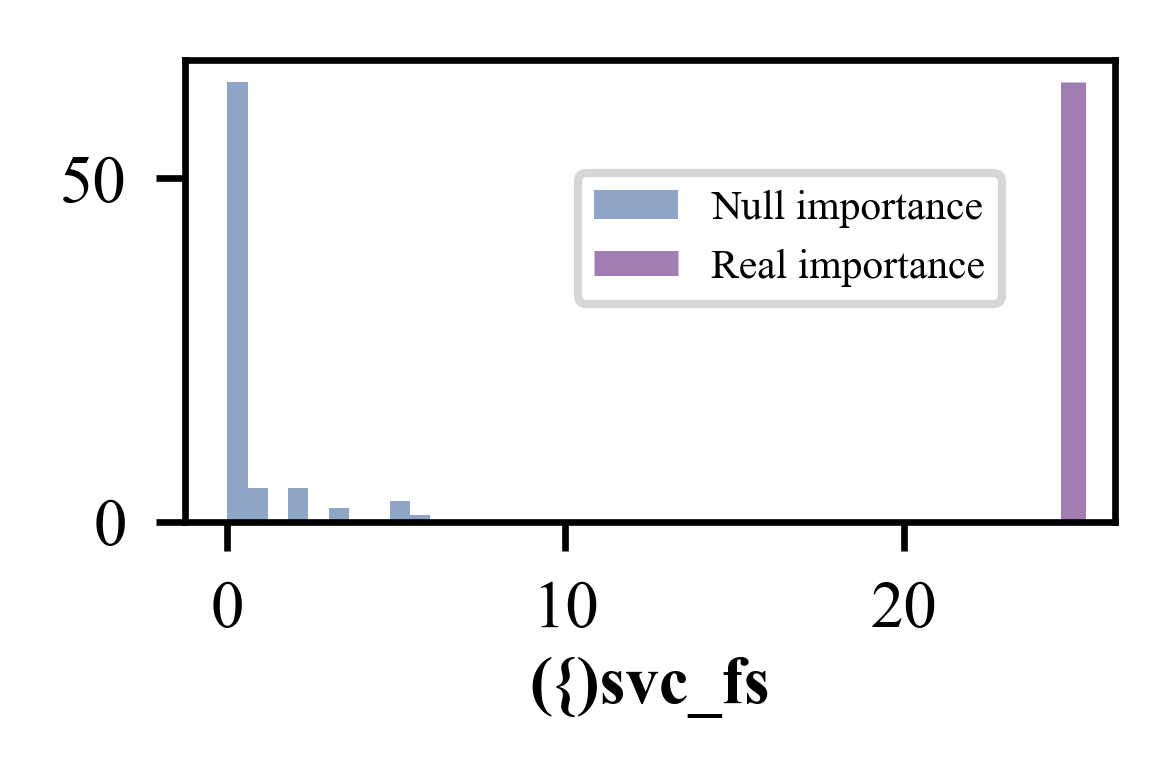

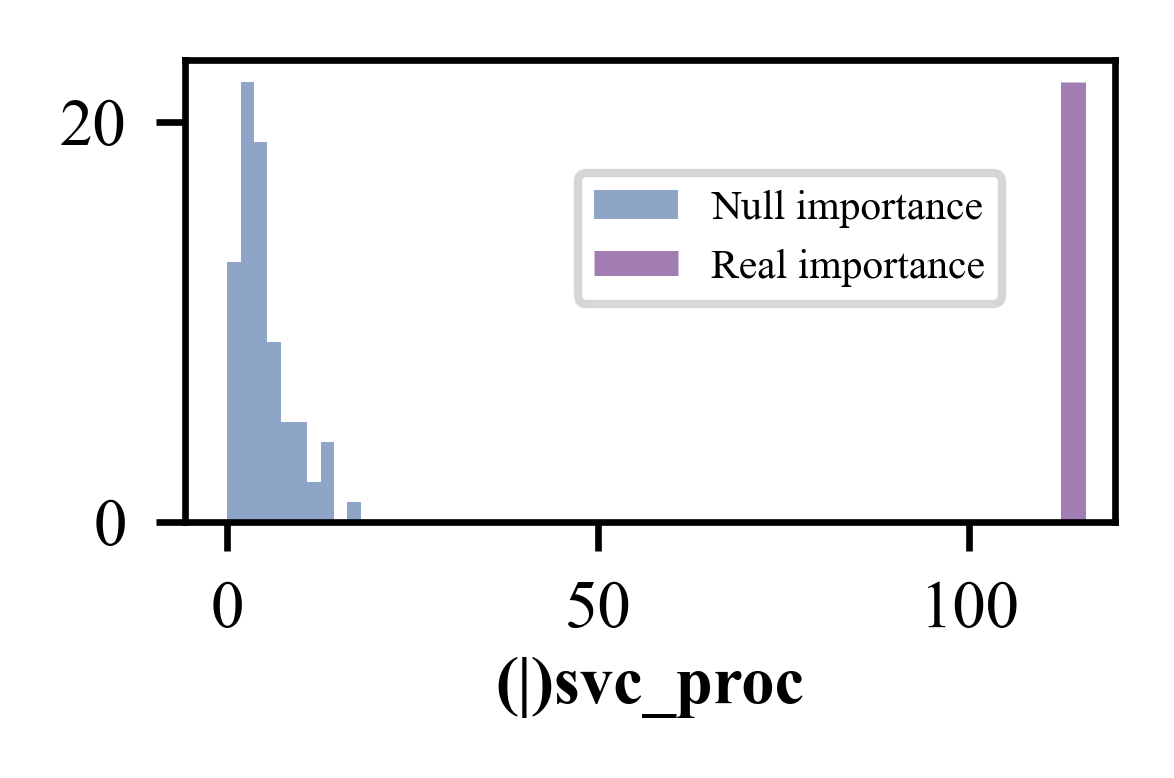

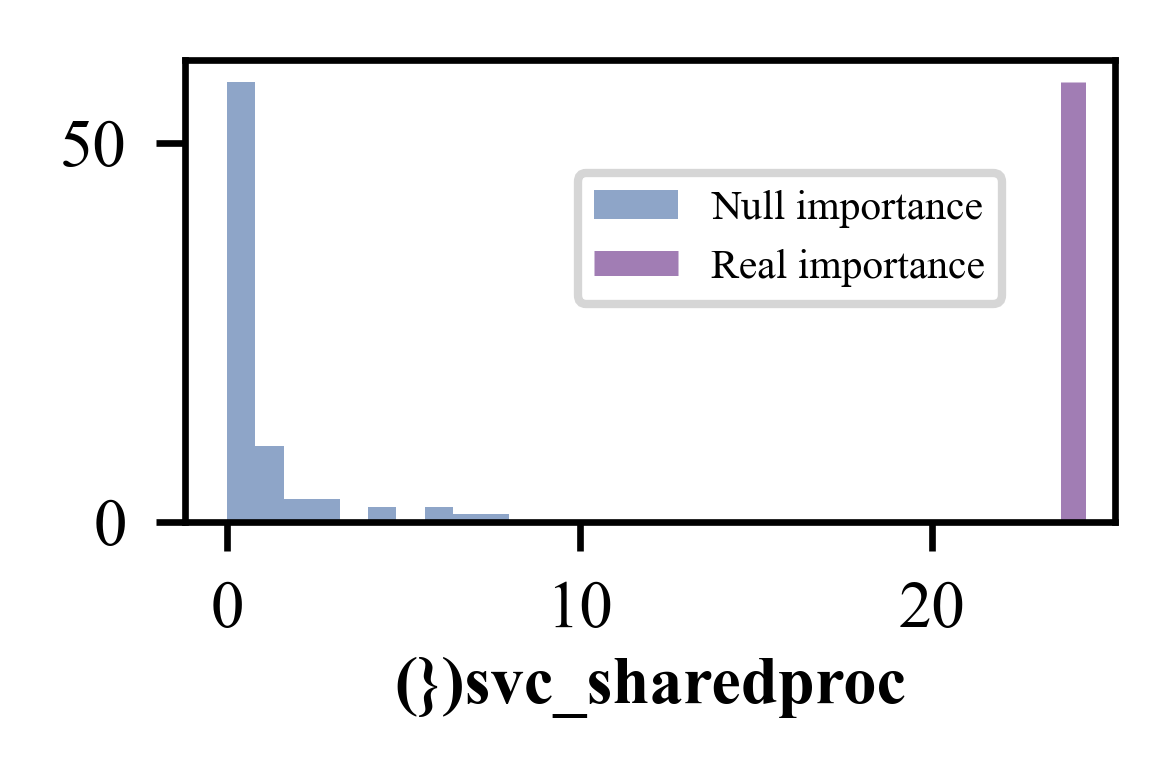

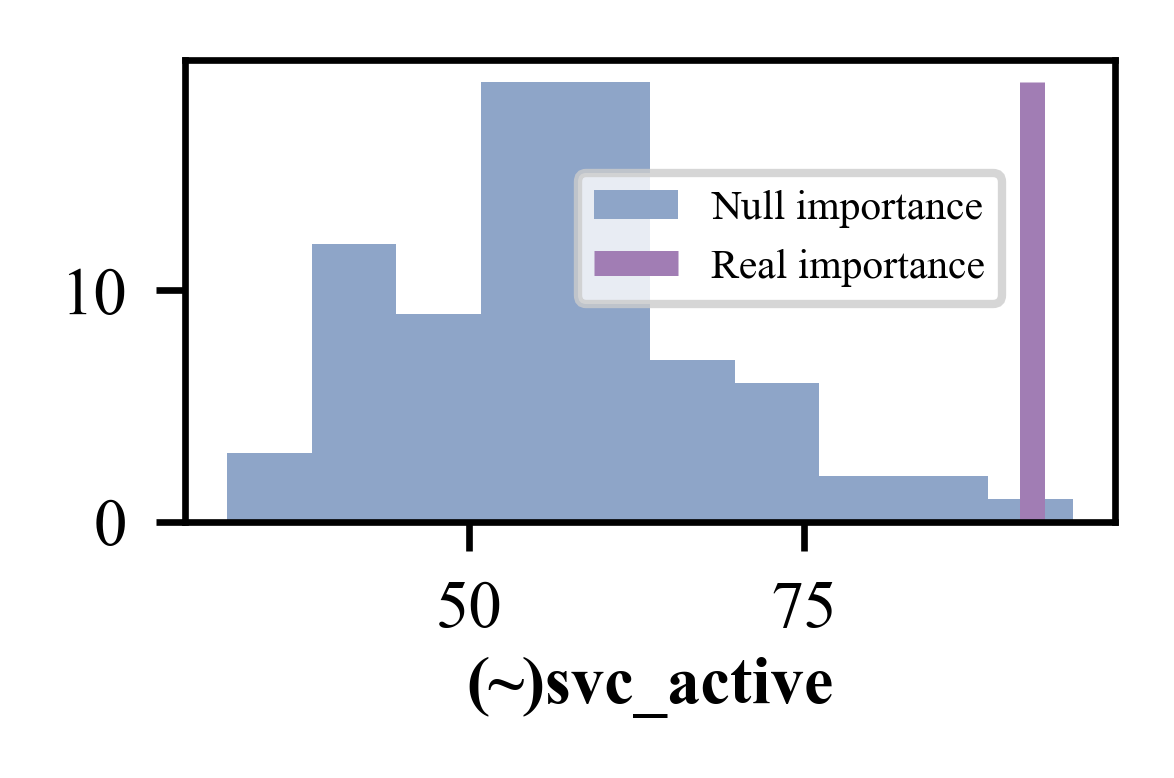

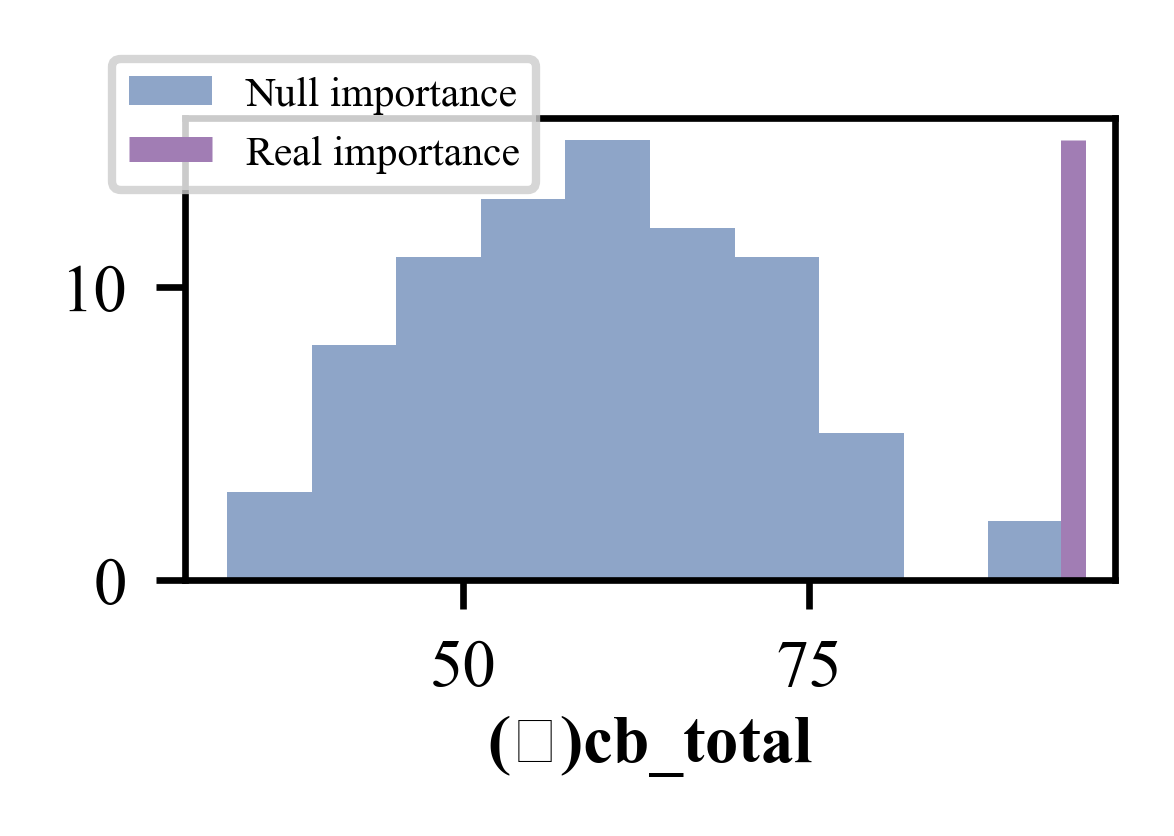

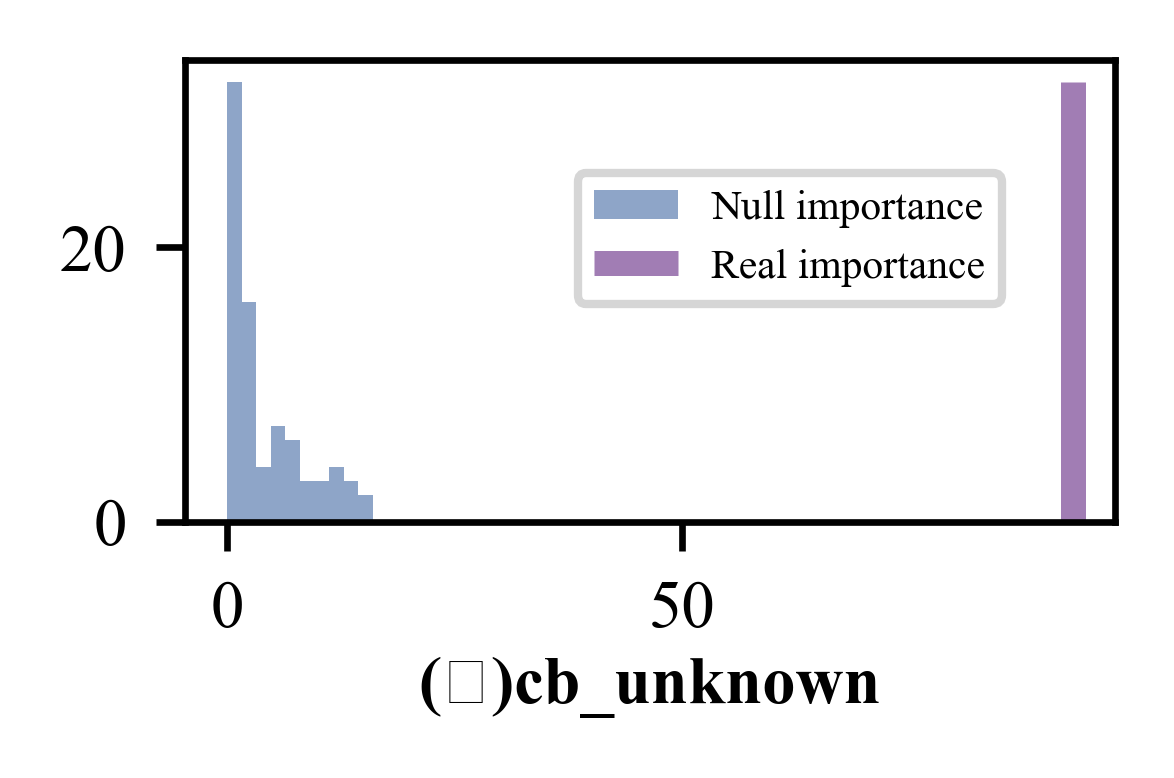

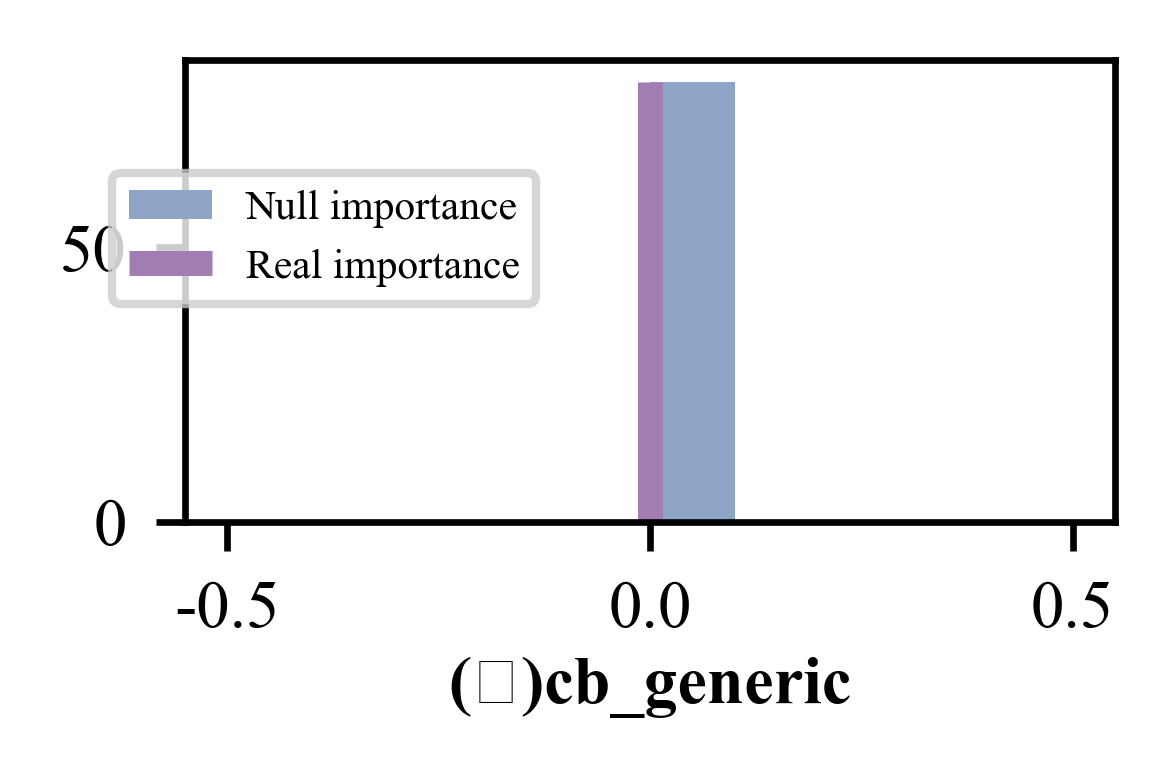

In [20]:
split_polt_imp(null_imp_df, pd.DataFrame(actual_imp_df), num_feats)

In [ ]:
# feature_select=[ 'handles.ndirectory', 
#                 'malfind.ninjections',  'svcscan.process_services', 
#                 'svcscan.shared_process_services', ]

In [64]:
# feature_select=['dlllist.ndlls', 'handles.nevent', 'handles.ndirectory', 'ldrmodules.not_in_init', 'ldrmodules.not_in_mem',
#                 'malfind.ninjections', 'psxview.not_in_eprocess_pool', 'svcscan.process_services', 
#                 'svcscan.shared_process_services', 'callbacks.ncallbacks', 'callbacks.nanonymous']

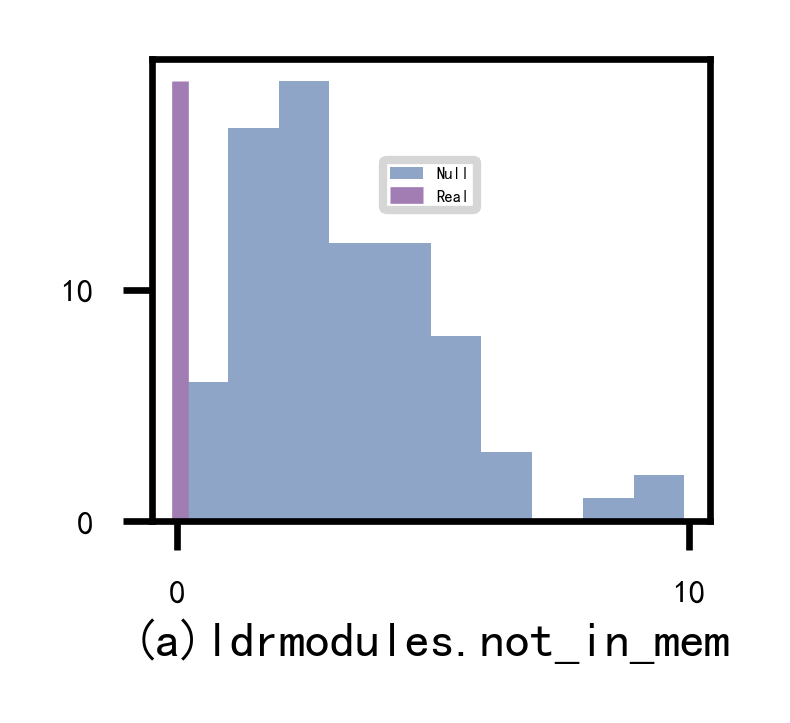

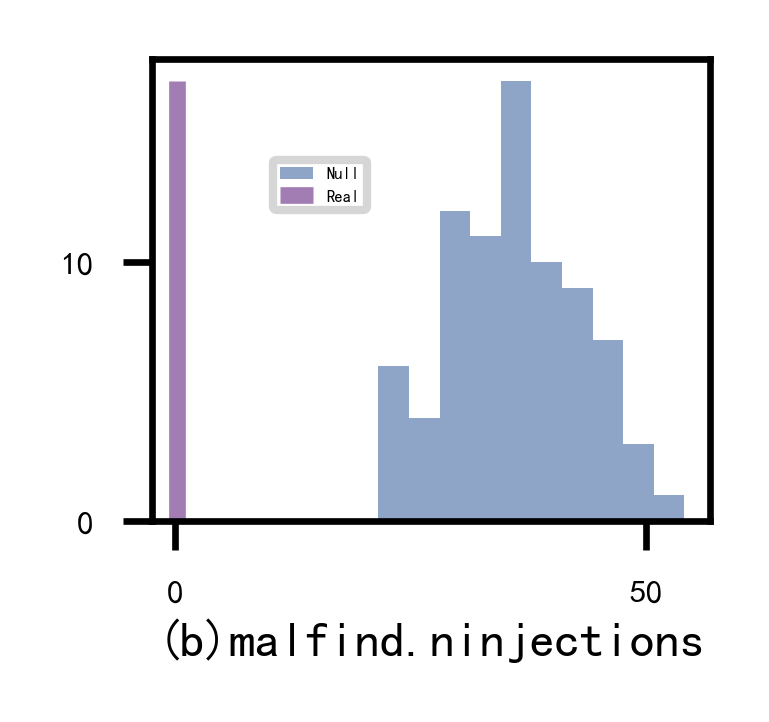

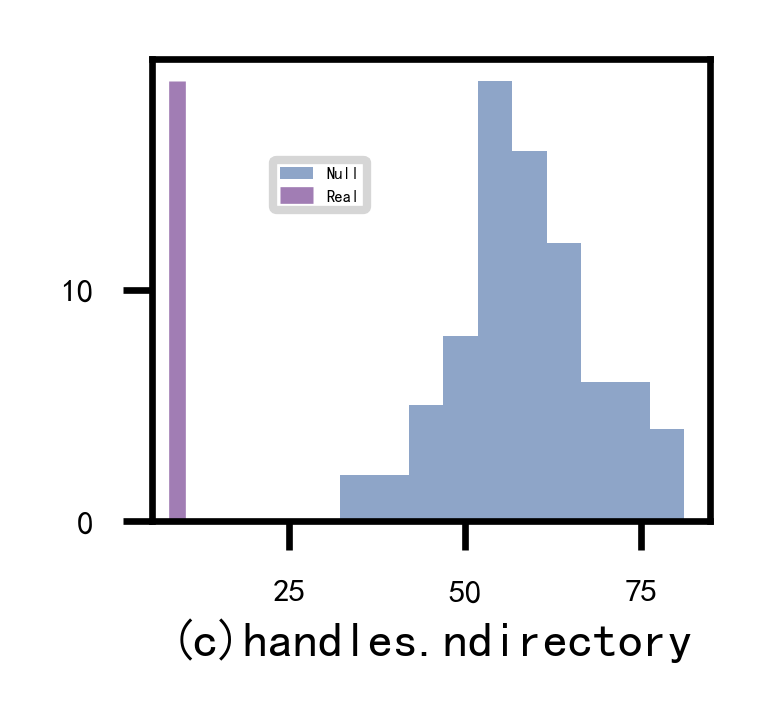

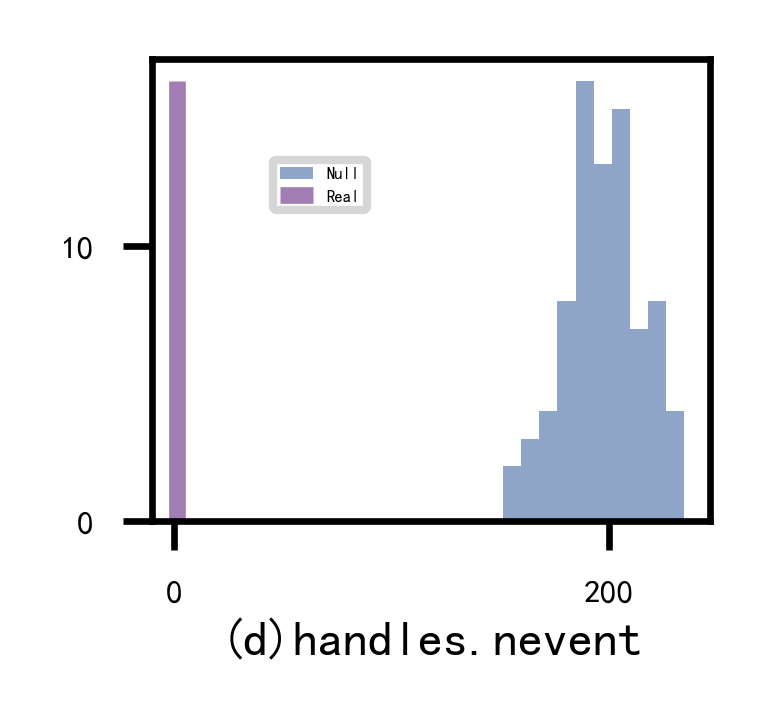

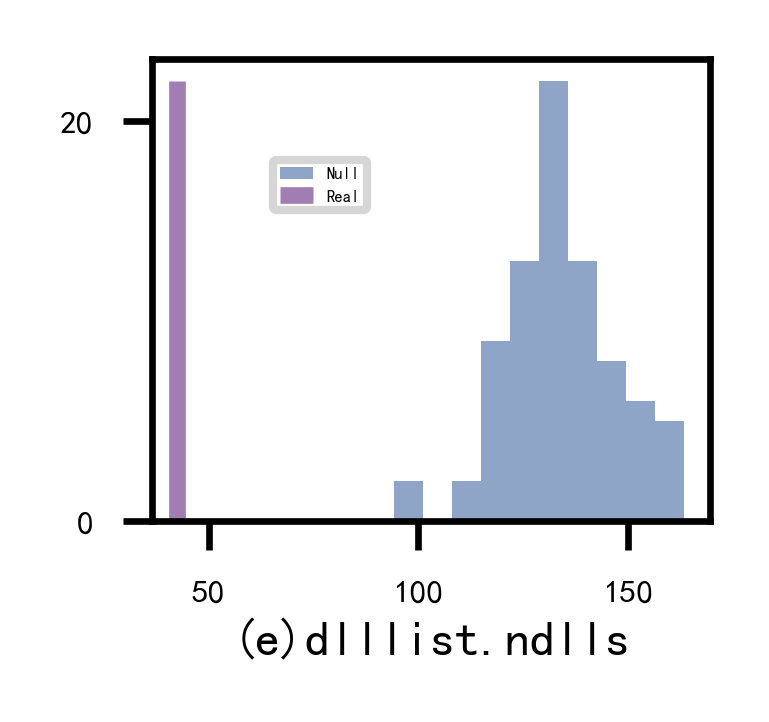

In [65]:
gain_polt_imp(null_imp_df, pd.DataFrame(actual_imp_df), feature_select)

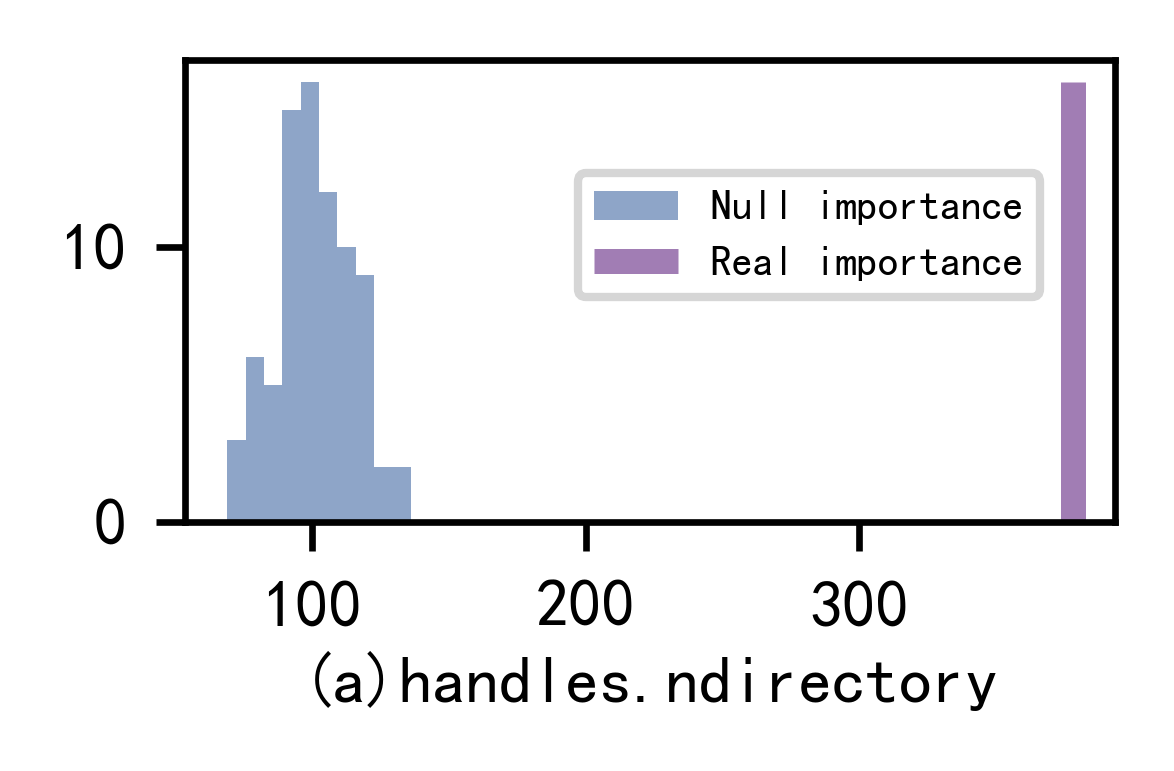

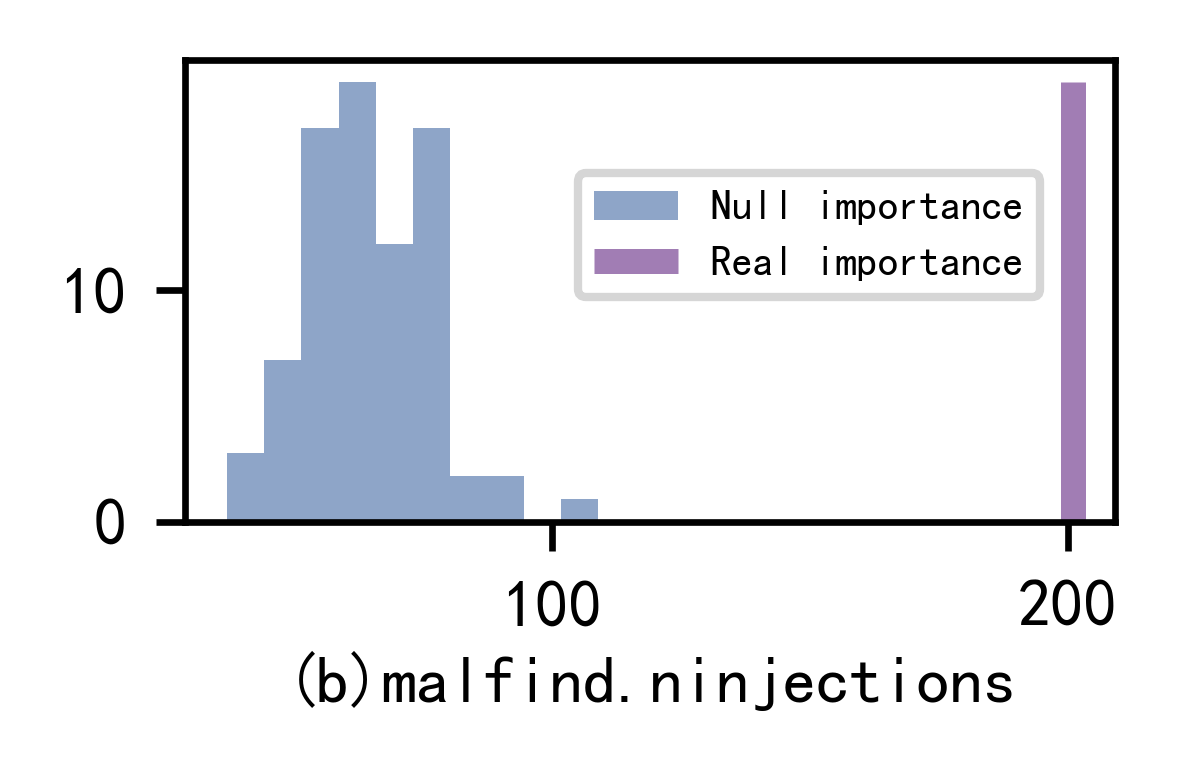

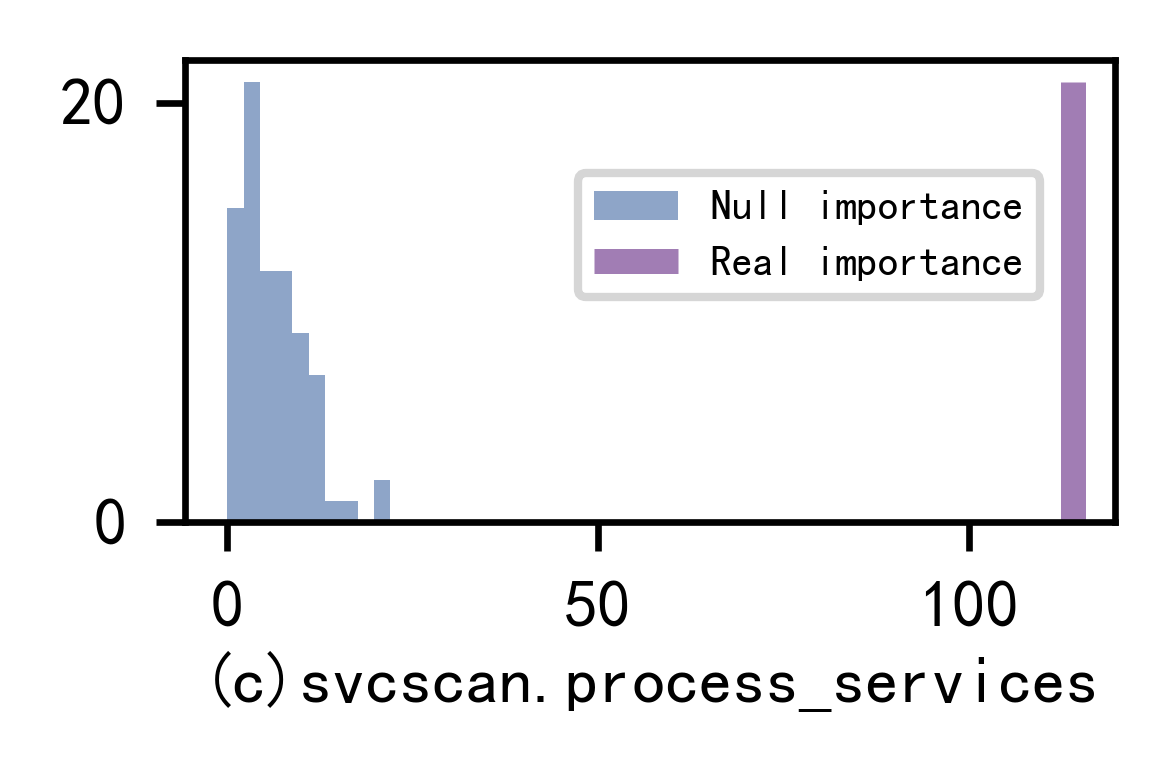

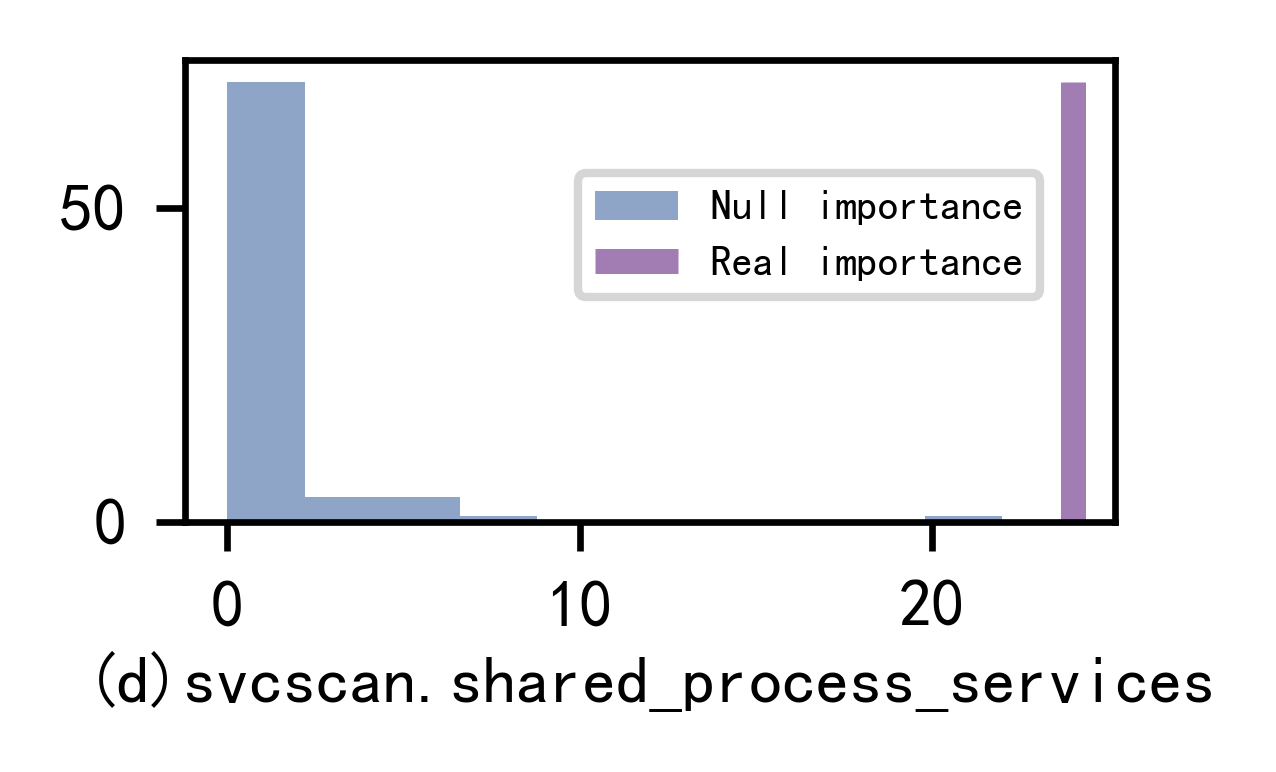

In [98]:
split_polt_imp(null_imp_df, pd.DataFrame(actual_imp_df), feature_select)

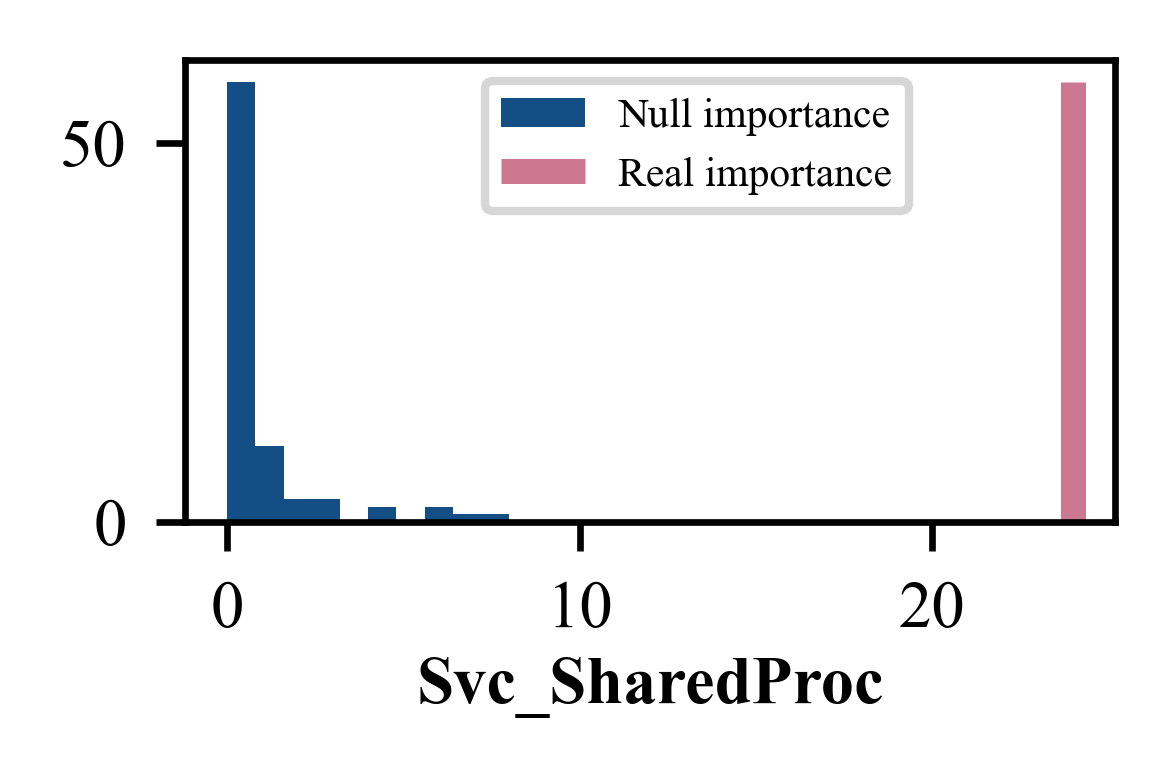

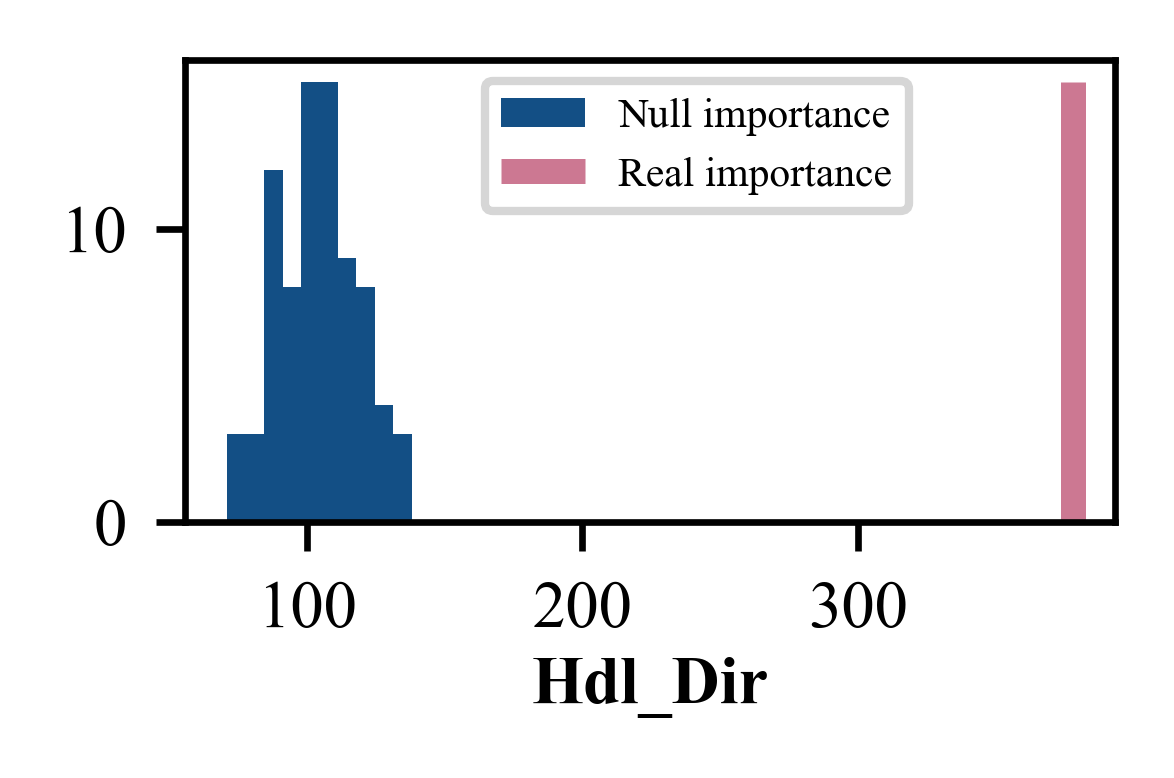

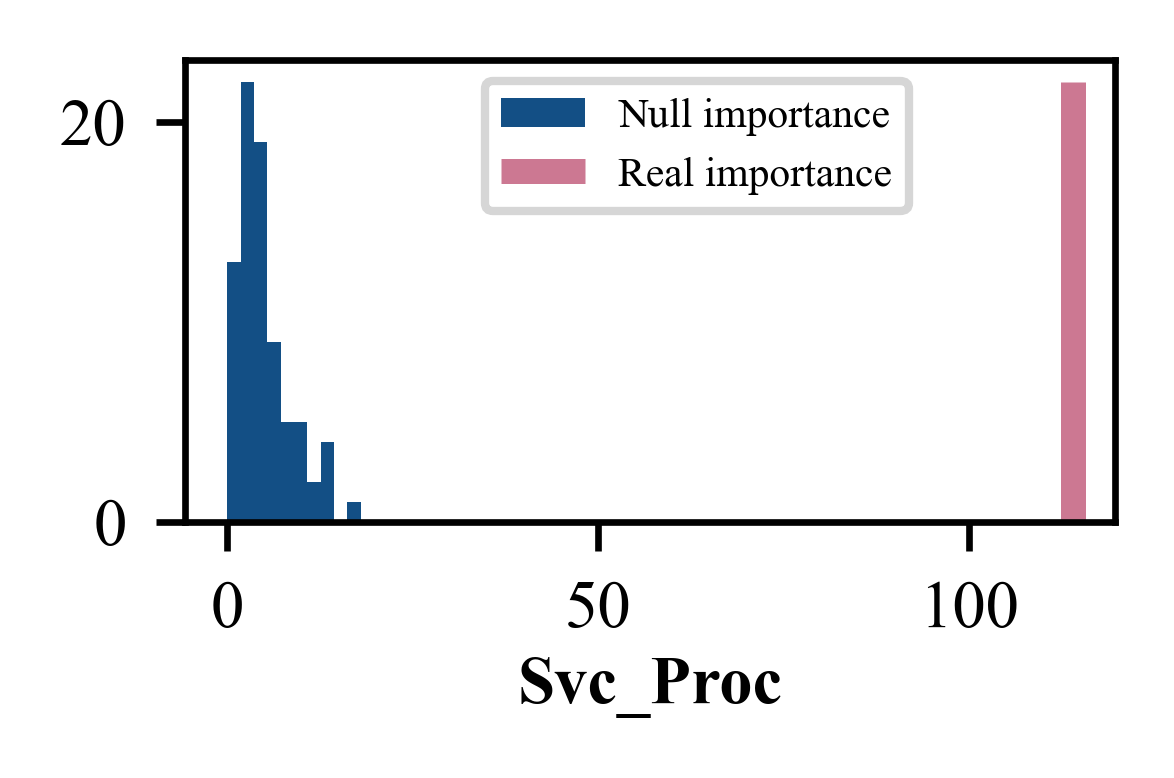

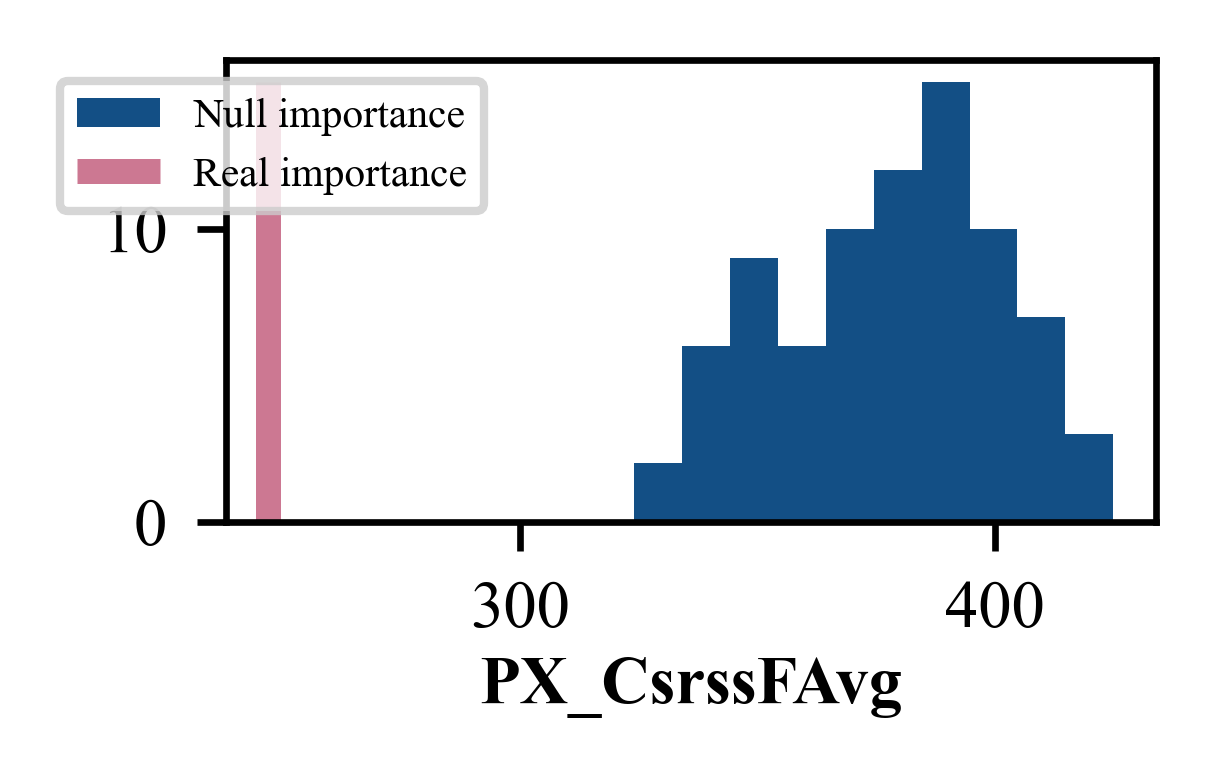

In [36]:
import matplotlib.pyplot as plt

# 绘制特征重要性对比图
def split_polt_imp(data1, data2, num_feats):
    plt.rcParams['font.family'] = 'Times New Roman'  # 设置字体为 Times New Roman
    for i, feat in enumerate(num_feats):  # 使用enumerate函数进行遍历并获取索引
        plt.figure(dpi=600, figsize=(2, 1))  # 设置图像分辨率和大小
        x1 = data1[data1['feature'] == feat]['importance_split'].values
        x2 = data2[data2['feature'] == feat]['importance_split'].mean()
        title_str = feat
        plt.title(title_str, fontweight='bold', fontsize=8, y=-0.5)
        ax = plt.hist(x1, alpha=1, color='#134F85', label='Null importance')
        plt.vlines(x2, 0, ax[0].max(), alpha=1, color='#CC7892', linewidth=3, label='Real importance')
        
        # 将图例位置调整到最上方正中间
        plt.legend(loc='best',bbox_to_anchor=(0.3, 1),fontsize=5,)
        
        plt.xticks(fontsize=8)  # 设置x刻度字体大小
        plt.yticks(fontsize=8)  # 设置y刻度字体大小
        
        # 保存图像
        plt.savefig(feat + 'importance_split.jpg', dpi=600, bbox_inches='tight', pad_inches=0)
        plt.savefig(feat + 'importance_split.svg', dpi=600, bbox_inches='tight', pad_inches=0)
        
        plt.show()

# 示例调用
# 假设 data1 和 data2 是你的数据，num_feats 是特征列表
num_feats = ['Svc_SharedProc', 'Hdl_Dir', 'Svc_Proc',"PX_CsrssFAvg"]
split_polt_imp(null_imp_df, pd.DataFrame(actual_imp_df), num_feats) # 取消注释并传入实际数据

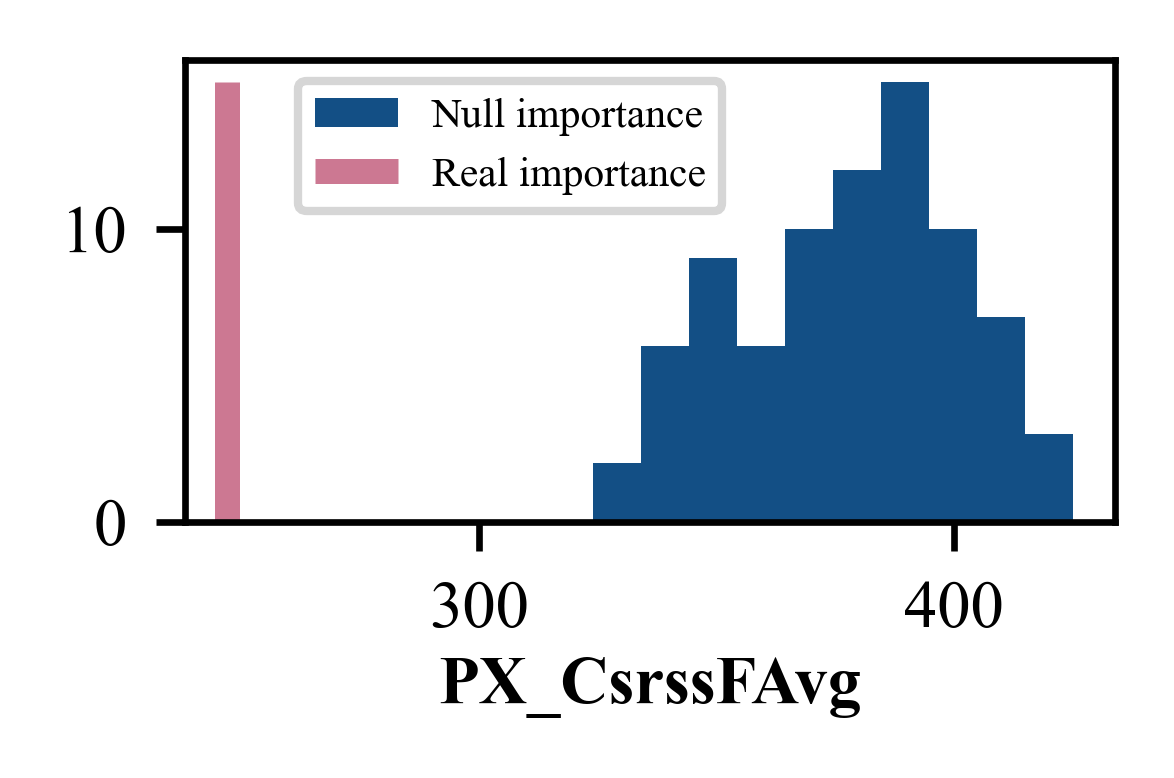

In [39]:
import matplotlib.pyplot as plt

# 绘制特征重要性对比图
def split_polt_imp(data1, data2, num_feats):
    plt.rcParams['font.family'] = 'Times New Roman'  # 设置字体为 Times New Roman
    for i, feat in enumerate(num_feats):  # 使用enumerate函数进行遍历并获取索引
        plt.figure(dpi=600, figsize=(2, 1))  # 设置图像分辨率和大小
        x1 = data1[data1['feature'] == feat]['importance_split'].values
        x2 = data2[data2['feature'] == feat]['importance_split'].mean()
        title_str = feat
        plt.title(title_str, fontweight='bold', fontsize=8, y=-0.5)
        ax = plt.hist(x1, alpha=1, color='#134F85', label='Null importance')
        plt.vlines(x2, 0, ax[0].max(), alpha=1, color='#CC7892', linewidth=3, label='Real importance')
        
        # 将图例位置调整到最上方正中间
        plt.legend(loc='best',bbox_to_anchor=(0.6, 1),fontsize=5,)
        
        plt.xticks(fontsize=8)  # 设置x刻度字体大小
        plt.yticks(fontsize=8)  # 设置y刻度字体大小
        
        # 保存图像
        plt.savefig(feat + 'importance_split.jpg', dpi=600, bbox_inches='tight', pad_inches=0)
        plt.savefig(feat + 'importance_split.svg', dpi=600, bbox_inches='tight', pad_inches=0)
        
        plt.show()

# 示例调用
# 假设 data1 和 data2 是你的数据，num_feats 是特征列表
num_feats = ["PX_CsrssFAvg"]
split_polt_imp(null_imp_df, pd.DataFrame(actual_imp_df), num_feats) # 取消注释并传入实际数据

In [51]:
# 次数占比法：
# 次数占比法计算得分
def time_ratio_comparison(data1, data2, feat):
    x1 = data1[data1['feature'] == feat]['importance_gain'].values
    x2 = data2[data2['feature'] == feat]['importance_gain'].values
    gain_score = 100 * (x1 < np.percentile(x2, 25)).sum() / len(x1)
    x1 = data1[data1['feature'] == feat]['importance_split'].values
    x2 = data2[data2['feature'] == feat]['importance_split'].values
    split_score = 100 * (x1 < np.percentile(x2, 25)).sum() / len(x1)
    return [feat, gain_score, split_score]

In [58]:
# 计算次数占比法得分及其可视化：
# 计算次数占比法下的特征得分
time_ratio_comparison_res = []
for feat in feats:
    time_ratio_comparison_res.append(time_ratio_comparison(null_imp_df, actual_imp_df, feat))
time_ratio_comparison_df = pd.DataFrame(data=time_ratio_comparison_res, columns=['feature', 'gain_score', 'split_score'])
time_ratio_comparison_df.head()

,feature,gain_score,split_score
0,PL_PPID,0.0,100.00
1,PL_ThreadAvg,0.0,0.00
2,PL_HandleAvg,0.0,73.75
3,DLL_Total,0.0,95.00
4,DLL_AvgPerProc,100.0,75.00


In [59]:
time_ratio_comparison_df

,feature,gain_score,split_score
0,PL_PPID,0.00,100.00
1,PL_ThreadAvg,0.00,0.00
2,PL_HandleAvg,0.00,73.75
3,DLL_Total,0.00,95.00
4,DLL_AvgPerProc,100.00,75.00
5,Hdl_AvgPerProc,0.00,1.25
6,Hdl_Event,0.00,0.00
7,Hdl_Key,0.00,0.00
8,Hdl_Thread,0.00,75.00
9,Hdl_Dir,0.00,100.00
